In [1]:
import torch
import torchinfo
import clip  # Import CLIP library
from torch.utils.data import DataLoader

from level_1_dataloader import image_dataloader
from level_1_classifier_1 import level_1_classifier, level_1_model, level_1_output_layer
from level_2_classifier import level_2_classifier, level_2_output_layer, level_2_pre_model_concate, level_2_post_model
from Trainer_1 import Trainer_level_1, Trainer_level_2
from Tester_1 import Tester_level_1, Tester_level_2

import copy

In [2]:
train_set = image_dataloader(csv_file='train_set.xls', root_dir='coverpage/coverpage/')
val_set = image_dataloader(csv_file='val_set.xls', root_dir='coverpage/coverpage/')
test_set = image_dataloader(csv_file='test_set.xls', root_dir='coverpage/coverpage/')


In [3]:
print('no. of training sample', len(train_set))
print('no. of validation sample', len(val_set))
print('no. of testing sample', len(test_set))

no. of training sample 22340
no. of validation sample 2804
no. of testing sample 2809


In [4]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [5]:
import torch
import torch.nn as nn
from torchvision import models

def fine_tune_load_model():
    """Loads pre-trained EfficientNet-B3 model and removes the classification head."""
    # Load the pre-trained EfficientNet-B3 model
    model = models.efficientnet_b3(pretrained=True)
    
    print("Original EfficientNet-B3 model:")
    print(model)

    # Remove the classification head
    # EfficientNet's classifier is typically called 'classifier' (a Linear layer)
    # We will replace the classifier with an identity operation
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Identity()
    )

    # Wrap the model to include a Flatten layer after the feature extraction
    class EfficientNetB3Features(nn.Module):
        def __init__(self, model):
            super(EfficientNetB3Features, self).__init__()
            self.features = model.features
            self.flatten = nn.Flatten()
            self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        
        def forward(self, x):
            x = self.features(x)
            x = torch.nn.functional.relu(x, inplace=True)
            x = self.pooling(x)
            x = self.flatten(x)
            return x

    # Create the modified model
    new_model = EfficientNetB3Features(model)

    return new_model

# Call the function to create the new model (without the last layer)
new_efficientnetb3_model = fine_tune_load_model()
print(new_efficientnetb3_model)


Original EfficientNet-B3 model:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          

/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
FE_model = fine_tune_load_model()
print(FE_model)

Original EfficientNet-B3 model:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          

In [7]:
torchinfo.summary(FE_model, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNetB3Features                                  [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 40, 112, 112]         1,080                     [3, 3]                    13,547,520
│    │    └─BatchNorm2d: 3-2                            [1, 40, 112, 112]         [1, 40, 112, 112]         80                        --                        80
│    │ 

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNetB3Features                                  [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 40, 112, 112]         1,080                     [3, 3]                    13,547,520
│    │    └─BatchNorm2d: 3-2                            [1, 40, 112, 112]         [1, 40, 112, 112]         80                        --                        80
│    │ 

In [8]:
import os

used_model = 'Efficientnet-B3'
used_model_feature_size = 1536
level_1_checkpoint_dir = './checkpoints/' + used_model + '/level_1/'
level_1_model_file = 'model.pth'
level_1_csvlogger_file = 'log.csv'
level_1_weights_path = os.path.join(level_1_checkpoint_dir, level_1_model_file)
feature_size_extract_from_level_1 = 64
no_epoch = 10
lr = 0.00001
optimizer = 'AdamW'

# Create the directory if it doesn't exist
os.makedirs(level_1_checkpoint_dir, exist_ok=True)

# Print a message to confirm the directory creation (optional)
print(f"Directory {level_1_checkpoint_dir} is ready.")

Directory ./checkpoints/Efficientnet-B3/level_1/ is ready.


In [9]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)

In [10]:
model_level_1

level_1_model(
  (pre_model): EfficientNetB3Features(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
      

In [11]:

# print(model_level_1)
torchinfo.summary(model_level_1, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_1_model                                                [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         1,160                     --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         3,504                     --    

/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_1_model                                                [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         1,160                     --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         3,504                     --    

In [12]:
trainer = Trainer_level_1(model=model_level_1, level=1, training_dataloader=train_dataloader, validation_dataloader=val_dataloader, epoch=no_epoch, learning_rate=lr, use_gpu=True, opt_method=optimizer, checkpoint_dir=level_1_checkpoint_dir, checkpoint_filename=level_1_model_file, csv_logger=level_1_csvlogger_file)


Finish initializing...
2024-06-12 11:54:52.615285
EPOCH 1:


100%|██████████████████████████| 699/699 [25:01<00:00,  2.15s/batch, loss=0.807]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6688378178681086, train_precision_0.6066921288608436, train_recall_0.6264037719674239, train_f1 0.6163904002699396, train_acc_0.592882721575649, train_ba_0.5913283496839461, train_spec_0.5562529274004684, train_hm_0.4071172784243509, val_loss 0.6144773960113525, val_precision_0.6851428571428572, val_recall_0.7785714285714286, val_f1 0.7288753799392098, val_acc_0.68188302425107, val_ba_0.6713268535262207, val_spec_0.5640822784810127, val_hm_0.3181169757489301
2024-06-12 12:20:51.839675
EPOCH 2:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:55<00:00,  2.22s/batch, loss=0.435]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.581251269075833, train_precision_0.7095734126984127, train_recall_0.7357908272610373, train_f1 0.7224443415681159, train_acc_0.7047896150402865, train_ba_0.7033520881035866, train_spec_0.6709133489461359, train_hm_0.2952103849597135, val_loss 0.5524879097938538, val_precision_0.794435857805255, val_recall_0.6675324675324675, val_f1 0.7254763585038815, val_acc_0.7225392296718973, val_ba_0.7285447147788919, val_spec_0.7895569620253164, val_hm_0.27746077032810273
2024-06-12 12:47:46.267115
EPOCH 3:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████| 699/699 [25:16<00:00,  2.17s/batch, loss=1.18]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.5241009764405279, train_precision_0.7562269964906274, train_recall_0.7573939134162023, train_f1 0.7568100051396265, train_acc_0.7458370635631155, train_ba_0.7453011721647756, train_spec_0.733208430913349, train_hm_0.25416293643688453, val_loss 0.5078631043434143, val_precision_0.8073859522085446, val_recall_0.724025974025974, val_f1 0.7634371790482711, val_acc_0.7535663338088445, val_ba_0.7567914680256452, val_spec_0.7895569620253164, val_hm_0.2464336661911555
2024-06-12 13:14:00.679139
EPOCH 4:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:16<00:00,  2.17s/batch, loss=0.764]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.4764261523285649, train_precision_0.7880834848878496, train_recall_0.7801114444920703, train_f1 0.7840772014475272, train_acc_0.7756490599820949, train_ba_0.7754421391078619, train_spec_0.7707728337236534, train_hm_0.2243509400179051, val_loss 0.4823986291885376, val_precision_0.828996282527881, val_recall_0.724025974025974, val_f1 0.7729636048526863, val_acc_0.7664051355206848, val_ba_0.7710319743547591, val_spec_0.8180379746835443, val_hm_0.23359486447931527
2024-06-12 13:40:14.479204
EPOCH 5:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:17<00:00,  2.17s/batch, loss=0.222]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.43339249088784654, train_precision_0.8132039507884249, train_recall_0.8046292327475354, train_f1 0.8088938682294136, train_acc_0.8014771709937332, train_ba_0.8013310098163906, train_spec_0.7980327868852459, train_hm_0.19852282900626678, val_loss 0.4825129210948944, val_precision_0.8580750407830342, val_recall_0.6831168831168831, val_f1 0.7606652205350687, val_acc_0.7639087018544936, val_ba_0.772729327634391, val_spec_0.8623417721518988, val_hm_0.23609129814550642
2024-06-12 14:06:29.495899
EPOCH 6:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:12<00:00,  2.16s/batch, loss=0.922]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.3949662271956347, train_precision_0.8377629642455199, train_recall_0.8295756536648092, train_f1 0.8336492074431427, train_acc_0.8271262309758282, train_ba_0.8270126511883765, train_spec_0.8244496487119438, train_hm_0.1728737690241719, val_loss 0.44553548097610474, val_precision_0.8389405869720831, val_recall_0.7610389610389611, val_f1 0.7980932924753149, val_acc_0.7885164051355207, val_ba_0.7915163159625185, val_spec_0.821993670886076, val_hm_0.21148359486447932
2024-06-12 14:32:39.115658
EPOCH 7:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:14<00:00,  2.17s/batch, loss=0.513]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.35753164317815944, train_precision_0.8553290723786492, train_recall_0.8489498499785684, train_f1 0.8521275222647678, train_acc_0.8461504028648165, train_ba_0.846020592436591, train_spec_0.8430913348946136, train_hm_0.15384959713518354, val_loss 0.44853079319000244, val_precision_0.8587443946188341, val_recall_0.7461038961038962, val_f1 0.7984711605281445, val_acc_0.7931526390870185, val_ba_0.7982892898241, val_spec_0.8504746835443038, val_hm_0.20684736091298145
2024-06-12 14:58:51.335808
EPOCH 8:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [25:22<00:00,  2.18s/batch, loss=0.637]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.32509924557715525, train_precision_0.8721260656161198, train_recall_0.8682383197599657, train_f1 0.8701778503307844, train_acc_0.8647269471799462, train_ba_0.8645641247511773, train_spec_0.8608899297423888, train_hm_0.13527305282005372, val_loss 0.4413042962551117, val_precision_0.8688524590163934, val_recall_0.7571428571428571, val_f1 0.8091603053435115, val_acc_0.8038516405135521, val_ba_0.8089511754068717, val_spec_0.8607594936708861, val_hm_0.19614835948644793
2024-06-12 15:25:11.339667
EPOCH 9:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [26:02<00:00,  2.24s/batch, loss=0.406]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.2938356964458553, train_precision_0.8872109078356921, train_recall_0.8813544792113159, train_f1 0.8842729970326411, train_acc_0.8795434198746643, train_ba_0.8794594410108102, train_spec_0.8775644028103045, train_hm_0.12045658012533572, val_loss 0.4866466522216797, val_precision_0.902502157031924, val_recall_0.6792207792207792, val_f1 0.7751018895887365, val_acc_0.7835235378031383, val_ba_0.7949110225217819, val_spec_0.9106012658227848, val_hm_0.21647646219686162
2024-06-12 15:52:16.970343
EPOCH 10:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████████| 699/699 [26:16<00:00,  2.26s/batch, loss=0.182]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.2674706705522128, train_precision_0.8991792656587473, train_recall_0.8922417488212602, train_f1 0.895697074010327, train_acc_0.8914950760966875, train_ba_0.8914604528649626, train_spec_0.8906791569086651, train_hm_0.10850492390331244, val_loss 0.44719555974006653, val_precision_0.8789954337899544, val_recall_0.75, val_f1 0.8093903293622985, val_acc_0.8059914407988588, val_ba_0.8121044303797469, val_spec_0.8742088607594937, val_hm_0.19400855920114124


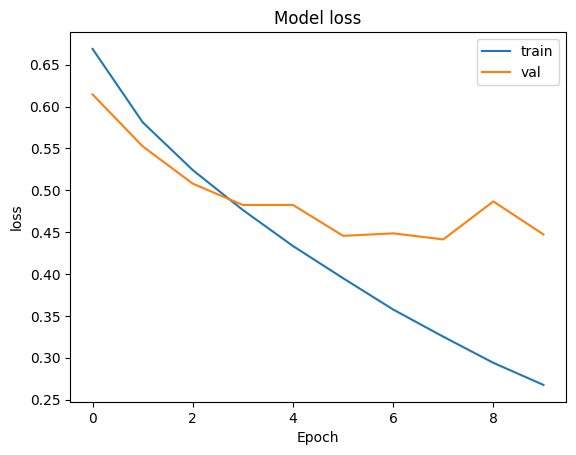

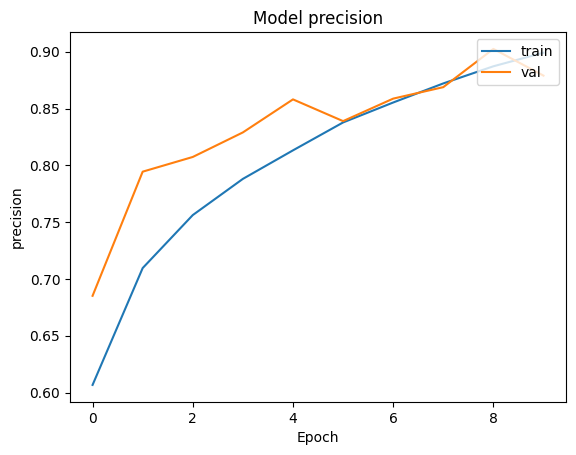

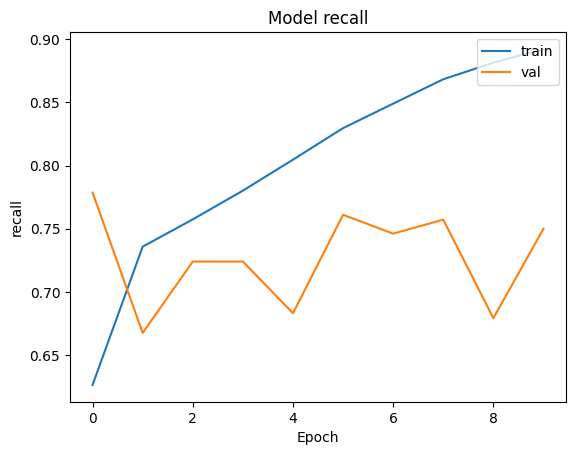

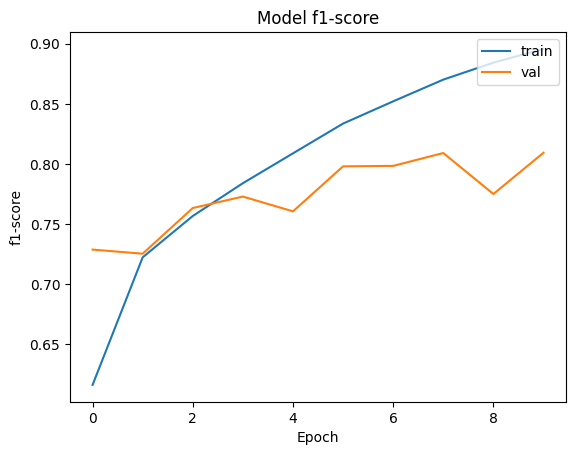

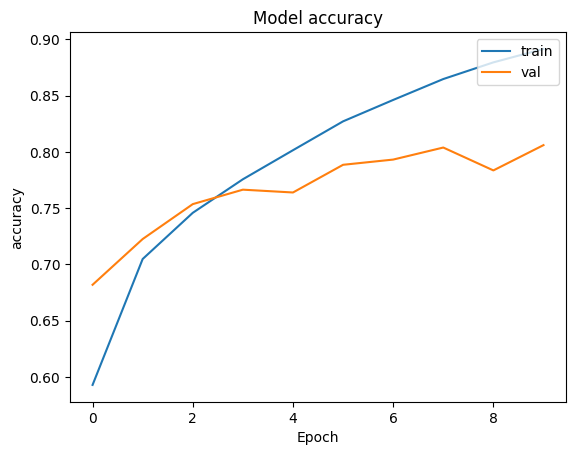

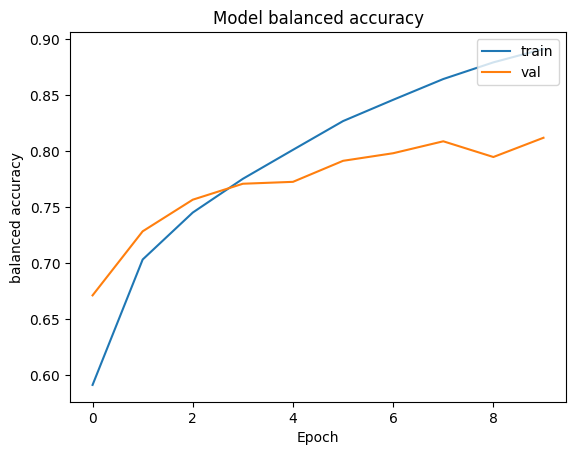

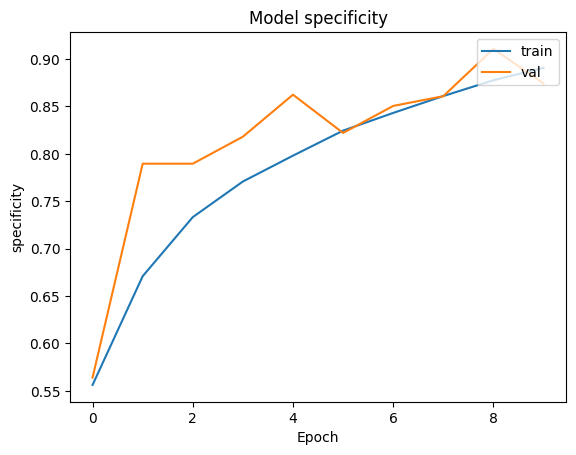

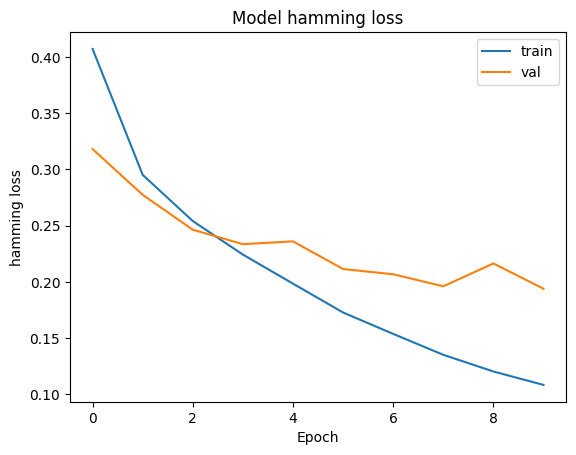

In [13]:
trainer.run()

In [14]:
tester = Tester_level_1(model = model_level_1, weights_file = level_1_model_file, level =1,  data_loader = test_dataloader, checkpoint_dir = level_1_checkpoint_dir)

weights are loaded


In [15]:
tester.prediction()

started prediction
2024-06-12 16:19:32.420208


  0%|                                                 | 0/88 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|████████████████████████████| 88/88 [00:58<00:00,  1.50batch/s, loss=0.381]

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
LOSS test 0.4666864573955536, test_precision 0.8540255831452219, test_recall 0.7346278317152104, test_f1 0.7898399443284622, test_accuracy 0.7849768600925596, test_BA 0.7905734095284913, test_specificity 0.8465189873417721, test_hamming_loss 0.21502313990744037


In [16]:
no_epoch = 50
lr = 0.001
optimizer = 'AdamW'
# Define the base checkpoint directory
level_2_checkpoint_dir = './checkpoints/' + used_model + '/level_2_'

# Create directories for fiction and non-fiction checkpoints
fiction_checkpoint_dir = os.path.join(level_2_checkpoint_dir, 'fiction')
non_fiction_checkpoint_dir = os.path.join(level_2_checkpoint_dir, 'non_fiction')

# Ensure directories exist (avoid errors if not created beforehand)
os.makedirs(fiction_checkpoint_dir, exist_ok=True)
os.makedirs(non_fiction_checkpoint_dir, exist_ok=True)

fiction_gamma_pos = 4
fiction_gamma_neg = 5
non_fiction_gamma_pos = 4
non_fiction_gamma_neg = 5

In [17]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

<All keys matched successfully>

In [18]:
def freeze_used_model(model):
    
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())[:-2]
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_level_1_model(model):
    
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())[:-1]
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_full_model(model):
    
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

In [19]:
used_model = freeze_used_model(copy.deepcopy(model_level_1))

<bound method Module.modules of level_1_model(
  (pre_model): EfficientNetB3Features(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activa

In [20]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

FE_model_level_1 = freeze_level_1_model(copy.deepcopy(model_level_1))

<bound method Module.modules of level_1_model(
  (pre_model): EfficientNetB3Features(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activa

In [21]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

model_level_1 = freeze_full_model(copy.deepcopy(model_level_1))

<bound method Module.modules of level_1_model(
  (pre_model): EfficientNetB3Features(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activa

In [22]:
torchinfo.summary(used_model, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

In [23]:
torchinfo.summary(FE_model_level_1, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 64]                   --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 64]                   --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

In [24]:
torchinfo.summary(model_level_1, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─EfficientNetB3Features: 1-1                                [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
│    └─Sequential: 2-1                                       [1, 3, 224, 224]          [1, 1536, 7, 7]           --                        --                        --
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 224, 224]          [1, 40, 112, 112]         (1,160)                   --                        13,547,600
│    │    └─Sequential: 3-2                                  [1, 40, 112, 112]         [1, 24, 112, 112]         (3,504)                   --    

In [25]:
# Level 2 classifier
fiction_classifier = level_2_classifier(model_feature_size=used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class=29)
fiction_model = level_2_post_model(level_2_classifier=fiction_classifier, level_2_output_layer=fiction_op_layer)

In [26]:
non_fiction_classifier = level_2_classifier(model_feature_size=used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
non_fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class=29)
non_fiction_model = level_2_post_model(level_2_classifier=non_fiction_classifier, level_2_output_layer=non_fiction_op_layer)

In [27]:
level_2_pre_model = level_2_pre_model_concate(used_model, FE_model_level_1)

In [28]:
level_2_pre_model

level_2_pre_model_concate(
  (used_model): Sequential(
    (0): EfficientNetB3Features(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
                (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(10, 40, kernel_size=(1, 1)

In [29]:
level_2_trainer = Trainer_level_2(
    level_1_model=model_level_1,
    level_2_pre_model=level_2_pre_model,
    fiction_model=fiction_model,
    non_fiction_model=non_fiction_model,
    training_dataloader=train_dataloader,
    validation_dataloader=val_dataloader,
    epoch=no_epoch,
    learning_rate=lr,
    use_gpu=True,
    opt_method=optimizer,
    fiction_checkpoint_dir=fiction_checkpoint_dir,
    non_fiction_checkpoint_dir=non_fiction_checkpoint_dir,
    checkpoint_filename=level_1_model_file,
    fiction_gamma_pos=fiction_gamma_pos,
    fiction_gamma_neg=fiction_gamma_neg,
    non_fiction_gamma_pos=non_fiction_gamma_pos,
    non_fiction_gamma_neg=non_fiction_gamma_neg,
    csv_logger=level_1_csvlogger_file,
)

Finish initializing...
Create data for level 2


  0%|                                                 | 0/88 [00:00<?, ?batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.3309,  0.3138,  0.2453,  ..., -0.2171, -0.3027, -0.1486],
          [ 0.4508,  0.6906,  0.5022,  ..., -0.1999, -0.2171, -0.1657],
          [ 0.3309,  0.5022,  0.3994,  ..., -0.0116, -0.0116,  0.0741],
          ...,
          [ 0.2111,  0.4166,  0.6221,  ...,  0.3994,  0.3652,  0.4337],
          [ 0.1597,  0.4508,  0.5536,  ...,  0.6392,  0.5193,  0.4337],
          [ 0.1939,  0.2796,  0.2624,  ...,  0.5536,  0.4851,  0.3823]],

         [[ 0.8529,  0.8354,  0.7654,  ...,  0.3627,  0.3102,  0.4678],
          [ 0.9755,  1.2206,  1.0280,  ...,  0.3803,  0.3978,  0.4503],
          [ 0.8529,  1.0280,  0.9230,  ...,  0.5728,  0.5903,  0.6779],
          ...,
          [ 0.5553,  0.7654,  0.9755,  ...,  1.1155,  1.0630,  1.1331],
          [ 0.5203,  0.8179,  0.9055,  ...,  1.3431,  1.2206,  1.1331],
          [ 0.5553,  0.6429,  0.6254,  ...,  1.2381,  1.1681,  1.0805]],

         [[-0.0441, -0.0615, -0.1312,  ..., -0.7064, -0.8110, -0.6541],


  1%|▍                                        | 1/88 [00:00<00:59,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3369, -0.3027, -0.3027,  ..., -0.5082, -0.5253, -0.5253],
          [-0.5253, -0.5596, -0.6281,  ..., -0.6281, -0.6623, -0.6452],
          [-0.5767, -0.5938, -0.5938,  ..., -0.5767, -0.5596, -0.5767],
          ...,
          [-0.7822, -0.7137, -0.7479,  ..., -0.5596, -0.6109, -0.5767],
          [-0.8335, -0.6794, -0.6452,  ..., -0.7137, -0.5938, -0.4226],
          [-0.7479, -0.7137, -0.7137,  ..., -0.8678, -0.7137, -0.5938]],

         [[-0.5651, -0.5301, -0.5301,  ..., -0.6877, -0.6702, -0.6527],
          [-0.8452, -0.8803, -0.9153,  ..., -1.0903, -1.1253, -1.1078],
          [-1.0028, -1.0203, -1.0203,  ..., -1.0903, -1.1078, -1.1604],
          ...,
          [-1.1078, -1.0553, -1.1078,  ..., -1.0203, -1.0553, -1.0203],
          [-1.2129, -1.0728, -1.0553,  ..., -1.1604, -1.0028, -0.8277],
          [-1.1429, -1.1429, -1.1604,  ..., -1.3004, -1.1253, -0.9853]],

         [[-0.4973, -0.4450, -0.4275,  ..., -0.6715, -0.6715, -0.6541],


  2%|▉                                        | 2/88 [00:01<00:58,  1.48batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0458, -0.0458, -0.0458,  ..., -0.0801, -0.0116,  0.1254],
          [-0.2171, -0.2171, -0.2171,  ..., -0.1657, -0.1486, -0.0629],
          [-0.2513, -0.2684, -0.2513,  ..., -0.1828, -0.2171, -0.1657],
          ...,
          [-0.5596, -0.4397, -0.4739,  ..., -0.4397, -0.5938, -0.4911],
          [-0.0287, -0.1314, -0.1828,  ..., -0.4054, -0.5253, -0.4226],
          [ 0.2111,  0.3481,  0.2453,  ..., -0.5767, -0.5596, -0.3027]],

         [[ 2.1310,  2.1310,  2.1310,  ...,  1.8333,  1.8158,  1.9034],
          [ 1.9909,  1.9909,  1.9909,  ...,  1.7283,  1.6758,  1.7458],
          [ 1.9734,  1.9909,  1.9734,  ...,  1.7108,  1.6408,  1.6583],
          ...,
          [ 0.9405,  1.1331,  1.2206,  ...,  1.1681,  0.9755,  1.0280],
          [ 1.1856,  1.1506,  1.2031,  ...,  0.9755,  0.8179,  0.9230],
          [ 1.2206,  1.4307,  1.4307,  ...,  0.6254,  0.6604,  0.9055]],

         [[ 2.4657,  2.4657,  2.4657,  ...,  2.2217,  2.2217,  2.3263],


  3%|█▍                                       | 3/88 [00:01<00:56,  1.51batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
          ...,
          [-1.3815, -1.3302, -1.2445,  ..., -1.4329, -1.5357, -1.5870],
          [-1.5357, -1.4843, -1.3987,  ..., -1.5870, -1.5699, -1.5528],
          [-1.7240, -1.7754, -1.7925,  ..., -1.7754, -1.7240, -1.6898]],

         [[-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          ...,
          [-1.5630, -1.5105, -1.4230,  ..., -1.5630, -1.6331, -1.7031],
          [-1.6856, -1.6331, -1.5280,  ..., -1.6856, -1.6506, -1.6506],
          [-1.8256, -1.8431, -1.8606,  ..., -1.8431, -1.7906, -1.7556]],

         [[-1.7173, -1.7173, -1.7173,  ..., -1.7173, -1.7173, -1.7173],


  5%|█▊                                       | 4/88 [00:02<00:54,  1.54batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3027, -0.3027, -0.2856,  ...,  0.2967,  0.4508,  0.5707],
          [-0.4226, -0.4226, -0.4054,  ...,  0.4166,  0.5536,  0.6563],
          [-0.4911, -0.4739, -0.4739,  ...,  0.6049,  0.7248,  0.7933],
          ...,
          [-1.1418, -1.0904, -1.0733,  ..., -0.6623, -0.8335, -0.9192],
          [-1.2103, -1.1760, -1.1589,  ..., -0.5767, -0.6623, -0.7308],
          [-1.2274, -1.2103, -1.2274,  ..., -0.8164, -0.7822, -0.7993]],

         [[ 2.0609,  2.0784,  2.0784,  ...,  1.7808,  1.7283,  1.7633],
          [ 1.9734,  1.9909,  1.9909,  ...,  1.7983,  1.7633,  1.7633],
          [ 1.9909,  1.9909,  2.0084,  ...,  1.8683,  1.8158,  1.7808],
          ...,
          [-0.3025, -0.2500, -0.2500,  ..., -0.1450, -0.3200, -0.4251],
          [-0.3375, -0.3025, -0.3025,  ..., -0.0399, -0.1450, -0.2150],
          [-0.3550, -0.3375, -0.3550,  ..., -0.3025, -0.2675, -0.2850]],

         [[ 2.4657,  2.4657,  2.4831,  ...,  2.3611,  2.3786,  2.3960],


  6%|██▎                                      | 5/88 [00:03<00:53,  1.55batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1119,  2.0948,  2.1633,  ..., -1.6384, -1.6384, -1.6384],
          [ 2.1975,  2.1975,  2.1975,  ..., -1.3987, -1.3987, -1.4500],
          [ 2.2318,  2.1975,  2.1462,  ..., -1.3473, -1.3302, -1.3815],
          ...,
          [ 2.1119,  2.1462,  2.1462,  ..., -1.3644, -1.3130, -1.3302],
          [ 2.1462,  2.1975,  2.1633,  ..., -1.3473, -1.3302, -1.3302],
          [ 2.1804,  2.1633,  2.1462,  ..., -1.3302, -1.3302, -1.3302]],

         [[ 1.2381,  1.2031,  1.2906,  ..., -1.3880, -1.3880, -1.4230],
          [ 1.3782,  1.3606,  1.3606,  ..., -1.0903, -1.0903, -1.1429],
          [ 1.4307,  1.3606,  1.3256,  ..., -1.0028, -1.0028, -1.0378],
          ...,
          [ 1.5007,  1.5357,  1.5532,  ..., -0.9503, -0.9328, -0.9678],
          [ 1.5532,  1.6232,  1.6057,  ..., -0.9678, -0.9503, -0.9503],
          [ 1.6232,  1.6408,  1.5882,  ..., -0.9503, -0.9503, -0.9503]],

         [[ 0.3568,  0.2871,  0.3393,  ..., -0.6193, -0.6018, -0.5844],


  7%|██▊                                      | 6/88 [00:03<00:54,  1.51batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9749,  2.0092,  2.0434,  ...,  2.0605,  2.0434,  2.0434],
          [ 1.9749,  2.0092,  2.0434,  ...,  2.0605,  2.0434,  2.0263],
          [ 1.9749,  2.0092,  2.0434,  ...,  2.0605,  2.0434,  2.0434],
          ...,
          [-1.3130, -0.8849, -0.7137,  ..., -0.0287,  0.1254,  0.0569],
          [-0.7479, -0.4739, -0.7479,  ..., -0.0116, -0.0629,  0.0912],
          [-0.8678, -0.7993, -0.8678,  ...,  0.0398, -0.0629,  0.1254]],

         [[ 2.1660,  2.2010,  2.2535,  ...,  2.2885,  2.2535,  2.2535],
          [ 2.1660,  2.2010,  2.2535,  ...,  2.2885,  2.2535,  2.2360],
          [ 2.1660,  2.2010,  2.2535,  ...,  2.2885,  2.2535,  2.2360],
          ...,
          [-0.9678, -0.2675,  0.3803,  ..., -1.0203, -0.9503, -1.0553],
          [ 0.0301,  0.5203,  0.4678,  ..., -0.9678, -1.1078, -0.9853],
          [ 0.2752,  0.5028,  0.4153,  ..., -0.8803, -1.0728, -0.9153]],

         [[ 2.2914,  2.3263,  2.3786,  ...,  2.3437,  2.3611,  2.3786],


  8%|███▎                                     | 7/88 [00:04<00:55,  1.46batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.0605,  2.0605,  2.0605],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.0605,  2.0605,  2.0605],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.0605,  2.0605,  2.0605],
          ...,
          [ 2.0434,  2.0434,  2.0434,  ...,  2.0948,  2.0948,  2.0948],
          [ 1.9749,  1.9749,  1.9920,  ...,  2.0777,  2.0605,  2.0605],
          [ 1.8550,  1.8550,  1.8722,  ...,  1.9578,  1.9407,  1.9407]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.2710,  2.2710,  2.2710],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.2710,  2.2710,  2.2710],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.2710,  2.2710,  2.2710],
          ...,
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3060,  2.3060,  2.3060],
          [ 2.2535,  2.2535,  2.2710,  ...,  2.2885,  2.2710,  2.2710],
          [ 2.1310,  2.1310,  2.1485,  ...,  2.1660,  2.1485,  2.1485]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.4657,  2.4657,  2.4657],


  9%|███▋                                     | 8/88 [00:05<00:58,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1008, -2.1008, -2.1008,  ..., -1.9124, -1.8610, -1.8268],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9124, -1.8610, -1.8268],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9124, -1.8610, -1.8268],
          ...,
          [-0.4226, -0.3541, -0.3198,  ..., -1.8097, -1.7583, -1.7412],
          [-0.2856, -0.2342, -0.2513,  ..., -1.7925, -1.7583, -1.7412],
          [-0.1314, -0.2171, -0.4397,  ..., -1.6727, -1.6384, -1.6213]],

         [[-2.0357, -2.0357, -2.0357,  ..., -1.8782, -1.8431, -1.8256],
          [-2.0357, -2.0357, -2.0357,  ..., -1.8782, -1.8431, -1.8256],
          [-2.0357, -2.0182, -2.0357,  ..., -1.8782, -1.8431, -1.8256],
          ...,
          [-0.1450, -0.0749, -0.0399,  ..., -1.6856, -1.6331, -1.6155],
          [-0.0224,  0.0301,  0.0126,  ..., -1.6856, -1.6506, -1.6331],
          [ 0.1352,  0.0476, -0.1800,  ..., -1.5630, -1.5280, -1.5105]],

         [[-1.6999, -1.6999, -1.6999,  ..., -1.7696, -1.7173, -1.6999],


 10%|████▏                                    | 9/88 [00:06<00:58,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7754, -1.6384, -1.6555,  ..., -1.4158, -1.2788, -1.1247],
          [-1.6213, -1.6727, -1.7412,  ..., -1.3644, -1.2274, -1.0562],
          [-1.7412, -1.7925, -1.6727,  ..., -1.2617, -1.1760, -1.0562],
          ...,
          [-1.0219, -1.1247, -1.1760,  ..., -0.6281, -0.5596, -0.5596],
          [-0.8164, -0.9705, -1.0219,  ..., -0.4911, -0.4226, -0.4568],
          [-0.7993, -1.0219, -1.0562,  ..., -0.5596, -0.4911, -0.5253]],

         [[-1.5805, -1.4405, -1.4580,  ..., -1.0553, -0.9153, -0.7577],
          [-1.4230, -1.4755, -1.5455,  ..., -1.0028, -0.8627, -0.6877],
          [-1.5455, -1.5980, -1.4755,  ..., -0.8978, -0.8102, -0.6877],
          ...,
          [-1.1078, -1.2129, -1.2479,  ..., -0.2675, -0.1975, -0.1975],
          [-0.8452, -0.9678, -1.0203,  ..., -0.1275, -0.0574, -0.0924],
          [-0.7752, -1.0028, -1.0378,  ..., -0.1975, -0.1275, -0.1625]],

         [[-1.1421, -1.0027, -1.0201,  ..., -0.7064, -0.5670, -0.4101],


 11%|████▌                                   | 10/88 [00:06<00:55,  1.40batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.2111,  0.3138,  0.7762,  ...,  0.2967,  0.2967,  0.1426],
          [ 0.0741,  0.6563,  0.7419,  ...,  1.3755,  1.4269,  1.4098],
          [ 0.2624,  0.7591,  0.8104,  ...,  1.9235,  1.9920,  1.8893],
          ...,
          [ 0.0569,  0.3481,  0.8447,  ...,  0.9474,  0.6049,  0.4679],
          [ 0.8961,  1.1529,  1.2899,  ...,  0.7762,  0.4508,  0.4337],
          [ 1.2043,  1.2899,  1.2728,  ...,  0.5364,  0.3309,  0.5536]],

         [[-0.1450, -0.1099,  0.1877,  ..., -0.0224,  0.0476, -0.0574],
          [-0.4076,  0.0126, -0.0049,  ...,  0.8354,  0.9580,  1.0105],
          [-0.5826, -0.2150, -0.2675,  ...,  1.1155,  1.2906,  1.2556],
          ...,
          [-0.9328, -0.9328, -0.7927,  ...,  0.5028,  0.2227,  0.1352],
          [-0.9328, -1.0028, -1.1078,  ...,  0.3803,  0.0826,  0.0826],
          [-1.1954, -1.2304, -1.3179,  ...,  0.1527, -0.0224,  0.1527]],

         [[-0.4275, -0.3927, -0.0964,  ..., -0.1487, -0.0964, -0.2184],


 12%|█████                                   | 11/88 [00:07<00:56,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.8104,  0.6906,  0.8447,  ...,  1.1358,  0.9132,  0.7591],
          [ 0.9474,  1.0673,  1.2557,  ...,  0.7762,  0.8276,  0.7762],
          [ 0.9817,  1.2043,  1.4269,  ...,  1.1015,  0.8276,  0.9646],
          ...,
          [ 0.7248,  0.3994,  0.6563,  ...,  1.0331,  0.0741,  0.3994],
          [ 0.5022,  0.4679,  0.9303,  ...,  0.5022,  0.0227,  0.8789],
          [ 0.2624,  0.2282,  0.3138,  ...,  0.7077,  0.4679,  0.8104]],

         [[ 1.0280,  0.9405,  1.1331,  ...,  1.2906,  1.0630,  0.9055],
          [ 1.2031,  1.3431,  1.5532,  ...,  0.9405,  0.9930,  0.9580],
          [ 1.2906,  1.5007,  1.7108,  ...,  1.2906,  1.0105,  1.1506],
          ...,
          [ 1.2206,  0.8880,  1.1155,  ...,  1.3606,  0.3627,  0.6604],
          [ 0.9930,  0.9405,  1.3957,  ...,  0.8004,  0.2927,  1.1506],
          [ 0.7654,  0.7129,  0.7654,  ...,  0.9930,  0.7479,  1.0805]],

         [[ 0.8797,  0.7751,  0.9494,  ...,  1.0365,  0.8274,  0.6705],


 14%|█████▍                                  | 12/88 [00:08<00:53,  1.43batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.8961,  0.9817,  1.0502,  ...,  0.1083,  0.0227, -0.0458],
          [ 0.7762,  0.8618,  0.9303,  ...,  0.0398,  0.0056, -0.1143],
          [ 0.6563,  0.7419,  0.8618,  ...,  0.0398,  0.0227,  0.0056],
          ...,
          [ 0.0056,  0.0569,  0.1597,  ...,  0.1254,  0.1254,  0.0741],
          [ 0.0227, -0.0801, -0.0972,  ...,  0.1254,  0.1426,  0.1083],
          [ 0.3481,  0.2967,  0.1939,  ...,  0.1083,  0.1768,  0.1426]],

         [[ 1.2206,  1.3081,  1.3606,  ...,  0.9755,  0.8354,  0.7654],
          [ 1.0980,  1.1856,  1.2381,  ...,  0.9055,  0.8354,  0.6779],
          [ 0.9755,  1.0630,  1.1681,  ...,  0.8880,  0.8004,  0.7654],
          ...,
          [ 0.3277,  0.3803,  0.5203,  ...,  0.7304,  0.7304,  0.6954],
          [ 0.3452,  0.2402,  0.2577,  ...,  0.7304,  0.7479,  0.7129],
          [ 0.6779,  0.6429,  0.5553,  ...,  0.7129,  0.7654,  0.7129]],

         [[ 1.5942,  1.6640,  1.6988,  ...,  1.4374,  1.3502,  1.2805],


 15%|█████▉                                  | 13/88 [00:09<00:52,  1.43batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 16%|██████▎                                 | 14/88 [00:09<00:50,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.9980, -1.8953, -2.0494,  ..., -2.0665, -2.0837, -2.1008],
          [-1.9124, -1.7754, -2.0152,  ..., -2.0837, -2.0665, -2.0837],
          [-2.0152, -1.9638, -2.0152,  ..., -2.0837, -2.1008, -2.1179],
          ...,
          [ 2.2318,  2.2318,  2.2318,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2318,  2.2318,  2.2318,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2318,  2.2318,  2.2318,  ...,  2.2489,  2.2489,  2.2489]],

         [[-1.7206, -1.6681, -1.8957,  ..., -1.9657, -1.9832, -2.0182],
          [-1.6681, -1.5630, -1.8606,  ..., -1.9832, -1.9657, -1.9832],
          [-1.7906, -1.7381, -1.8256,  ..., -1.9832, -2.0007, -2.0182],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[-1.4210, -1.3339, -1.5604,  ..., -1.6476, -1.6650, -1.6650],


 17%|██████▊                                 | 15/88 [00:10<00:50,  1.44batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1975,  2.2147,  2.1975,  ..., -1.1075, -0.9363, -0.7993],
          [ 2.1975,  2.1975,  2.2147,  ..., -1.3473, -1.1932, -1.0562],
          [ 2.1804,  2.1975,  2.2147,  ..., -1.4672, -1.3473, -1.2445],
          ...,
          [-1.3130, -1.2788, -1.3302,  ..., -1.2445, -1.1760, -1.0904],
          [-1.2274, -1.2445, -1.2445,  ..., -0.9877, -1.0219, -1.0733],
          [-1.2445, -1.3302, -1.2617,  ..., -1.0904, -1.0733, -1.0904]],

         [[ 0.8880,  0.8880,  0.8880,  ..., -1.1253, -0.9503, -0.7927],
          [ 0.8880,  0.9055,  0.9055,  ..., -1.3704, -1.2129, -1.0553],
          [ 0.8880,  0.9055,  0.9055,  ..., -1.5105, -1.3704, -1.2829],
          ...,
          [-1.1429, -1.1078, -1.1604,  ..., -0.9328, -0.8627, -0.7927],
          [-1.0203, -1.0203, -1.0553,  ..., -0.6877, -0.7227, -0.7752],
          [-0.9853, -1.0728, -0.9853,  ..., -0.7927, -0.7752, -0.7927]],

         [[-0.4450, -0.3753, -0.2881,  ..., -1.1770, -1.0724, -0.9853],


 18%|███████▎                                | 16/88 [00:11<00:49,  1.44batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -1.4500, -1.4843, -1.5185],
          [-2.1179, -2.1179, -2.1179,  ...,  1.3413,  1.3070,  1.2557],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0182, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -1.3529, -1.3880, -1.4055],
          [-2.0357, -2.0357, -2.0357,  ...,  1.4657,  1.4482,  1.4307],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.7870, -1.7696, -1.7696],


 19%|███████▋                                | 17/88 [00:11<00:49,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.0665, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.0665, -2.1008, -2.1008,  ..., -2.0323, -2.0494, -2.0494],
          [-2.0665, -2.1008, -2.1008,  ..., -1.8953, -1.9124, -1.8953],
          ...,
          [-2.0152, -2.0323, -2.0152,  ..., -2.1008, -2.1179, -2.1179],
          [-2.0837, -2.0837, -2.0837,  ..., -2.1008, -2.1179, -2.1179],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -1.8081, -1.8256, -1.8431],
          [-2.0357, -2.0357, -2.0357,  ..., -1.1779, -1.1954, -1.1779],
          ...,
          [-1.4055, -1.4230, -1.4055,  ..., -2.0357, -2.0357, -2.0357],
          [-1.9132, -1.8957, -1.8782,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.7347,  ..., -1.7173, -1.7347, -1.7347],


 20%|████████▏                               | 18/88 [00:12<00:48,  1.44batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.6324,  1.7865,  2.0263,  ...,  1.9749,  1.9749,  2.2489],
          [ 1.8037,  1.9920,  2.0948,  ...,  1.9749,  1.9920,  2.2318],
          [ 1.9064,  2.1462,  2.1804,  ...,  1.9920,  2.0777,  2.2147],
          ...,
          [ 2.1804,  1.9920,  1.7009,  ..., -1.4158, -1.1418, -1.0219],
          [ 2.1119,  2.2147,  1.9064,  ..., -1.4500, -1.1589, -1.1075],
          [ 2.1975,  2.1804,  2.1290,  ..., -1.6555, -1.4158, -1.3644]],

         [[ 1.3431,  1.5882,  1.8158,  ...,  2.2185,  2.1485,  2.3235],
          [ 1.4482,  1.7283,  1.8508,  ...,  2.1660,  2.1310,  2.2710],
          [ 1.5182,  1.7983,  1.9034,  ...,  2.1485,  2.1660,  2.2360],
          ...,
          [ 2.2710,  1.6758,  0.5203,  ...,  0.2402,  0.6429,  0.6779],
          [ 2.3761,  2.3060,  1.8859,  ...,  0.2227,  0.6604,  0.6954],
          [ 2.3235,  2.3410,  2.2710,  ...,  0.1877,  0.5903,  0.6254]],

         [[-0.0441,  0.2173,  0.3219,  ...,  0.6879,  0.6008,  0.7925],


 22%|████████▋                               | 19/88 [00:13<00:46,  1.48batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.5528, -1.4843, -1.5528,  ..., -1.2788, -1.7754, -1.8439],
          [-1.7069, -1.6727, -1.8097,  ..., -1.3473, -1.7583, -1.8439],
          [-1.6213, -1.7240, -1.8610,  ..., -1.3644, -1.8439, -1.8782],
          ...,
          [-1.9809, -1.9295, -1.9980,  ..., -1.2445, -1.9980, -2.0494],
          [-2.0152, -2.0494, -2.0665,  ..., -1.9467, -2.0665, -2.0837],
          [-2.0152, -2.0665, -2.0837,  ..., -2.0323, -2.0152, -2.0665]],

         [[-1.1604, -0.9153, -0.8452,  ..., -1.0553, -1.8957, -1.9657],
          [-1.1954, -1.0028, -1.0028,  ..., -1.1253, -1.8782, -1.9657],
          [-1.0903, -1.0378, -1.0378,  ..., -1.1429, -1.9482, -2.0007],
          ...,
          [-1.8606, -1.7731, -1.8431,  ..., -1.3704, -2.0182, -2.0182],
          [-1.9657, -1.9832, -2.0007,  ..., -1.9132, -2.0007, -2.0182],
          [-1.9657, -2.0182, -2.0357,  ..., -2.0182, -2.0182, -2.0182]],

         [[-0.7936, -0.4101, -0.2358,  ..., -0.7064, -1.6476, -1.6999],


 23%|█████████                               | 20/88 [00:13<00:45,  1.50batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.4612,  1.4440,  1.4269,  ...,  1.2214,  1.2385,  1.1529],
          [ 1.4098,  1.4269,  1.4440,  ...,  1.2043,  1.2214,  1.1872],
          [ 1.3413,  1.3755,  1.3755,  ...,  1.2043,  1.1529,  0.6392],
          ...,
          [-0.9020, -0.9534, -0.9705,  ..., -1.1418, -1.0904, -1.0562],
          [-0.7822, -0.9363, -1.1075,  ..., -1.0219, -1.1589, -1.1418],
          [-0.9020, -0.9705, -0.8849,  ..., -1.0390, -1.0390, -1.1075]],

         [[ 1.6057,  1.5882,  1.5707,  ...,  1.2906,  1.3081,  1.2206],
          [ 1.5532,  1.5707,  1.5882,  ...,  1.2731,  1.2906,  1.2556],
          [ 1.4832,  1.5182,  1.5182,  ...,  1.2731,  1.2206,  0.6954],
          ...,
          [-0.9503, -1.0028, -1.0203,  ..., -1.1078, -1.0553, -1.0203],
          [-0.8277, -0.9853, -1.1604,  ..., -0.9853, -1.1253, -1.1078],
          [-0.9503, -1.0203, -0.9328,  ..., -1.0028, -1.0028, -1.0728]],

         [[ 1.9080,  1.8905,  1.8731,  ...,  1.6117,  1.6291,  1.5420],


 24%|█████████▌                              | 21/88 [00:14<00:46,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.1418, -1.1075, -0.9020,  ...,  1.2728,  0.8789,  0.2624],
          [-1.1075, -1.0733, -0.7993,  ...,  1.4783,  1.3070,  0.6221],
          [-1.0733, -1.0390, -0.7137,  ...,  1.5125,  1.4098,  0.8447],
          ...,
          [-0.6281, -0.6109, -0.3541,  ...,  0.2111,  0.1939,  0.1768],
          [-0.6623, -0.6452, -0.5938,  ..., -0.5596, -0.5938, -0.5767],
          [-0.6623, -0.6452, -0.6623,  ..., -0.9192, -0.9020, -0.8849]],

         [[-1.1429, -1.1253, -0.9678,  ...,  1.1155,  0.6954,  0.0826],
          [-1.1253, -1.1078, -0.8627,  ...,  1.3081,  1.1506,  0.4503],
          [-1.1253, -1.0903, -0.7927,  ...,  1.3256,  1.2206,  0.6604],
          ...,
          [-0.7402, -0.7227, -0.5126,  ...,  0.1527,  0.1702,  0.1702],
          [-0.7577, -0.7402, -0.7052,  ..., -0.5301, -0.5476, -0.5126],
          [-0.7227, -0.7052, -0.7227,  ..., -0.8277, -0.7927, -0.7752]],

         [[-0.9156, -0.9156, -0.7413,  ...,  1.2282,  0.8448,  0.2348],


 25%|██████████                              | 22/88 [00:15<00:45,  1.46batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.8439, -1.8610, -1.8782,  ..., -1.4329, -1.3987, -1.3815],
          [-1.8610, -1.8610, -1.8782,  ..., -1.4329, -1.3987, -1.3815],
          [-1.8610, -1.8782, -1.8953,  ..., -1.4672, -1.4329, -1.3815],
          ...,
          [-1.4329, -1.4500, -1.4672,  ..., -1.1760, -1.1589, -1.1418],
          [-1.4329, -1.4329, -1.4500,  ..., -1.1418, -1.1418, -1.1418],
          [-1.4158, -1.4158, -1.4329,  ..., -1.1760, -1.1247, -1.0904]],

         [[-1.7731, -1.7906, -1.8081,  ..., -1.2304, -1.1954, -1.1779],
          [-1.7906, -1.7906, -1.8081,  ..., -1.2304, -1.1954, -1.1779],
          [-1.7906, -1.8081, -1.8256,  ..., -1.2654, -1.2304, -1.1779],
          ...,
          [-1.2479, -1.2654, -1.2829,  ..., -1.0028, -0.9853, -0.9678],
          [-1.2479, -1.2479, -1.2654,  ..., -0.9678, -0.9678, -0.9678],
          [-1.2304, -1.2304, -1.2479,  ..., -1.0028, -0.9503, -0.9153]],

         [[-1.5779, -1.5953, -1.6127,  ..., -1.0376, -1.0027, -0.9853],


 26%|██████████▍                             | 23/88 [00:16<00:48,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2147,  2.2318,  2.2318,  ...,  1.9749,  1.9749,  1.9578],
          [ 2.2147,  2.2318,  2.2318,  ...,  1.9235,  1.9578,  1.9749],
          [ 2.2147,  2.2318,  2.2318,  ...,  1.9578,  1.9578,  1.9578],
          ...,
          [ 1.9578,  1.9064,  1.8379,  ...,  2.0777,  2.0948,  2.0434],
          [ 1.6667,  1.6324,  1.5810,  ...,  2.0434,  2.0605,  1.9920],
          [ 1.0673,  1.0673,  1.0331,  ...,  2.0434,  2.0092,  1.9235]],

         [[ 2.4111,  2.4111,  2.3936,  ...,  2.2185,  2.2185,  2.2010],
          [ 2.4111,  2.4111,  2.3936,  ...,  2.1660,  2.2010,  2.2185],
          [ 2.4111,  2.4111,  2.3936,  ...,  2.2010,  2.2010,  2.2010],
          ...,
          [ 2.4286,  2.4286,  2.4111,  ...,  2.3410,  2.3235,  2.2710],
          [ 2.3410,  2.3410,  2.3060,  ...,  2.3410,  2.3235,  2.2360],
          [ 1.8683,  1.8859,  1.8859,  ...,  2.3410,  2.2885,  2.1835]],

         [[ 2.6400,  2.6226,  2.5529,  ...,  2.5877,  2.5877,  2.5703],


 27%|██████████▉                             | 24/88 [00:16<00:47,  1.33batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.6452, -0.7650, -0.6452,  ..., -2.0323, -2.0494, -2.0665],
          [-0.7479, -0.9020, -0.5082,  ..., -2.0323, -2.0494, -2.0665],
          [-0.7479, -0.7308, -0.1486,  ..., -2.0323, -2.0152, -1.9980],
          ...,
          [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898],
          [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898],
          [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898]],

         [[-0.5126, -0.6176, -0.4776,  ..., -1.9307, -1.8957, -1.8957],
          [-0.5651, -0.7052, -0.2850,  ..., -1.9482, -1.9307, -1.9307],
          [-0.5301, -0.5126,  0.1001,  ..., -1.9482, -1.9307, -1.9132],
          ...,
          [-1.5980, -1.5980, -1.5980,  ..., -1.5980, -1.5980, -1.5980],
          [-1.5980, -1.5980, -1.5980,  ..., -1.5980, -1.5980, -1.5980],
          [-1.5980, -1.5980, -1.5980,  ..., -1.5980, -1.5980, -1.5980]],

         [[ 0.1302,  0.0082,  0.1476,  ..., -1.5081, -1.5604, -1.5779],


 28%|███████████▎                            | 25/88 [00:17<00:45,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.1700,  1.4269,  1.6495,  ...,  1.7694,  1.7694,  1.7523],
          [ 0.5878,  1.0331,  1.1187,  ...,  1.1872,  1.1872,  1.1700],
          [ 0.9132,  1.1529,  1.2385,  ...,  1.3755,  1.3584,  1.3242],
          ...,
          [ 0.7077,  1.1700,  1.3584,  ...,  0.8961,  0.9988,  0.9646],
          [ 0.6734,  1.0502,  1.0159,  ...,  0.9817,  1.2214,  1.3927],
          [ 0.8618,  0.9988,  1.2899,  ...,  1.4783,  1.6324,  1.6838]],

         [[ 1.3081,  1.5357,  1.7458,  ...,  1.6583,  1.6933,  1.6758],
          [ 0.5203,  0.9580,  0.9930,  ...,  0.6779,  0.7129,  0.6954],
          [ 0.7479,  0.9580,  1.0105,  ...,  0.6429,  0.6779,  0.6604],
          ...,
          [ 0.6954,  1.1506,  1.3606,  ...,  0.3627,  0.4853,  0.4328],
          [ 0.6604,  1.0280,  1.0280,  ...,  0.4678,  0.6954,  0.9055],
          [ 0.8529,  0.9930,  1.2906,  ...,  0.9580,  1.1506,  1.2031]],

         [[ 1.4548,  1.6640,  1.8383,  ...,  1.7337,  1.7163,  1.6465],


 30%|███████████▊                            | 26/88 [00:18<00:43,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.4440,  1.4440,  1.4954,  ...,  1.9920,  2.1804,  1.6838],
          [ 1.2728,  1.2728,  1.3413,  ...,  2.0777,  2.2147,  1.7865],
          [ 1.5125,  1.4440,  1.4269,  ...,  2.0948,  2.1633,  1.8037],
          ...,
          [ 1.3755,  1.3584,  1.4098,  ...,  2.0092,  2.0948,  1.4612],
          [ 1.1700,  1.2385,  1.3070,  ...,  2.0092,  2.1119,  1.4783],
          [ 1.1358,  1.1187,  1.1872,  ...,  1.9578,  2.1290,  1.4954]],

         [[ 1.4482,  1.4482,  1.4832,  ...,  1.9034,  2.1134,  1.6057],
          [ 1.2381,  1.2206,  1.3256,  ...,  2.0084,  2.1660,  1.7458],
          [ 1.4657,  1.3957,  1.3782,  ...,  2.0259,  2.1310,  1.7633],
          ...,
          [ 1.5007,  1.4307,  1.3782,  ...,  1.9209,  2.0084,  1.3606],
          [ 1.2206,  1.2556,  1.2556,  ...,  1.9034,  2.0259,  1.3782],
          [ 1.3431,  1.2556,  1.2206,  ...,  1.8683,  2.0609,  1.4132]],

         [[ 0.9842,  0.9842,  1.0714,  ...,  1.4897,  1.6814,  1.1759],


 31%|████████████▎                           | 27/88 [00:18<00:41,  1.46batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.1768,  0.2967,  0.2624,  ...,  0.5878,  0.5707,  0.2796],
          [ 0.1426,  0.3309,  0.3652,  ...,  0.7419,  0.7077,  0.3994],
          [ 0.1426,  0.2796,  0.2453,  ...,  0.6392,  0.6221,  0.3309],
          ...,
          [ 0.5364,  0.9988,  0.9132,  ...,  0.7762,  0.8447,  0.4851],
          [ 0.6049,  1.1529,  1.0673,  ...,  0.8276,  0.8276,  0.4851],
          [ 0.4337,  0.8447,  0.7762,  ...,  0.5878,  0.5707,  0.3309]],

         [[ 0.2227,  0.3452,  0.3102,  ...,  0.5378,  0.5203,  0.2227],
          [ 0.1877,  0.3803,  0.4153,  ...,  0.7129,  0.6604,  0.3452],
          [ 0.1877,  0.3277,  0.2927,  ...,  0.5903,  0.5728,  0.2752],
          ...,
          [ 0.5553,  1.0280,  0.9405,  ...,  0.7304,  0.8004,  0.4153],
          [ 0.6254,  1.1856,  1.0980,  ...,  0.8354,  0.8179,  0.4503],
          [ 0.4503,  0.8704,  0.8004,  ...,  0.5903,  0.5728,  0.3452]],

         [[ 0.3742,  0.4962,  0.4614,  ...,  0.6182,  0.6356,  0.3393],


 32%|████████████▋                           | 28/88 [00:19<00:41,  1.46batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1975,  2.2147,  2.2489,  ...,  1.7865,  1.7352,  1.6838],
          [ 2.1804,  2.1975,  2.2147,  ...,  1.8037,  1.7523,  1.7009],
          [ 2.1462,  2.1633,  2.1804,  ...,  1.8208,  1.7694,  1.7009],
          ...,
          [ 1.9407,  1.9235,  1.9064,  ...,  1.3755,  1.2899,  1.2214],
          [ 1.7694,  1.7352,  1.7180,  ...,  1.2899,  1.2214,  1.1529],
          [ 1.5639,  1.5639,  1.5297,  ...,  1.1015,  1.0502,  0.9988]],

         [[ 2.2185,  2.2360,  2.2360,  ...,  1.8508,  1.8158,  1.7808],
          [ 2.1835,  2.2010,  2.2185,  ...,  1.8333,  1.7983,  1.7458],
          [ 2.1835,  2.2010,  2.2360,  ...,  1.8158,  1.7808,  1.7458],
          ...,
          [ 2.0609,  2.0609,  2.0784,  ...,  0.5553,  0.4503,  0.3627],
          [ 1.9384,  1.9384,  1.9559,  ...,  0.5378,  0.4153,  0.3277],
          [ 1.8158,  1.8333,  1.8333,  ...,  0.3627,  0.2752,  0.2052]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.6356,  0.6705,  0.6705],


 33%|█████████████▏                          | 29/88 [00:20<00:40,  1.47batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1804,  2.1462,  2.1290,  ...,  1.4612,  1.4783,  1.4954],
          [ 2.1804,  2.1633,  2.1290,  ...,  1.5125,  1.5125,  1.5297],
          [ 2.1975,  2.1633,  2.1290,  ...,  1.5468,  1.5297,  1.5297],
          ...,
          [ 2.1290,  2.1290,  2.1290,  ...,  2.0434,  2.0434,  2.0263],
          [ 2.0777,  2.0777,  2.0777,  ...,  2.0434,  2.0434,  2.0434],
          [ 2.0434,  2.0434,  2.0434,  ...,  2.0092,  2.0092,  2.0092]],

         [[ 0.8354,  0.8004,  0.7829,  ...,  1.0630,  1.0980,  1.1506],
          [ 0.8354,  0.8179,  0.7829,  ...,  1.0980,  1.1331,  1.1681],
          [ 0.8529,  0.8179,  0.7829,  ...,  1.1155,  1.1506,  1.1506],
          ...,
          [ 2.3235,  2.3235,  2.3235,  ...,  2.2360,  2.2360,  2.2185],
          [ 2.2710,  2.2710,  2.2710,  ...,  2.2360,  2.2360,  2.2360],
          [ 2.2360,  2.2360,  2.2360,  ...,  2.2010,  2.2010,  2.2010]],

         [[ 1.1934,  1.1585,  1.1411,  ...,  1.2457,  1.2631,  1.2980],


 34%|█████████████▋                          | 30/88 [00:20<00:40,  1.43batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069],
          [-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069],
          [-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069],
          ...,
          [-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069],
          [-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069],
          [-1.7069, -1.7069, -1.7069,  ..., -1.7069, -1.7069, -1.7069]],

         [[-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          ...,
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731]],

         [[-1.5256, -1.5256, -1.5256,  ..., -1.5256, -1.5256, -1.5256],


 35%|██████████████                          | 31/88 [00:21<00:41,  1.36batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.2342, -0.2513, -0.3198,  ...,  0.1426,  0.4337,  0.5364],
          [ 0.6392, -0.1486, -0.3027,  ..., -0.3883,  0.1426,  0.6049],
          [ 0.1426,  0.0569,  0.1083,  ...,  0.7762,  0.2967,  0.1083],
          ...,
          [ 1.2557,  1.1872,  1.1187,  ...,  1.5639,  1.5468,  1.5639],
          [-0.1828, -0.1828, -0.1314,  ...,  0.2282,  0.1597,  0.1597],
          [ 1.0159,  0.9988,  1.0159,  ...,  0.9817,  0.8618,  0.8618]],

         [[-0.9678, -1.0028, -1.0553,  ..., -0.9678, -0.7752, -0.7577],
          [-0.1800, -0.9678, -1.1078,  ..., -1.3704, -0.9153, -0.4776],
          [-0.8277, -0.8803, -0.7927,  ..., -0.0924, -0.6176, -0.8452],
          ...,
          [ 0.8179,  0.7479,  0.6954,  ...,  0.9230,  0.9230,  0.9405],
          [-0.7577, -0.7402, -0.7052,  ..., -0.4426, -0.5126, -0.5126],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.3452,  0.2402,  0.2402]],

         [[-1.2990, -1.3687, -1.2990,  ..., -1.3339, -1.1944, -1.1944],


 36%|██████████████▌                         | 32/88 [00:22<00:42,  1.31batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.0948,  2.0434,  2.0263,  ...,  1.9407,  1.9920,  1.9749],
          [ 2.0777,  2.0605,  2.0092,  ...,  2.0434,  2.0434,  1.9407],
          [ 2.0605,  2.0948,  2.0263,  ...,  2.0948,  2.0777,  2.0092],
          ...,
          [ 1.6324,  1.4269,  1.7009,  ...,  1.9749,  1.9920,  1.7523],
          [ 1.9064,  1.5125,  1.5297,  ...,  1.9064,  1.9749,  1.4954],
          [ 2.1119,  1.9749,  1.6838,  ...,  1.8550,  1.5125,  0.7077]],

         [[ 1.0455,  0.1176, -0.8277,  ...,  0.2752,  0.7654,  0.0126],
          [ 0.7829,  0.1352, -0.4251,  ..., -0.4251,  0.7829, -0.0049],
          [ 0.2927,  0.4328, -0.0574,  ..., -1.0203, -0.4601,  0.2927],
          ...,
          [ 0.1702, -1.0203, -1.1779,  ..., -0.9678, -0.0049,  1.3431],
          [ 1.2731, -0.1625, -0.9328,  ..., -0.8803,  0.5728,  1.2556],
          [ 1.8333,  1.1856,  0.3452,  ...,  0.0651,  1.0455,  0.5728]],

         [[ 1.0017,  0.0256, -0.8633,  ...,  0.2522,  0.6356, -0.0615],


 38%|███████████████                         | 33/88 [00:23<00:41,  1.33batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.6906,  0.6906,  0.3138,  ...,  0.6221,  0.5878,  0.5878],
          [ 0.8961,  1.1872,  1.1358,  ...,  0.5878,  0.4851,  0.4337],
          [ 0.9132,  1.4098,  1.5639,  ...,  0.5536,  0.4337,  0.3481],
          ...,
          [-0.5082, -0.5082, -0.5253,  ..., -0.4739, -0.5082, -0.5767],
          [-0.3883, -0.4054, -0.4739,  ..., -0.4568, -0.4397, -0.4568],
          [ 0.1254,  0.0912, -0.0116,  ..., -0.4911, -0.4568, -0.4739]],

         [[ 1.0105,  1.0105,  0.6078,  ...,  1.2556,  1.2206,  1.2206],
          [ 1.2381,  1.5357,  1.4657,  ...,  1.2031,  1.1155,  1.0455],
          [ 1.2556,  1.7633,  1.9209,  ...,  1.1681,  1.0280,  0.9405],
          ...,
          [-0.3200, -0.3200, -0.3550,  ...,  0.0651,  0.0301, -0.0399],
          [-0.1975, -0.2150, -0.3025,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.3277,  0.2927,  0.1702,  ..., -0.0749, -0.0399, -0.0399]],

         [[ 1.4200,  1.4548,  1.0888,  ...,  1.8034,  1.8034,  1.8034],


 39%|███████████████▍                        | 34/88 [00:24<00:41,  1.29batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 40%|███████████████▉                        | 35/88 [00:24<00:39,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9749,  1.9749,  1.9749,  ...,  1.7694,  1.7523,  1.7523],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.7523,  1.7352,  1.7352],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.7352,  1.7009,  1.7180],
          ...,
          [ 1.3927,  1.3755,  1.3755,  ...,  1.8550,  1.8722,  1.8379],
          [ 1.2557,  1.2557,  1.2557,  ...,  1.7865,  1.8208,  1.8379],
          [ 1.0844,  1.1015,  1.1187,  ...,  1.6153,  1.6667,  1.7352]],

         [[ 0.3803,  0.3803,  0.3803,  ...,  0.4853,  0.5028,  0.5203],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.4853,  0.5028,  0.5378],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.5028,  0.5203,  0.5378],
          ...,
          [ 0.6604,  0.6604,  0.6604,  ...,  0.8179,  0.8529,  0.8179],
          [ 0.6604,  0.6604,  0.6779,  ...,  0.8354,  0.9055,  0.9230],
          [ 0.5378,  0.5553,  0.5728,  ...,  0.7479,  0.8179,  0.9055]],

         [[-1.7347, -1.7347, -1.7347,  ..., -1.7696, -1.7347, -1.7173],


 41%|████████████████▎                       | 36/88 [00:25<00:37,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.3927,  1.3927,  1.3927,  ...,  0.9646,  0.6906,  0.5364],
          [ 1.3927,  1.3927,  1.3927,  ...,  0.9817,  0.7591,  0.6734],
          [ 1.3927,  1.3927,  1.3927,  ...,  1.0673,  0.8447,  0.7419],
          ...,
          [ 2.0948,  2.0948,  2.0948,  ...,  1.6838,  1.4612,  1.3584],
          [ 2.0263,  2.0263,  2.0263,  ...,  1.6667,  1.4612,  1.3927],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.6667,  1.4954,  1.4440]],

         [[ 1.5357,  1.5357,  1.5357,  ...,  1.1331,  0.8529,  0.6954],
          [ 1.5357,  1.5357,  1.5357,  ...,  1.1506,  0.9405,  0.8354],
          [ 1.5357,  1.5357,  1.5357,  ...,  1.2206,  1.0105,  0.9230],
          ...,
          [ 2.2710,  2.2710,  2.2710,  ...,  1.8683,  1.6583,  1.5707],
          [ 2.2010,  2.2010,  2.2010,  ...,  1.8508,  1.6758,  1.6057],
          [ 2.1485,  2.1485,  2.1485,  ...,  1.8508,  1.7108,  1.6583]],

         [[ 1.4374,  1.4374,  1.4374,  ...,  1.2805,  1.0539,  0.9494],


 42%|████████████████▊                       | 37/88 [00:26<00:36,  1.40batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.5639,  1.5810,  1.6667,  ...,  0.9646,  1.7523,  1.4612],
          [ 1.5468,  1.5468,  1.6667,  ...,  0.9817,  1.7009,  1.2043],
          [ 1.5468,  1.6324,  1.6324,  ...,  0.9817,  1.7180,  0.9646],
          ...,
          [ 1.6153,  1.7180,  1.7523,  ...,  0.1426,  0.1768, -0.6109],
          [ 1.6153,  1.7009,  1.7009,  ...,  0.3309, -0.5596, -0.2171],
          [ 1.5639,  1.6495,  1.6324,  ..., -0.4054, -0.5596,  0.7077]],

         [[ 0.3452,  0.0826,  0.0476,  ...,  0.0126,  0.0651, -0.0049],
          [ 0.5028,  0.1176,  0.0126,  ...,  0.0826,  0.1001, -0.0924],
          [ 0.3277,  0.0476,  0.0651,  ...,  0.0301,  0.1001, -0.1800],
          ...,
          [-0.4951, -0.5301, -0.5476,  ...,  1.3431,  1.3782,  1.1155],
          [-0.4426, -0.4951, -0.5476,  ...,  1.4657,  1.1681,  1.2206],
          [-0.4426, -0.5826, -0.5826,  ...,  1.1155,  1.0980,  1.4307]],

         [[ 0.0256, -0.3753, -0.5495,  ..., -0.7064, -0.6541, -0.6890],


 43%|█████████████████▎                      | 38/88 [00:26<00:34,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.1760, -0.9705, -0.8849,  ..., -0.7479, -0.7993, -1.1418],
          [-1.1760, -0.9363, -0.8335,  ..., -0.7479, -0.7137, -1.0562],
          [-1.1589, -0.9020, -0.7993,  ..., -0.7650, -0.6965, -1.0733],
          ...,
          [ 2.1804,  2.2147,  2.2147,  ...,  1.8893,  1.8893,  1.8722],
          [ 2.1804,  2.2318,  2.2318,  ...,  2.0948,  2.0605,  2.1119],
          [ 2.1633,  2.1975,  2.2147,  ...,  2.1633,  2.0777,  2.0777]],

         [[-1.1429, -0.9328, -0.8452,  ..., -0.7227, -0.7577, -1.0728],
          [-1.1429, -0.8978, -0.7927,  ..., -0.7402, -0.6877, -1.0203],
          [-1.1253, -0.8627, -0.7577,  ..., -0.7752, -0.6877, -1.0378],
          ...,
          [-0.1275, -0.0749, -0.0399,  ..., -0.0399, -0.1450,  0.0301],
          [-0.1099, -0.0574, -0.0574,  ..., -0.1275, -0.1975,  0.1352],
          [-0.1099, -0.0574, -0.0399,  ..., -0.1450, -0.1625,  0.1527]],

         [[-0.8981, -0.6890, -0.6018,  ..., -0.4798, -0.5147, -0.8284],


 44%|█████████████████▋                      | 39/88 [00:27<00:34,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2147,  2.2147,  2.2147,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.1462,  2.1633,  2.1975,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.3585,  2.3585,  2.3761,  ...,  2.3761,  2.3761,  2.3761],
          [ 2.3761,  2.3761,  2.3761,  ...,  2.3761,  2.3761,  2.3761],
          [ 2.4111,  2.4111,  2.3936,  ...,  2.3761,  2.3761,  2.3761],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[-1.7870, -1.7870, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 45%|██████████████████▏                     | 40/88 [00:28<00:34,  1.39batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6898, -1.6384, -1.6384,  ..., -1.5185, -1.6384, -1.7240],
          [-1.6555, -1.5870, -1.6042,  ..., -1.6384, -1.6384, -1.6555],
          [-1.6555, -1.5528, -1.5870,  ..., -1.6555, -1.6384, -1.7069],
          ...,
          [-1.1418,  0.5022,  0.8276,  ...,  1.0331,  0.9646,  0.6392],
          [-1.1589,  0.6734,  0.7248,  ...,  1.0502,  0.8961,  0.5536],
          [-1.0733,  0.4166,  0.7077,  ...,  0.9988,  0.7077,  0.5536]],

         [[-1.6331, -1.5805, -1.5805,  ..., -1.4930, -1.6155, -1.6856],
          [-1.6155, -1.5630, -1.5805,  ..., -1.6331, -1.6155, -1.6331],
          [-1.6506, -1.5455, -1.5805,  ..., -1.6506, -1.6506, -1.6856],
          ...,
          [-1.3704, -0.1275,  0.0476,  ...,  0.0826,  0.1001, -0.1099],
          [-1.3704,  0.0476, -0.0924,  ...,  0.0826,  0.0476, -0.1800],
          [-1.3354, -0.1800, -0.0049,  ...,  0.0826, -0.0924, -0.0749]],

         [[-1.3861, -1.3339, -1.3339,  ..., -1.2467, -1.3687, -1.4384],


 47%|██████████████████▋                     | 41/88 [00:29<00:34,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.3198, -0.1999, -0.1486,  ..., -2.1179, -2.1179, -2.1179],
          [-0.5082, -0.4054, -0.3198,  ..., -2.1179, -2.1179, -2.1179],
          [-0.5938, -0.4397, -0.4054,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-0.2675, -0.1450, -0.0924,  ..., -2.0357, -2.0357, -2.0357],
          [-0.4426, -0.3550, -0.2675,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5126, -0.3550, -0.3200,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 48%|███████████████████                     | 42/88 [00:29<00:32,  1.41batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.8849, -0.8849, -0.2513,  ..., -1.7925, -1.9809, -2.0152],
          [-0.8507, -0.9020, -0.8678,  ..., -1.9980, -2.0152, -2.0494],
          [-0.8678, -0.8507, -0.9363,  ..., -2.0494, -2.0665, -2.1008],
          ...,
          [ 0.6392,  0.6563,  0.6734,  ...,  0.6049,  0.5707,  0.5364],
          [ 0.6049,  0.6734,  0.6906,  ...,  0.5878,  0.5022,  0.5022],
          [ 0.5707,  0.6392,  0.6563,  ...,  0.6049,  0.5022,  0.4679]],

         [[-0.4076, -0.4076,  0.2402,  ..., -1.8957, -2.0182, -2.0357],
          [-0.3725, -0.4251, -0.3901,  ..., -2.0357, -2.0357, -2.0357],
          [-0.3901, -0.3725, -0.4601,  ..., -2.0182, -2.0182, -2.0357],
          ...,
          [-0.9678, -0.9503, -0.9328,  ..., -1.2129, -1.1954, -1.1779],
          [-1.0028, -0.9153, -0.8978,  ..., -1.2304, -1.2479, -1.1954],
          [-1.0203, -0.9328, -0.9153,  ..., -1.2304, -1.2654, -1.2304]],

         [[ 0.2871,  0.2871,  0.9494,  ..., -1.6824, -1.8044, -1.8044],


 49%|███████████████████▌                    | 43/88 [00:30<00:31,  1.45batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.0092,  2.0092,  2.0092,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.0092,  2.0092,  2.0092,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.0092,  2.0092,  2.0092,  ...,  2.0092,  2.0092,  2.0092],
          ...,
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467]],

         [[-0.5301, -0.5301, -0.5301,  ..., -0.5301, -0.5301, -0.5301],
          [-0.5301, -0.5301, -0.5301,  ..., -0.5301, -0.5301, -0.5301],
          [-0.5301, -0.5301, -0.5301,  ..., -0.5301, -0.5301, -0.5301],
          ...,
          [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
          [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
          [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256]],

         [[-0.3404, -0.3404, -0.3404,  ..., -0.3404, -0.3404, -0.3404],


 50%|████████████████████                    | 44/88 [00:31<00:34,  1.29batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.1597,  0.2967,  0.3652,  ...,  0.9817,  1.0502,  1.1358],
          [-0.2171, -0.1999, -0.1486,  ...,  1.0673,  1.0844,  1.1015],
          [-0.5767, -0.4911, -0.3712,  ...,  1.1872,  1.1358,  1.1015],
          ...,
          [ 1.5982,  1.6153,  1.6153,  ...,  1.2214,  1.2385,  1.2385],
          [ 1.6667,  1.6667,  1.6667,  ...,  1.2899,  1.3070,  1.3070],
          [ 1.5468,  1.5810,  1.6324,  ...,  1.2899,  1.3070,  1.3242]],

         [[ 1.6583,  1.7983,  1.8683,  ...,  1.6057,  1.6583,  1.7283],
          [ 1.3081,  1.3081,  1.3606,  ...,  1.6758,  1.6583,  1.6758],
          [ 0.9580,  1.0805,  1.1681,  ...,  1.7983,  1.7108,  1.6583],
          ...,
          [ 2.3585,  2.3761,  2.3585,  ...,  1.9559,  1.9559,  1.9559],
          [ 2.3410,  2.3761,  2.3585,  ...,  1.9909,  2.0084,  2.0084],
          [ 2.1835,  2.2360,  2.2710,  ...,  1.9909,  2.0084,  2.0259]],

         [[ 0.9668,  1.1062,  1.1759,  ...,  1.1237,  1.1934,  1.2631],


 51%|████████████████████▍                   | 45/88 [00:32<00:32,  1.32batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3130, -1.3130, -1.3130,  ..., -1.2959, -1.2959, -1.2959],
          [-1.3130, -1.3130, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2788, -1.2959, -1.2788,  ..., -1.2959, -1.2959, -1.2959],
          ...,
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959]],

         [[-1.1954, -1.2129, -1.2129,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2129, -1.2129, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2129, -1.2129, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          ...,
          [-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          [-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          [-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954]],

         [[-0.9853, -0.9853, -0.9853,  ..., -0.9678, -0.9678, -0.9678],


 52%|████████████████████▉                   | 46/88 [00:32<00:31,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.1314, -0.0801, -0.0458],
          [-2.1179, -2.1179, -2.1179,  ..., -0.0972, -0.0629, -0.0287],
          [-2.1179, -2.1179, -2.1179,  ...,  0.0569,  0.1083,  0.1597]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.9055,  0.9755,  0.9930],
          [-2.0357, -2.0357, -2.0357,  ...,  0.8880,  0.9055,  0.9230],
          [-2.0357, -2.0357, -2.0357,  ...,  0.9230,  0.9580,  0.9930]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 53%|█████████████████████▎                  | 47/88 [00:33<00:30,  1.36batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.5699, -1.1932, -1.2959,  ..., -1.7240, -1.5014, -1.7583],
          [-0.8164, -0.9363, -0.8507,  ..., -1.8097, -1.4329, -1.6555],
          [-0.9020, -0.7993, -0.6452,  ..., -1.6384, -1.5528, -1.9809],
          ...,
          [ 1.7865,  1.2899,  1.7352,  ..., -1.5528, -1.6384, -1.6898],
          [ 1.9235,  1.7180,  1.7865,  ..., -1.2617, -1.3815, -1.8268],
          [ 2.0434,  1.8893,  1.7865,  ..., -1.3644, -1.8268, -1.5528]],

         [[ 0.0126,  0.5203,  0.6604,  ...,  0.1352,  0.3803, -0.0749],
          [ 1.0980,  1.0105,  1.0980,  ...,  0.1702,  0.2752,  0.1527],
          [ 1.0280,  1.0630,  1.1155,  ...,  0.0301,  0.1527, -0.4951],
          ...,
          [-1.2654, -1.2829, -0.0924,  ..., -0.2500,  0.0301,  0.0476],
          [-1.8256, -1.7731, -1.3529,  ...,  0.1702,  0.0651, -0.5826],
          [-1.8431, -1.7206, -1.7906,  ...,  0.2752, -0.4426, -0.2850]],

         [[ 1.7337,  1.8208,  2.0997,  ...,  1.7860,  2.2566,  1.9951],


 55%|█████████████████████▊                  | 48/88 [00:34<00:30,  1.33batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3027, -0.2684, -0.0801,  ...,  0.1083, -0.1314, -0.0458],
          [-0.0972,  0.1083,  0.4679,  ...,  0.4851,  0.3994,  0.5022],
          [-0.0629,  0.2624,  0.4851,  ...,  0.7077,  0.6734,  0.6734],
          ...,
          [ 0.5878,  0.2111,  0.1083,  ...,  0.9303,  0.9988,  1.0159],
          [ 0.5536,  0.1083,  0.0741,  ...,  0.7933,  0.9988,  0.9988],
          [ 0.8104,  0.6049,  0.5707,  ...,  0.7762,  0.9646,  0.9303]],

         [[-0.5826, -0.6352, -0.5301,  ..., -0.2675, -0.5126, -0.4251],
          [-0.4076, -0.2850, -0.0399,  ...,  0.0126, -0.1099, -0.0049],
          [-0.3200, -0.1099,  0.0301,  ...,  0.2227,  0.1527,  0.1527],
          ...,
          [ 0.3102, -0.0574, -0.1450,  ...,  0.4328,  0.4678,  0.4678],
          [ 0.2402, -0.1800, -0.1975,  ...,  0.2402,  0.4328,  0.4153],
          [ 0.3978,  0.2227,  0.2402,  ...,  0.2227,  0.3803,  0.3277]],

         [[-1.0550, -1.1073, -1.0550,  ..., -1.2119, -1.4210, -1.2816],


 56%|██████████████████████▎                 | 49/88 [00:34<00:29,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3712, -0.3541, -0.5082,  ..., -0.0287,  0.2453,  0.5364],
          [-0.3541, -0.3198, -0.5082,  ...,  0.0398,  0.1768,  0.4166],
          [-0.3541, -0.3369, -0.4739,  ..., -0.0458,  0.1597,  0.5193],
          ...,
          [-0.7308, -0.7308, -0.7993,  ..., -0.7822, -0.7650, -0.7137],
          [-0.6452, -0.6281, -0.5938,  ..., -0.5767, -0.4911, -0.4397],
          [-0.2342, -0.3712, -0.3027,  ..., -0.2513, -0.3541, -0.2856]],

         [[-0.1625, -0.1975, -0.4076,  ...,  0.0826,  0.3803,  0.6954],
          [-0.1800, -0.1800, -0.4251,  ...,  0.1352,  0.2927,  0.5553],
          [-0.2325, -0.2325, -0.3901,  ..., -0.0049,  0.2227,  0.6254],
          ...,
          [-0.8102, -0.8102, -0.8803,  ..., -0.8277, -0.8102, -0.7752],
          [-0.6702, -0.6527, -0.6176,  ..., -0.5826, -0.4951, -0.4426],
          [-0.1625, -0.3200, -0.2500,  ..., -0.1800, -0.2850, -0.2150]],

         [[ 0.1128,  0.0953, -0.1138,  ...,  0.3742,  0.6705,  0.9842],


 57%|██████████████████████▋                 | 50/88 [00:35<00:28,  1.32batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2318,  2.2318,  2.2318,  ..., -1.3815, -1.3815, -1.3815],
          [ 1.7523,  2.1804,  2.2147,  ..., -1.3815, -1.3815, -1.3815],
          [ 1.2557,  2.0777,  2.2147,  ..., -1.3815, -1.3815, -1.3815],
          ...,
          [-1.3815, -1.3815, -1.3815,  ..., -1.3815, -1.3815, -1.3815],
          [-1.3815, -1.3815, -1.3815,  ..., -1.3815, -1.3815, -1.3815],
          [-1.3815, -1.3815, -1.3815,  ..., -1.3815, -1.3815, -1.3815]],

         [[ 2.3410,  2.3936,  2.4111,  ..., -1.2829, -1.2829, -1.2829],
          [ 1.5882,  2.2885,  2.4111,  ..., -1.2829, -1.2829, -1.2829],
          [ 0.8004,  2.0784,  2.4111,  ..., -1.2829, -1.2829, -1.2829],
          ...,
          [-1.2829, -1.2829, -1.2829,  ..., -1.2829, -1.2829, -1.2829],
          [-1.2829, -1.2829, -1.2829,  ..., -1.2829, -1.2829, -1.2829],
          [-1.2829, -1.2829, -1.2829,  ..., -1.2829, -1.2829, -1.2829]],

         [[ 2.5006,  2.6051,  2.6400,  ..., -1.0550, -1.0550, -1.0550],


 58%|███████████████████████▏                | 51/88 [00:36<00:27,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.9877, -0.4054, -0.2171,  ...,  1.3242,  1.9235,  0.5022],
          [-1.4843, -1.0904, -0.7650,  ...,  1.8722,  2.1119,  1.0673],
          [-1.3644, -0.4739, -0.2513,  ...,  2.0948,  2.1633,  1.4783],
          ...,
          [ 0.8104,  1.0844,  1.2385,  ...,  0.8104,  1.2214,  0.6392],
          [ 1.1015,  1.3413,  0.8104,  ...,  0.1426,  1.1700,  0.8447],
          [ 1.0673,  0.6392,  0.5193,  ...,  0.3481,  0.9646,  0.8276]],

         [[-0.8627, -0.3725, -0.3200,  ...,  1.5007,  2.1134,  0.6779],
          [-1.3179, -1.0203, -0.8102,  ...,  2.0434,  2.2885,  1.2206],
          [-1.1253, -0.3025, -0.1800,  ...,  2.2535,  2.3060,  1.6057],
          ...,
          [ 0.9230,  1.0980,  1.2031,  ...,  0.2577,  0.5203, -0.0574],
          [ 1.3431,  1.4307,  0.8354,  ..., -0.6702,  0.2402, -0.0399],
          [ 1.3431,  0.7479,  0.5553,  ..., -0.6702, -0.1625, -0.1975]],

         [[-0.6193,  0.0605,  0.1825,  ...,  1.5245,  2.1520,  0.7054],


 59%|███████████████████████▋                | 52/88 [00:37<00:26,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.8507, -0.8507, -0.8335,  ...,  0.1254,  0.1597,  0.2111],
          [-0.8507, -0.8507, -0.8335,  ...,  0.1254,  0.1768,  0.2453],
          [-0.8164, -0.8164, -0.8164,  ...,  0.1426,  0.1939,  0.2453],
          ...,
          [-1.2274, -1.2103, -1.2274,  ..., -0.1999, -0.2342, -0.0972],
          [-1.1932, -1.1932, -1.2274,  ..., -0.2342, -0.2513, -0.0629],
          [-1.2445, -1.2274, -1.2103,  ..., -0.3198, -0.3198, -0.0458]],

         [[-1.5630, -1.5630, -1.5630,  ..., -1.0028, -0.9678, -0.9153],
          [-1.5630, -1.5630, -1.5630,  ..., -1.0028, -0.9503, -0.8803],
          [-1.5805, -1.5805, -1.5630,  ..., -0.9853, -0.9328, -0.8803],
          ...,
          [-1.1078, -1.0903, -1.1078,  ..., -0.3725, -0.4076, -0.2675],
          [-1.0728, -1.0728, -1.1078,  ..., -0.4076, -0.4251, -0.2325],
          [-1.1253, -1.1078, -1.0903,  ..., -0.4951, -0.4951, -0.2150]],

         [[-0.9853, -1.0376, -1.1073,  ..., -1.1944, -1.1596, -1.1073],


 60%|████████████████████████                | 53/88 [00:37<00:25,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2318,  2.2489,  1.8722,  ...,  1.4783,  2.0605,  2.2147],
          [ 2.2147,  2.2318,  1.8722,  ...,  1.4440,  2.0263,  2.1975],
          [ 2.2147,  2.2489,  1.8893,  ...,  1.4098,  2.0263,  2.1975],
          ...,
          [ 2.2318,  2.2318,  2.0092,  ...,  1.2899,  2.2318,  2.2318],
          [ 2.2318,  2.2318,  2.0263,  ...,  1.2557,  2.2147,  2.2318],
          [ 2.2489,  2.2318,  2.0263,  ...,  1.4098,  2.1975,  2.2147]],

         [[ 2.4286,  2.4111,  1.9734,  ...,  2.1835,  2.4286,  2.4286],
          [ 2.4286,  2.4111,  1.9559,  ...,  2.1660,  2.4111,  2.4286],
          [ 2.4286,  2.4286,  1.9559,  ...,  2.1660,  2.4286,  2.4286],
          ...,
          [ 2.3936,  2.4286,  2.0784,  ...,  1.4132,  2.3936,  2.4111],
          [ 2.4111,  2.4286,  2.0784,  ...,  1.3606,  2.3936,  2.4111],
          [ 2.4286,  2.4111,  2.0959,  ...,  1.5357,  2.3761,  2.3936]],

         [[ 2.5354,  2.5354,  1.8905,  ...,  2.2566,  2.6051,  2.6226],


 61%|████████████████████████▌               | 54/88 [00:38<00:24,  1.36batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 62%|█████████████████████████               | 55/88 [00:39<00:24,  1.33batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3473, -1.3644, -1.3644,  ..., -1.3130, -1.3473, -1.2445],
          [-1.3302, -1.3473, -1.3644,  ..., -1.3130, -1.3473, -1.2788],
          [-1.3302, -1.3130, -1.3130,  ..., -1.3473, -1.2959, -1.2788],
          ...,
          [-0.3712, -0.3541, -0.6623,  ..., -0.7479, -0.1314,  0.2453],
          [-0.2171,  0.3652,  0.7762,  ...,  0.3823,  0.8447,  0.9132],
          [ 0.3309,  0.8276,  1.1358,  ...,  0.3994,  0.6392,  0.6563]],

         [[-1.5280, -1.5455, -1.5455,  ..., -1.5105, -1.4930, -1.3704],
          [-1.5280, -1.5455, -1.5455,  ..., -1.5280, -1.5280, -1.4580],
          [-1.5630, -1.5455, -1.5455,  ..., -1.6331, -1.5280, -1.4755],
          ...,
          [ 0.0476,  0.0826, -0.2675,  ..., -0.3025,  0.2752,  0.6078],
          [ 0.1176,  0.6954,  1.0630,  ...,  0.7479,  1.1506,  1.1856],
          [ 0.5728,  1.0455,  1.3431,  ...,  0.6078,  0.8354,  0.8179]],

         [[-0.2010, -0.2184, -0.2184,  ..., -0.0964, -0.0790,  0.0605],


 64%|█████████████████████████▍              | 56/88 [00:40<00:23,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.3584,  1.2728,  1.4269,  ...,  1.8379,  1.9235,  1.0159],
          [ 1.3413,  1.2728,  1.4269,  ...,  1.9235,  1.9920,  1.0844],
          [ 1.3413,  1.2899,  1.4269,  ...,  1.9749,  2.0434,  1.0673],
          ...,
          [-1.5185, -1.5014, -1.5185,  ..., -1.5014, -1.4329, -1.3815],
          [-1.5014, -1.5014, -1.5357,  ..., -1.5014, -1.5014, -1.5014],
          [-1.4843, -1.5014, -1.5357,  ..., -1.4672, -1.4500, -1.4329]],

         [[ 1.4307,  1.3431,  1.5007,  ...,  1.9209,  2.0259,  1.1155],
          [ 1.4132,  1.3431,  1.5007,  ...,  2.0084,  2.0959,  1.1856],
          [ 1.4132,  1.3606,  1.5007,  ...,  2.0609,  2.1485,  1.1681],
          ...,
          [-1.3880, -1.3704, -1.3880,  ..., -1.3704, -1.3004, -1.2479],
          [-1.3704, -1.3704, -1.4055,  ..., -1.3704, -1.3704, -1.3704],
          [-1.3529, -1.3704, -1.4055,  ..., -1.3354, -1.3179, -1.3004]],

         [[ 1.5768,  1.4897,  1.6465,  ...,  2.0648,  2.1520,  1.2457],


 65%|█████████████████████████▉              | 57/88 [00:40<00:23,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3644, -1.3815, -1.3815,  ..., -1.2788, -1.2959, -1.2959],
          [-1.3644, -1.3644, -1.3644,  ..., -1.3130, -1.3130, -1.2788],
          [-1.3473, -1.3302, -1.3302,  ..., -1.3302, -1.3130, -1.2788],
          ...,
          [-0.6623, -0.6109, -0.5596,  ...,  1.9749,  1.9578,  1.9578],
          [-0.5424, -0.4568, -0.4054,  ...,  1.9235,  1.9064,  1.8893],
          [-0.3883, -0.2856, -0.3369,  ...,  1.8893,  1.8722,  1.8550]],

         [[-1.0203, -1.0378, -1.0553,  ..., -1.3004, -1.3179, -1.3179],
          [-1.0553, -1.0553, -1.0553,  ..., -1.3354, -1.3354, -1.3004],
          [-1.0378, -1.0203, -1.0203,  ..., -1.3529, -1.3354, -1.3004],
          ...,
          [-1.3880, -1.3880, -1.3529,  ..., -0.7052, -0.7052, -0.6702],
          [-1.3704, -1.3354, -1.3354,  ..., -0.7402, -0.7577, -0.7402],
          [-1.2654, -1.2129, -1.3179,  ..., -0.7752, -0.7752, -0.7752]],

         [[ 0.0605,  0.0431,  0.0256,  ..., -0.4798, -0.4973, -0.4973],


 66%|██████████████████████████▎             | 58/88 [00:41<00:21,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.1597,  0.2111,  0.2282,  ..., -0.0972, -0.1143,  0.1254],
          [ 0.3994,  0.4166,  0.5878,  ..., -0.0972, -0.1314,  0.0741],
          [ 0.4508,  0.4337,  0.4508,  ...,  0.0398,  0.0569,  0.2453],
          ...,
          [ 0.7591,  1.2385,  1.4440,  ...,  0.4508,  0.4679,  0.4337],
          [ 0.8789,  1.2557,  1.4098,  ...,  0.2624,  0.1254,  0.2282],
          [ 0.4851,  0.7419,  0.8104,  ...,  0.1597, -0.0116,  0.0569]],

         [[-0.0224, -0.0574, -0.1975,  ..., -0.3901, -0.3901, -0.1275],
          [-0.1450, -0.2150, -0.1800,  ..., -0.4951, -0.5126, -0.2675],
          [-0.0749, -0.1800, -0.2850,  ..., -0.4776, -0.4076, -0.1975],
          ...,
          [ 0.1877,  0.5903,  0.5728,  ..., -0.4076, -0.2675, -0.1800],
          [ 0.1352,  0.4853,  0.5028,  ..., -0.5651, -0.5651, -0.3725],
          [ 0.0476,  0.2927,  0.2752,  ..., -0.3550, -0.4076, -0.2325]],

         [[-0.1661, -0.2881, -0.5495,  ..., -0.5844, -0.5670, -0.3230],


 67%|██████████████████████████▊             | 59/88 [00:42<00:20,  1.43batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0801, -0.1828, -0.4226,  ...,  1.0159,  1.0331,  1.0502],
          [-0.0972, -0.2856, -0.4739,  ...,  1.0502,  1.0331,  1.0331],
          [-0.1657, -0.3369, -0.4911,  ...,  1.0502,  1.0502,  1.0331],
          ...,
          [ 0.1939, -0.3027, -0.1314,  ...,  1.0331,  1.0502,  1.1015],
          [ 0.2967, -0.3027, -0.1486,  ...,  0.9817,  1.0159,  1.0673],
          [ 0.6392,  0.0912,  0.1083,  ...,  1.1872,  1.2899,  1.3070]],

         [[ 0.0126, -0.2850, -0.8978,  ..., -1.2654, -1.2654, -1.2479],
          [-0.0049, -0.3901, -0.9503,  ..., -1.1954, -1.2129, -1.2129],
          [-0.0749, -0.4776, -0.9853,  ..., -1.1779, -1.1779, -1.1954],
          ...,
          [-0.2150, -0.9678, -1.2304,  ..., -1.2829, -1.2654, -1.1954],
          [-0.1099, -0.9678, -1.2479,  ..., -1.2654, -1.2304, -1.1779],
          [ 0.2577, -0.5301, -0.9328,  ..., -1.0028, -0.8978, -0.8803]],

         [[ 0.3219,  0.0431, -0.5670,  ..., -0.9504, -0.9504, -0.9330],


 68%|███████████████████████████▎            | 60/88 [00:42<00:19,  1.44batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2147,  2.2147,  2.0948,  ...,  2.1975,  2.1633,  1.3242],
          [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.1804,  1.4098],
          [ 2.2489,  2.2318,  2.2147,  ...,  2.1975,  2.1633,  1.4783],
          ...,
          [-0.2684,  0.6563,  1.7009,  ...,  0.2453,  0.3309,  0.3309],
          [-0.2171,  0.6392,  1.6838,  ...,  0.2624,  0.3481,  0.3994],
          [-0.1657,  0.5707,  1.6324,  ...,  0.4337,  0.5364,  0.5878]],

         [[ 2.4111,  2.3936,  2.2885,  ...,  2.3235,  2.2710,  1.3957],
          [ 2.3936,  2.4111,  2.4111,  ...,  2.3410,  2.2885,  1.4832],
          [ 2.4286,  2.4111,  2.4111,  ...,  2.3410,  2.2710,  1.5532],
          ...,
          [-0.2325,  0.3452,  0.9580,  ...,  0.7654,  0.7654,  0.7654],
          [-0.2325,  0.2927,  0.9405,  ...,  0.8529,  0.8179,  0.8179],
          [-0.3025,  0.2052,  0.9230,  ...,  1.0630,  0.9930,  0.9405]],

         [[ 2.5529,  2.5354,  2.4134,  ...,  2.4134,  2.3611,  1.5071],


 69%|███████████████████████████▋            | 61/88 [00:43<00:18,  1.43batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3302, -1.3473, -1.3473,  ..., -1.3644, -1.3644, -1.3815],
          [-1.4843, -1.5014, -1.4843,  ..., -1.3130, -1.3130, -1.3644],
          [-1.5185, -1.5014, -1.4672,  ..., -1.0904, -1.1589, -1.2103],
          ...,
          [-1.5357, -1.5528, -1.5014,  ..., -1.0219, -0.9020, -0.8164],
          [-1.5528, -1.5185, -1.4843,  ..., -1.1075, -1.0219, -1.0048],
          [-1.6042, -1.5357, -1.5357,  ..., -1.2103, -1.1247, -1.0562]],

         [[-1.5105, -1.5105, -1.4755,  ..., -1.2654, -1.2479, -1.2654],
          [-1.4405, -1.4405, -1.4230,  ..., -1.2129, -1.2129, -1.2654],
          [-1.4930, -1.4755, -1.4580,  ..., -1.2654, -1.2654, -1.2479],
          ...,
          [-1.4755, -1.5105, -1.4755,  ..., -1.1078, -1.0203, -0.9153],
          [-1.5105, -1.4755, -1.4580,  ..., -1.1078, -1.0728, -1.0553],
          [-1.5630, -1.4930, -1.4930,  ..., -1.1954, -1.1078, -1.0903]],

         [[-1.0027, -1.0201, -1.0027,  ..., -0.8110, -0.8110, -0.8284],


 70%|████████████████████████████▏           | 62/88 [00:44<00:18,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.8550,  1.7180,  1.1529,  ..., -1.5357, -1.4843, -1.5528],
          [ 1.8722,  1.8893,  1.6838,  ..., -1.4500, -1.5185, -1.6555],
          [ 2.0263,  2.0092,  1.9235,  ..., -1.5528, -1.6042, -1.6555],
          ...,
          [-2.0665, -2.0152, -2.0323,  ..., -2.0494, -1.9295, -1.8268],
          [-1.8953, -1.7754, -1.7583,  ..., -1.8782, -1.9638, -1.7925],
          [-1.8610, -1.7412, -1.7240,  ..., -1.7069, -1.9467, -1.6213]],

         [[-1.1078, -1.0028, -1.1604,  ...,  0.3102,  0.3803,  0.3102],
          [-1.0903, -0.8803, -0.8102,  ...,  0.4853,  0.4328,  0.3102],
          [-0.9678, -0.9328, -0.8978,  ...,  0.4853,  0.4503,  0.4328],
          ...,
          [ 0.5728,  0.6254,  0.5903,  ..., -0.0749, -0.0224,  0.0651],
          [ 0.6954,  0.8354,  0.8529,  ...,  0.0826, -0.0749,  0.1001],
          [ 0.7304,  0.8529,  0.9055,  ...,  0.2402, -0.0574,  0.2577]],

         [[-1.4210, -1.3687, -1.5604,  ..., -0.3230, -0.2532, -0.3404],


 72%|████████████████████████████▋           | 63/88 [00:45<00:17,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.0494, -2.0494, -2.0494,  ..., -1.9809, -1.9295, -1.8610],
          [-2.1008, -2.1008, -2.1008,  ..., -2.0152, -1.9638, -1.8953],
          [-2.0837, -2.0837, -2.0837,  ..., -2.0152, -1.9467, -1.8782],
          ...,
          [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9467, -1.8953],
          [-1.8953, -1.8953, -1.8953,  ..., -1.9295, -1.8953, -1.8439],
          [-1.8097, -1.8097, -1.8097,  ..., -1.8610, -1.8268, -1.7754]],

         [[-1.9657, -1.9657, -1.9657,  ..., -1.8957, -1.8431, -1.7731],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9307, -1.8782, -1.8081],
          [-2.0007, -2.0007, -2.0007,  ..., -1.9307, -1.8606, -1.7906],
          ...,
          [-1.8606, -1.8606, -1.8606,  ..., -1.8782, -1.8431, -1.7906],
          [-1.7731, -1.7731, -1.7731,  ..., -1.8256, -1.7906, -1.7381],
          [-1.6856, -1.6856, -1.6856,  ..., -1.7556, -1.7206, -1.6681]],

         [[-1.7347, -1.7347, -1.7347,  ..., -1.6650, -1.6127, -1.5430],


 73%|█████████████████████████████           | 64/88 [00:45<00:17,  1.39batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.6838,  1.6153,  1.5125,  ...,  0.3994,  1.0844,  1.3927],
          [ 1.6838,  1.6153,  1.5468,  ...,  0.1939,  0.5364,  0.7077],
          [ 1.5982,  1.5982,  1.4783,  ...,  0.2282,  0.3994,  0.6392],
          ...,
          [ 1.3584,  1.3413,  1.3413,  ...,  1.3070,  1.4783,  1.1015],
          [ 1.6667,  1.5639,  1.4612,  ...,  1.1358,  1.2728,  0.8276],
          [ 1.7180,  1.5125,  1.3755,  ...,  1.1529,  1.1187,  0.2453]],

         [[ 1.6057,  1.5357,  1.4307,  ...,  0.5028,  1.2031,  1.5357],
          [ 1.6057,  1.5357,  1.4657,  ...,  0.2752,  0.6429,  0.8179],
          [ 1.5182,  1.5182,  1.3957,  ...,  0.2927,  0.4853,  0.7304],
          ...,
          [ 1.3957,  1.3606,  1.3782,  ...,  1.4482,  1.6232,  1.2381],
          [ 1.6933,  1.5882,  1.4832,  ...,  1.2731,  1.4132,  0.9580],
          [ 1.7283,  1.5357,  1.3957,  ...,  1.2906,  1.2556,  0.3627]],

         [[ 1.7685,  1.6988,  1.5942,  ...,  0.8448,  1.5420,  1.8557],


 74%|█████████████████████████████▌          | 65/88 [00:46<00:17,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7240, -1.8268, -1.9638,  ..., -1.6384, -1.6042, -1.5014],
          [-1.9980, -2.0494, -2.0837,  ..., -1.9124, -1.7925, -1.7069],
          [-1.8953, -1.7240, -1.8097,  ..., -1.7925, -1.9124, -1.8610],
          ...,
          [-1.6898, -1.8782, -1.9980,  ..., -1.9124, -1.9980, -1.9809],
          [-1.8268, -1.8782, -1.8439,  ..., -1.9124, -1.8097, -1.8097],
          [-1.8439, -1.8097, -1.7583,  ..., -2.0837, -1.8953, -1.6898]],

         [[-1.6681, -1.8256, -1.9832,  ..., -0.7752, -0.9153, -0.8102],
          [-1.6681, -1.7906, -1.8782,  ..., -1.0903, -1.1604, -1.0903],
          [-1.1954, -0.9853, -1.0903,  ..., -0.9678, -1.2654, -1.2304],
          ...,
          [-0.5826, -0.5301, -0.5126,  ..., -0.9853, -0.8978, -0.8627],
          [-0.5826, -0.6001, -0.5651,  ..., -1.2129, -0.9678, -0.8978],
          [-0.5301, -0.5651, -0.5651,  ..., -1.5980, -1.1779, -0.8803]],

         [[-1.3164, -1.4559, -1.6302,  ...,  0.3742,  0.1825,  0.2522],


 75%|██████████████████████████████          | 66/88 [00:47<00:16,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6042, -1.5870, -1.5699,  ..., -1.5870, -1.5528, -1.5014],
          [-1.5699, -1.5699, -1.5870,  ..., -1.5357, -1.5185, -1.4843],
          [-1.5357, -1.5528, -1.5699,  ..., -1.5185, -1.4843, -1.4672],
          ...,
          [-0.7308, -0.6965, -0.6965,  ..., -0.6623, -0.6623, -0.6452],
          [-0.1828, -0.1657, -0.1999,  ..., -0.3198, -0.3027, -0.2856],
          [ 0.2282,  0.2282,  0.1768,  ..., -0.1486, -0.1143, -0.0972]],

         [[-1.6155, -1.5805, -1.5455,  ..., -1.4405, -1.4055, -1.3529],
          [-1.5630, -1.5455, -1.5630,  ..., -1.3880, -1.3704, -1.3354],
          [-1.5105, -1.5280, -1.5455,  ..., -1.3704, -1.3354, -1.3179],
          ...,
          [-0.6352, -0.6001, -0.5826,  ..., -0.5826, -0.5826, -0.5651],
          [-0.0749, -0.0574, -0.0749,  ..., -0.2150, -0.1975, -0.1800],
          [ 0.3452,  0.3452,  0.3102,  ..., -0.0399, -0.0049,  0.0126]],

         [[-1.3513, -1.3339, -1.2990,  ..., -1.1247, -1.0898, -1.0376],


 76%|██████████████████████████████▍         | 67/88 [00:48<00:15,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.1760, -1.2274, -1.2617,  ..., -1.7412, -1.8097, -1.7583],
          [-1.5357, -1.6727, -1.7925,  ..., -1.8782, -1.8439, -1.7583],
          [-1.6727, -1.8097, -1.8268,  ..., -1.9124, -1.8610, -1.8097],
          ...,
          [-1.7754, -1.8610, -1.9295,  ..., -1.9295, -1.8953, -1.9124],
          [-1.7583, -1.8782, -1.9124,  ..., -1.8097, -1.7412, -1.4843],
          [-1.6555, -1.7240, -1.7412,  ..., -1.3473, -1.3130, -1.2617]],

         [[-1.0028, -1.0553, -1.0903,  ..., -1.4930, -1.5455, -1.4930],
          [-1.3880, -1.5105, -1.6155,  ..., -1.5805, -1.5805, -1.5105],
          [-1.5105, -1.6506, -1.6856,  ..., -1.5980, -1.5980, -1.5805],
          ...,
          [-1.6331, -1.7206, -1.7731,  ..., -1.7031, -1.6506, -1.6331],
          [-1.6155, -1.7206, -1.7906,  ..., -1.6155, -1.5280, -1.2304],
          [-1.5105, -1.5805, -1.5980,  ..., -1.2304, -1.1954, -1.0903]],

         [[-0.6018, -0.6715, -0.7064,  ..., -1.2293, -1.2816, -1.2293],


 77%|██████████████████████████████▉         | 68/88 [00:48<00:14,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.1358, -0.7308, -1.1932,  ..., -1.2788, -1.1075, -0.1999],
          [ 0.3138, -1.5699, -1.9295,  ..., -1.9467, -1.6384, -0.3369],
          [-0.5253, -1.8782, -1.9467,  ..., -1.9124, -1.3473, -0.0972],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -1.9980, -1.9980, -1.9980],
          [-1.8268, -1.8268, -1.8268,  ..., -1.7925, -1.7925, -1.7925],
          [ 0.3309,  0.3309,  0.3138,  ...,  0.3309,  0.3309,  0.3309]],

         [[ 1.3256, -0.6176, -1.0728,  ..., -1.1253, -0.9503, -0.0049],
          [ 0.5378, -1.4405, -1.7906,  ..., -1.8606, -1.5280, -0.1625],
          [-0.3025, -1.7031, -1.7731,  ..., -1.7906, -1.1954,  0.1001],
          ...,
          [-1.7906, -1.7906, -1.7906,  ..., -1.8081, -1.8081, -1.8081],
          [-1.6506, -1.6506, -1.6331,  ..., -1.6506, -1.6506, -1.6506],
          [ 0.6254,  0.6254,  0.6429,  ...,  0.6254,  0.6429,  0.6429]],

         [[ 2.2566,  1.0714,  1.0539,  ...,  1.0365,  0.9842,  1.7163],


 78%|███████████████████████████████▎        | 69/88 [00:49<00:15,  1.26batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9749,  2.0092,  1.8208,  ...,  0.4166,  1.1529,  1.4612],
          [ 2.0948,  1.9064,  1.7865,  ..., -0.2342, -0.0287,  0.2624],
          [ 2.1290,  1.9407,  1.8208,  ..., -0.2513, -0.1999, -0.1486],
          ...,
          [ 0.6049, -0.0458,  0.0056,  ...,  1.1529,  1.5125,  1.3070],
          [ 0.3481,  0.3652,  0.1768,  ...,  1.4612,  1.1529,  1.1015],
          [ 0.5536,  0.1254,  0.1939,  ...,  1.1529,  1.2385,  1.3584]],

         [[ 1.7283,  1.7283,  1.5182,  ...,  0.2577,  1.0105,  1.3256],
          [ 1.8508,  1.6232,  1.4657,  ..., -0.4251, -0.1975,  0.1001],
          [ 1.8859,  1.6583,  1.5007,  ..., -0.4426, -0.3725, -0.3375],
          ...,
          [ 0.8179,  0.1527,  0.2052,  ...,  0.0826,  0.5203,  0.3627],
          [ 0.4853,  0.5203,  0.3277,  ...,  0.5903,  0.2752,  0.1702],
          [ 0.6779,  0.2402,  0.3102,  ...,  0.2577,  0.3102,  0.3978]],

         [[ 1.4897,  1.5420,  1.3328,  ...,  0.3045,  1.0539,  1.3677],


 80%|███████████████████████████████▊        | 70/88 [00:50<00:13,  1.31batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.0263,  2.0092,  2.0092,  ...,  1.8037,  1.7180,  1.6324],
          [ 2.2147,  2.2147,  2.2147,  ...,  2.2318,  2.1804,  2.0948],
          [ 2.2318,  2.2147,  2.2147,  ...,  2.1975,  2.1119,  2.0434],
          ...,
          [ 1.1015,  1.1187,  1.1358,  ...,  1.3755,  1.3755,  1.3413],
          [ 0.6906,  0.7248,  0.7762,  ...,  1.2899,  1.2728,  1.2385],
          [ 0.2796,  0.2967,  0.3481,  ...,  1.1529,  1.1872,  1.1700]],

         [[ 1.6408,  1.6232,  1.6232,  ...,  1.4132,  1.2906,  1.1856],
          [ 1.9384,  1.9384,  1.9384,  ...,  1.9034,  1.7983,  1.7283],
          [ 2.0434,  2.0259,  2.0259,  ...,  1.9034,  1.7983,  1.7108],
          ...,
          [ 1.4307,  1.4482,  1.4307,  ...,  1.5532,  1.5182,  1.5182],
          [ 1.1506,  1.1681,  1.1681,  ...,  1.4657,  1.4482,  1.4482],
          [ 0.8179,  0.8354,  0.8354,  ...,  1.3606,  1.3782,  1.3957]],

         [[-1.4036, -1.4210, -1.4210,  ..., -1.0550, -0.8807, -0.8284],


 81%|████████████████████████████████▎       | 71/88 [00:51<00:12,  1.35batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3987, -1.4672, -1.4329,  ...,  0.9646,  0.9988,  0.9817],
          [-1.5014, -1.4843, -1.4672,  ..., -1.0733, -1.0904, -1.1418],
          [-1.5185, -1.5014, -1.5185,  ..., -1.6042, -1.6555, -1.7069],
          ...,
          [-1.2103, -1.2103, -1.1760,  ...,  0.5536,  0.2111,  0.8447],
          [-0.4911, -0.5253, -0.5253,  ...,  0.9646,  0.2111,  0.2967],
          [ 0.8961,  0.8961,  0.8789,  ...,  1.1358,  0.6563,  0.2111]],

         [[-1.2304, -1.2129, -1.2479,  ...,  0.6429,  0.6779,  0.6604],
          [-1.3880, -1.3529, -1.3529,  ..., -1.1429, -1.1429, -1.1954],
          [-1.4055, -1.4580, -1.5105,  ..., -1.5105, -1.5455, -1.5980],
          ...,
          [ 0.0826,  0.1001,  0.1352,  ...,  0.7654,  0.3803,  1.0455],
          [ 0.3978,  0.3627,  0.3627,  ...,  1.1506,  0.3452,  0.4328],
          [ 1.0980,  1.0980,  1.1155,  ...,  1.2556,  0.7304,  0.2927]],

         [[-1.0376, -1.0550, -1.0376,  ...,  0.2522,  0.2871,  0.2696],


 82%|████████████████████████████████▋       | 72/88 [00:51<00:11,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.1999, -1.2788, -1.2445,  ..., -1.0390,  0.8789,  2.1804],
          [-0.6965, -2.0152, -1.9809,  ..., -1.7069,  0.8104,  2.2147],
          [-0.6965, -1.9467, -1.9809,  ..., -1.7412,  0.8447,  2.2318],
          ...,
          [-0.6623, -1.7240, -1.5870,  ..., -1.6727,  1.0159,  2.2489],
          [-0.1143, -1.0733, -1.0219,  ..., -0.8335,  1.1187,  2.2147],
          [ 1.8722,  1.7694,  1.8379,  ...,  1.8379,  2.0434,  2.2318]],

         [[-0.0399, -1.1429, -1.1253,  ..., -0.9328,  1.0280,  2.3585],
          [-0.5476, -1.9132, -1.8782,  ..., -1.6155,  0.9580,  2.3936],
          [-0.5651, -1.8431, -1.8782,  ..., -1.6506,  0.9755,  2.4111],
          ...,
          [-0.6001, -1.7031, -1.5805,  ..., -1.5980,  1.1506,  2.4111],
          [-0.0224, -0.9853, -0.9503,  ..., -0.7227,  1.2556,  2.3936],
          [ 2.0434,  1.9384,  2.0084,  ...,  2.0084,  2.2185,  2.4111]],

         [[ 0.1651, -0.9330, -0.8981,  ..., -0.7064,  1.2457,  2.5703],


 83%|█████████████████████████████████▏      | 73/88 [00:52<00:10,  1.39batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6727, -1.6555, -1.6727,  ..., -1.8953, -1.8610, -1.8439],
          [-1.6213, -1.6384, -1.6727,  ..., -1.9124, -1.8953, -1.8782],
          [-1.6213, -1.6042, -1.6213,  ..., -1.9295, -1.9124, -1.8953],
          ...,
          [-1.6042, -1.6042, -1.6042,  ..., -2.0837, -2.0837, -2.0837],
          [-1.6042, -1.6042, -1.6042,  ..., -2.0837, -2.0837, -2.0837],
          [-1.6042, -1.6042, -1.6042,  ..., -2.0837, -2.0837, -2.0837]],

         [[-0.9853, -0.9678, -0.9678,  ..., -0.6352, -0.6176, -0.6352],
          [-1.0203, -1.0028, -1.0028,  ..., -0.6176, -0.6176, -0.6176],
          [-1.0553, -1.0553, -1.0553,  ..., -0.6176, -0.6176, -0.6176],
          ...,
          [-1.0203, -1.0203, -1.0203,  ..., -0.3550, -0.3550, -0.3550],
          [-1.0203, -1.0203, -1.0203,  ..., -0.3550, -0.3550, -0.3550],
          [-1.0203, -1.0203, -1.0203,  ..., -0.3550, -0.3550, -0.3550]],

         [[ 0.0953,  0.1128,  0.1128,  ...,  0.8099,  0.8274,  0.8274],


 84%|█████████████████████████████████▋      | 74/88 [00:53<00:10,  1.34batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6555, -1.6555, -1.6555,  ..., -1.2617, -1.2445, -1.2274],
          [-1.6213, -1.6213, -1.6213,  ..., -1.2617, -1.2103, -1.1932],
          [-1.6213, -1.6213, -1.6213,  ..., -1.2445, -1.2103, -1.1760],
          ...,
          [-1.3130, -1.2959, -1.2617,  ..., -1.0733, -1.0219, -0.9705],
          [-1.2617, -1.2617, -1.2445,  ..., -1.0390, -1.0048, -0.9534],
          [-1.2103, -1.2274, -1.2445,  ..., -0.9877, -0.9363, -0.9020]],

         [[-1.4405, -1.4405, -1.4230,  ..., -0.9678, -0.9503, -0.9328],
          [-1.4055, -1.4055, -1.3880,  ..., -0.9678, -0.9153, -0.8978],
          [-1.4055, -1.4055, -1.4055,  ..., -0.9503, -0.9153, -0.8803],
          ...,
          [-1.0903, -1.0728, -1.0378,  ..., -0.9153, -0.8627, -0.8102],
          [-1.0378, -1.0378, -1.0203,  ..., -0.8803, -0.8452, -0.7927],
          [-0.9853, -1.0028, -1.0203,  ..., -0.8277, -0.7752, -0.7402]],

         [[-0.4798, -0.4798, -0.5147,  ..., -0.1835, -0.1661, -0.1487],


 85%|██████████████████████████████████      | 75/88 [00:53<00:09,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.5364,  0.8618,  0.8789,  ...,  0.8276,  0.7762,  0.4851],
          [ 0.7248,  1.2557,  1.2214,  ...,  1.1529,  1.2214,  0.7248],
          [ 0.7077,  1.2899,  1.2214,  ...,  1.2557,  1.2385,  0.7077],
          ...,
          [ 0.8276,  1.5639,  1.6495,  ...,  1.4612,  1.4612,  0.7762],
          [ 0.7933,  1.4612,  1.5468,  ...,  1.4612,  1.4612,  0.7591],
          [ 0.5707,  0.9474,  1.0159,  ...,  1.0502,  0.9988,  0.5364]],

         [[ 0.7479,  1.0805,  1.0805,  ...,  1.0805,  1.0105,  0.6779],
          [ 0.9405,  1.4832,  1.4307,  ...,  1.4132,  1.4657,  0.9230],
          [ 0.9405,  1.5182,  1.4657,  ...,  1.5357,  1.4657,  0.9055],
          ...,
          [ 1.0455,  1.8158,  1.8859,  ...,  1.8333,  1.7983,  1.0805],
          [ 0.9930,  1.6758,  1.7633,  ...,  1.7983,  1.7633,  1.0280],
          [ 0.7479,  1.1331,  1.2031,  ...,  1.3256,  1.2556,  0.7654]],

         [[ 1.0191,  1.3502,  1.3677,  ...,  1.4200,  1.3328,  0.9842],


 86%|██████████████████████████████████▌     | 76/88 [00:54<00:08,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.2513, -0.8849, -1.1247,  ..., -1.1247, -1.0562, -0.4397],
          [-0.6452, -1.5870, -1.7412,  ..., -1.7925, -1.6727, -0.8849],
          [-0.7479, -1.7583, -1.8097,  ..., -1.8610, -1.8268, -0.9020],
          ...,
          [-0.7137, -1.5528, -1.7925,  ..., -1.9124, -1.9638, -0.7308],
          [-0.7137, -1.4672, -1.6727,  ..., -1.8782, -1.9295, -0.7822],
          [-0.3883, -0.8849, -1.0219,  ..., -1.2788, -1.3644, -0.3369]],

         [[-0.2150, -0.7752, -0.8452,  ..., -0.7577, -0.7927, -0.0749],
          [-0.4426, -1.3004, -1.3004,  ..., -1.3004, -1.2829, -0.3901],
          [-0.4251, -1.3529, -1.2479,  ..., -1.2654, -1.3529, -0.2850],
          ...,
          [-0.0924, -0.7577, -0.7577,  ..., -0.5651, -0.5826, -0.1275],
          [-0.0924, -0.7052, -0.7052,  ..., -0.6001, -0.6352, -0.1975],
          [-0.0399, -0.4426, -0.4251,  ..., -0.2850, -0.3901,  0.0301]],

         [[ 0.4265,  0.1302,  0.3568,  ...,  0.3219,  0.5485,  0.3045],


 88%|███████████████████████████████████     | 77/88 [00:55<00:08,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.4226, -1.2959, -0.1314,  ..., -1.1247, -0.3712,  0.2282],
          [ 0.2796,  0.1597,  1.0673,  ..., -1.1247, -0.5424, -0.0629],
          [-0.5082, -0.2171,  0.7248,  ..., -1.1418, -0.6623, -0.2342],
          ...,
          [-1.0048, -0.8678, -0.5424,  ...,  0.7419,  0.7419,  0.8104],
          [-0.7308, -0.6281, -0.5082,  ...,  0.7762,  0.7762,  0.7762],
          [-0.4054, -0.3198, -0.4054,  ...,  0.6734,  0.6906,  0.7762]],

         [[-0.0924, -1.0378,  0.0476,  ..., -1.0028, -0.2500,  0.3627],
          [ 0.6254,  0.4503,  1.2731,  ..., -1.0028, -0.4251,  0.0651],
          [-0.1800,  0.0651,  0.9405,  ..., -1.0203, -0.5476, -0.1099],
          ...,
          [-0.9153, -0.7752, -0.4426,  ...,  0.6254,  0.6254,  0.7129],
          [-0.6352, -0.5301, -0.4076,  ...,  0.7129,  0.6779,  0.7304],
          [-0.3025, -0.2150, -0.3025,  ...,  0.6429,  0.6429,  0.7479]],

         [[ 0.0953, -0.8284,  0.2871,  ..., -0.8458, -0.1487,  0.4091],


 89%|███████████████████████████████████▍    | 78/88 [00:56<00:07,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.8678, -1.0048, -1.2274,  ..., -1.8782, -1.8439, -1.8097],
          [-0.5424, -0.7650, -1.0562,  ..., -1.9295, -1.8953, -1.8097],
          [-0.3369, -0.5596, -0.8335,  ..., -1.9467, -1.9467, -1.8953],
          ...,
          [-0.6623, -0.9363, -1.1932,  ..., -1.8439, -1.7925, -1.7240],
          [-0.1314, -0.1828, -0.2513,  ..., -0.5424, -0.2684, -0.2342],
          [ 0.7591,  0.6906,  0.7419,  ...,  1.3413,  1.5125,  1.5297]],

         [[-0.8627, -1.0028, -1.2304,  ..., -1.8256, -1.7731, -1.7556],
          [-0.5301, -0.7577, -1.0378,  ..., -1.8782, -1.8256, -1.7381],
          [-0.3375, -0.5476, -0.8277,  ..., -1.8782, -1.8606, -1.8081],
          ...,
          [-0.6352, -0.9153, -1.1604,  ..., -1.7906, -1.7206, -1.6506],
          [-0.1275, -0.1800, -0.2325,  ..., -0.4776, -0.1975, -0.1800],
          [ 0.8004,  0.7129,  0.7829,  ...,  1.4307,  1.5882,  1.5707]],

         [[-0.6018, -0.7413, -0.9678,  ..., -1.5779, -1.5256, -1.5081],


 90%|███████████████████████████████████▉    | 79/88 [00:56<00:06,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.1597,  0.2111,  0.2453,  ...,  0.0912, -0.0116, -0.1314],
          [ 0.1254,  0.1597,  0.2282,  ...,  0.8276,  0.7077,  0.5536],
          [ 0.1939,  0.3309,  0.4851,  ...,  1.2899,  1.1529,  1.0331],
          ...,
          [ 1.5639,  1.8037,  1.9920,  ...,  1.7352,  1.5982,  1.4440],
          [ 1.5468,  1.7009,  1.8550,  ...,  1.6838,  1.5297,  1.3755],
          [ 1.5125,  1.5982,  1.7180,  ...,  1.6324,  1.4269,  1.2557]],

         [[-0.0224,  0.0301,  0.1001,  ...,  0.1702,  0.0651, -0.0574],
          [-0.0574, -0.0049,  0.0826,  ...,  0.8529,  0.7304,  0.6078],
          [ 0.0126,  0.1527,  0.3627,  ...,  1.2906,  1.1331,  1.0280],
          ...,
          [ 1.8333,  2.0784,  2.2885,  ...,  1.5182,  1.3256,  1.1681],
          [ 1.8333,  1.9734,  2.1310,  ...,  1.4657,  1.2731,  1.0980],
          [ 1.7808,  1.8683,  1.9909,  ...,  1.4132,  1.1681,  0.9755]],

         [[ 0.4439,  0.4962,  0.5485,  ...,  0.5834,  0.4788,  0.3568],


 91%|████████████████████████████████████▎   | 80/88 [00:57<00:05,  1.42batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1975,  2.1633,  2.2318,  ...,  2.1975,  2.1975,  2.2147],
          [ 2.1804,  2.1804,  2.2147,  ...,  2.2147,  2.2318,  2.2318],
          [ 2.1462,  2.1804,  2.1633,  ...,  2.1975,  2.2318,  2.2318],
          ...,
          [-0.5424, -0.8335, -1.2788,  ..., -0.9705,  0.1254,  0.2453],
          [-1.1418, -1.3302, -1.0733,  ..., -0.7650, -0.7993, -0.8335],
          [-0.9363, -1.2617, -1.0733,  ...,  0.6049,  0.3481, -0.6965]],

         [[ 1.2206,  1.1331,  1.2206,  ...,  1.2906,  1.2731,  1.2906],
          [ 1.2031,  1.1856,  1.2206,  ...,  1.3256,  1.3256,  1.3431],
          [ 1.1681,  1.2031,  1.1506,  ...,  1.3431,  1.3606,  1.3782],
          ...,
          [ 0.2227, -0.3375, -0.9328,  ..., -0.3025,  0.6604,  0.5553],
          [-0.3725, -1.0028, -0.5126,  ...,  0.0126, -0.1625, -0.4426],
          [-0.1975, -1.0903, -0.3901,  ...,  1.0280,  0.8704, -0.1975]],

         [[ 0.7402,  0.7925,  0.9319,  ...,  0.9668,  0.9494,  0.9668],


 92%|████████████████████████████████████▊   | 81/88 [00:58<00:05,  1.38batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 93%|█████████████████████████████████████▎  | 82/88 [00:59<00:04,  1.33batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.1486,  0.0398,  0.2111,  ...,  0.0227,  0.1254,  0.1768],
          [-0.1486,  0.0056,  0.0912,  ..., -0.0287,  0.0912,  0.2282],
          [-0.0287,  0.1768,  0.0741,  ..., -0.1143, -0.0116,  0.1597],
          ...,
          [ 0.1939,  0.2111,  0.2282,  ...,  0.2624,  0.1939,  0.1939],
          [ 0.1426,  0.2111,  0.3309,  ...,  0.0569,  0.0398,  0.1768],
          [ 0.1254,  0.1768,  0.3138,  ...,  0.0227,  0.0569,  0.2111]],

         [[-0.8803, -0.6877, -0.5476,  ..., -0.6001, -0.5301, -0.4951],
          [-0.8277, -0.6702, -0.6352,  ..., -0.6176, -0.5126, -0.3725],
          [-0.6352, -0.4426, -0.6176,  ..., -0.6702, -0.5651, -0.3901],
          ...,
          [-0.5476, -0.5651, -0.6176,  ..., -0.4426, -0.4776, -0.4776],
          [-0.6352, -0.5826, -0.5476,  ..., -0.6001, -0.6001, -0.4601],
          [-0.6702, -0.6527, -0.5826,  ..., -0.6001, -0.5651, -0.4076]],

         [[-0.7413, -0.5670, -0.4275,  ..., -0.6541, -0.5670, -0.5321],


 94%|█████████████████████████████████████▋  | 83/88 [00:59<00:03,  1.30batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6213, -1.5528, -1.5699,  ..., -1.3987, -1.1932, -1.2617],
          [-1.4843, -1.5185, -1.5528,  ..., -1.3302, -1.4329, -1.2617],
          [-1.4843, -1.5185, -1.5357,  ..., -1.4500, -1.3130, -1.1418],
          ...,
          [-1.1589, -1.2788, -1.5528,  ..., -1.6898, -1.6727, -1.6213],
          [-1.2617, -1.4158, -1.6042,  ..., -1.6555, -1.6727, -1.6384],
          [-1.3815, -1.2959, -1.2274,  ..., -1.6042, -1.6555, -1.6555]],

         [[-1.4580, -1.3880, -1.4055,  ..., -1.1253, -0.9503, -1.0028],
          [-1.3179, -1.3529, -1.3880,  ..., -1.1078, -1.2304, -1.0378],
          [-1.3004, -1.3529, -1.3704,  ..., -1.1429, -1.0028, -0.8102],
          ...,
          [-0.7052, -0.9503, -1.3004,  ..., -1.5280, -1.5105, -1.4755],
          [-0.8102, -1.1954, -1.3704,  ..., -1.4930, -1.5105, -1.4755],
          [-0.9853, -1.0728, -0.7752,  ..., -1.4405, -1.4930, -1.4930]],

         [[-1.0724, -1.0027, -1.0201,  ..., -0.6193, -0.4624, -0.5321],


 95%|██████████████████████████████████████▏ | 84/88 [01:00<00:02,  1.36batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7412, -1.7412, -1.7925,  ..., -1.5014, -1.5014, -1.5014],
          [-1.7925, -1.6555, -1.7583,  ..., -1.5014, -1.5014, -1.5014],
          [-1.7240, -1.7069, -1.7583,  ..., -1.5014, -1.5014, -1.5014],
          ...,
          [ 1.0502,  1.3413,  1.3070,  ...,  0.5878,  0.8104,  0.4508],
          [ 1.0502,  1.3755,  1.5125,  ...,  0.5022,  0.3652,  0.3994],
          [ 1.2043,  1.3070,  1.3755,  ...,  0.7591,  0.7077,  0.4851]],

         [[-1.6506, -1.6506, -1.7031,  ..., -1.4230, -1.4230, -1.4230],
          [-1.7031, -1.5630, -1.6681,  ..., -1.4230, -1.4230, -1.4230],
          [-1.6331, -1.6331, -1.6856,  ..., -1.4230, -1.4230, -1.4230],
          ...,
          [ 0.8704,  1.0455,  0.9055,  ...,  0.2927,  0.5203,  0.1527],
          [ 0.8179,  1.0105,  1.0805,  ...,  0.2052,  0.0651,  0.0826],
          [ 0.9230,  0.9405,  0.9230,  ...,  0.4678,  0.4153,  0.1702]],

         [[-1.3861, -1.3861, -1.4384,  ..., -1.0550, -1.0550, -1.0550],


 97%|██████████████████████████████████████▋ | 85/88 [01:01<00:02,  1.36batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1008, -2.1179, -2.1008,  ..., -1.8439, -1.9638, -1.9980],
          [-2.1008, -2.1179, -2.1008,  ..., -1.7925, -1.8439, -1.9467],
          [-2.1008, -2.1179, -2.1008,  ..., -1.8268, -1.8610, -1.9124],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -1.6506, -1.8256, -1.9307],
          [-2.0357, -2.0357, -2.0357,  ..., -1.6331, -1.7031, -1.8431],
          [-2.0357, -2.0357, -2.0357,  ..., -1.6681, -1.7031, -1.7731],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.7696, -1.7696,  ..., -1.4384, -1.5604, -1.6302],


 98%|███████████████████████████████████████ | 86/88 [01:02<00:01,  1.37batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.9534, -1.0219, -0.9534,  ..., -0.7137, -0.8849, -0.9705],
          [-0.9363, -1.0048, -0.9705,  ..., -0.8507, -0.9192, -0.9534],
          [-0.9192, -1.0048, -0.9534,  ..., -0.9020, -0.9020, -0.9192],
          ...,
          [ 0.6906,  0.7248,  0.7933,  ..., -0.1999, -0.0458, -0.0116],
          [ 0.7419,  0.7077,  0.6906,  ..., -0.1999,  0.0741,  0.1597],
          [ 0.8104,  0.7933,  0.7591,  ..., -0.1999, -0.0116,  0.2624]],

         [[-1.3354, -1.4055, -1.3179,  ..., -1.4405, -1.5630, -1.5280],
          [-1.3179, -1.3880, -1.3354,  ..., -1.5630, -1.5980, -1.5280],
          [-1.3004, -1.3880, -1.3354,  ..., -1.5805, -1.5805, -1.4930],
          ...,
          [-0.1625, -0.1275, -0.0574,  ..., -0.7052, -0.6352, -0.6527],
          [-0.1099, -0.1450, -0.1625,  ..., -0.7052, -0.5126, -0.5301],
          [-0.0224, -0.0224, -0.0574,  ..., -0.7227, -0.6001, -0.4251]],

         [[-1.5081, -1.5779, -1.5604,  ..., -1.6302, -1.8044, -1.8044],


 99%|███████████████████████████████████████▌| 87/88 [01:02<00:00,  1.35batch/s]

torch.Size([20, 3, 224, 224])
tensor([[[[-0.5253, -0.7308, -0.6109,  ..., -2.1179, -2.1179, -2.1179],
          [-0.3541, -0.6965, -0.7479,  ..., -2.1179, -2.1179, -2.1179],
          [-0.3712, -0.6623, -0.7479,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-0.7577, -0.9678, -0.8452,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5826, -0.9328, -0.9853,  ..., -2.0357, -2.0357, -2.0357],
          [-0.6001, -0.8978, -0.9853,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-0.7238, -0.9330, -0.8110,  ..., -1.8044, -1.8044, -1.8044],


100%|████████████████████████████████████████| 88/88 [01:03<00:00,  1.39batch/s]


2024-06-12 16:23:19.373351
EPOCH 1:


100%|████████████████████████| 334/334 [05:59<00:00,  1.08s/batch, loss=0.00391]


Fiction Model macro analysis
LOSS train 0.004400252661195724, train_precision_0.13483300086082142, train_recall_0.03822334782069336, train_f1 0.05284293173191524, train_acc_0.8772809908804706, train_ba_0.5056050739331984, train_spec_0.9729868000457033, train_hm_0.122719009119547, val_loss 0.0041787875816226006, val_precision_0.09468089796684959, val_recall_0.06145402579125279, val_f1 0.0726190023943968, val_acc_0.8875070661390612, val_ba_0.5224128877305273, val_spec_0.9833717496698016, val_hm_0.11249293386093774
Non Fiction Model macro analysis
LOSS train 0.004535933242675787, train_precision_0.11705000493245467, train_recall_0.018513413415881926, train_f1 0.02950666259000798, train_acc_0.8800129209399981, train_ba_0.5013036431350734, train_spec_0.9840938728542653, train_hm_0.1199870790600181, val_loss 0.004345789086073637, val_precision_0.02999481691514959, val_recall_0.015268389577149327, val_f1 0.020226060635709153, val_acc_0.8884853059106557, val_ba_0.5051114544112102, val_spec_0.9

100%|██████████████████████████| 334/334 [06:06<00:00,  1.10s/batch, loss=0.004]


Fiction Model macro analysis
LOSS train 0.004103874045819657, train_precision_0.20913927628933315, train_recall_0.07045541841036015, train_f1 0.08834690081435076, train_acc_0.887455843445615, train_ba_0.5226437761647332, train_spec_0.9748321339191061, train_hm_0.11254415655440038, val_loss 0.004050394520163536, val_precision_0.134100582797579, val_recall_0.07503474526134638, val_f1 0.08846484671080136, val_acc_0.8893314147695149, val_ba_0.5264746832015119, val_spec_0.9779146211416776, val_hm_0.11066858523048417
Non Fiction Model macro analysis
LOSS train 0.004231260734621413, train_precision_0.2295757390561709, train_recall_0.03425799010622789, train_f1 0.05115508798912619, train_acc_0.887158200759105, train_ba_0.5105552065853288, train_spec_0.98685242306443, train_hm_0.11284179924090962, val_loss 0.004226047080010176, val_precision_0.0774358486726368, val_recall_0.03438712978989487, val_f1 0.04705653885549711, val_acc_0.8879192414736539, val_ba_0.5112139279274832, val_spec_0.988040726

100%|████████████████████████| 334/334 [06:02<00:00,  1.09s/batch, loss=0.00383]


Fiction Model macro analysis
LOSS train 0.00399848026197965, train_precision_0.3270624830418944, train_recall_0.08724542425136886, train_f1 0.11267516762155022, train_acc_0.8899566933207206, train_ba_0.5309163614861593, train_spec_0.9745872987209497, train_hm_0.11004330667929488, val_loss 0.003966354764997959, val_precision_0.21589158664434036, val_recall_0.0903109318311623, val_f1 0.11810999894236732, val_acc_0.8900508762012432, val_ba_0.5338026925974055, val_spec_0.9772944533636488, val_hm_0.10994912379875606
Non Fiction Model macro analysis
LOSS train 0.004056370096325785, train_precision_0.30986997216755324, train_recall_0.07037559641973401, train_f1 0.10063205754751198, train_acc_0.8874295404990712, train_ba_0.5259855813820883, train_spec_0.9815955663444424, train_hm_0.11257045950094366, val_loss 0.004167887382209301, val_precision_0.19387835418110447, val_recall_0.047927192831623416, val_f1 0.06936342930526722, val_acc_0.8904429454219533, val_ba_0.5195904163663261, val_spec_0.991

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00387]


Fiction Model macro analysis
LOSS train 0.003924680131883042, train_precision_0.3563953815637262, train_recall_0.11410615331985904, train_f1 0.1493800178649271, train_acc_0.8914968148159095, train_ba_0.5437041697676472, train_spec_0.9733021862154354, train_hm_0.1085031851841053, val_loss 0.0039042443968355656, val_precision_0.2704137457584495, val_recall_0.12231219172432797, val_f1 0.15575718315363077, val_acc_0.891875224831697, val_ba_0.5496372263797278, val_spec_0.9769622610351277, val_hm_0.10812477516830218
Non Fiction Model macro analysis
LOSS train 0.003934739963402469, train_precision_0.39899617824007977, train_recall_0.10796471355428865, train_f1 0.1486624747907234, train_acc_0.8896777840587902, train_ba_0.5432242718529596, train_spec_0.9784838301516309, train_hm_0.11032221594122407, val_loss 0.0041082738898694515, val_precision_0.3479452888634218, val_recall_0.11329427343144247, val_f1 0.149821250283316, val_acc_0.8882494457285715, val_ba_0.545224169428202, val_spec_0.977154065

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00385]


Fiction Model macro analysis
LOSS train 0.0038551476388557315, train_precision_0.44388332359574373, train_recall_0.13528721172287356, train_f1 0.17946105659254774, train_acc_0.8934448763616476, train_ba_0.5546439760952995, train_spec_0.9740007404677256, train_hm_0.1065551236383671, val_loss 0.0038586962036788464, val_precision_0.4013403029278612, val_recall_0.12611624516658818, val_f1 0.15960650748416647, val_acc_0.8935967932576179, val_ba_0.5502931239759612, val_spec_0.974470002785334, val_hm_0.10640320674238088
Non Fiction Model macro analysis
LOSS train 0.0038259791720569314, train_precision_0.44784265445337523, train_recall_0.15219180767186402, train_f1 0.20368028885699482, train_acc_0.8916869902285389, train_ba_0.5636957338932475, train_spec_0.975199660114631, train_hm_0.10831300977147502, val_loss 0.004041398409754038, val_precision_0.39151702115343257, val_recall_0.1328908312491076, val_f1 0.1788729107703, val_acc_0.8885324779470725, val_ba_0.5536984555153844, val_spec_0.9745060

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00348]


Fiction Model macro analysis
LOSS train 0.0038010088816183073, train_precision_0.482675952024572, train_recall_0.1573752583666608, train_f1 0.20606940800952633, train_acc_0.8948431056653414, train_ba_0.5653672999613278, train_spec_0.9733593415559948, train_hm_0.10515689433467287, val_loss 0.0037845908664166927, val_precision_0.46370095570292513, val_recall_0.15465736794502163, val_f1 0.19621739048998776, val_acc_0.8948301557120094, val_ba_0.5653647922176475, val_spec_0.9760722164902732, val_hm_0.10516984428798976
Non Fiction Model macro analysis
LOSS train 0.0037335280243943106, train_precision_0.4948074090667245, train_recall_0.19245555169721446, train_f1 0.2555779441705489, train_acc_0.894087054833239, train_ba_0.5827800700300221, train_spec_0.97310458836283, train_hm_0.10591294516677463, val_loss 0.003999025095254183, val_precision_0.4964577825903784, val_recall_0.14732955536558154, val_f1 0.1997935567254427, val_acc_0.8913156280956644, val_ba_0.5614179777221487, val_spec_0.97550640

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00367]


Fiction Model macro analysis
LOSS train 0.0037574124031330217, train_precision_0.4811688846234916, train_recall_0.17212739026235352, train_f1 0.22558850422646928, train_acc_0.8961349158254136, train_ba_0.5729881831048593, train_spec_0.9738489759473652, train_hm_0.10386508417460066, val_loss 0.003754339413717389, val_precision_0.5076486091609683, val_recall_0.1615663152045079, val_f1 0.21907858151089893, val_acc_0.8966801993935964, val_ba_0.570977460198102, val_spec_0.9803886051916962, val_hm_0.10331980060640285
Non Fiction Model macro analysis
LOSS train 0.003635364321818921, train_precision_0.5316854165053809, train_recall_0.2306571293207647, train_f1 0.3018322398147558, train_acc_0.8968036824678994, train_ba_0.6009979124539853, train_spec_0.9713386955872056, train_hm_0.10319631753211383, val_loss 0.0040285782888531685, val_precision_0.5488422502317348, val_recall_0.15734907180817323, val_f1 0.2154800406852489, val_acc_0.8900419831124103, val_ba_0.5649069268917676, val_spec_0.97246478

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00356]


Fiction Model macro analysis
LOSS train 0.003700461490590074, train_precision_0.5520585879536265, train_recall_0.19010391980840732, train_f1 0.25125421809527376, train_acc_0.8973498677150922, train_ba_0.5817593227718869, train_spec_0.9734147257353661, train_hm_0.10265013228492165, val_loss 0.0037051215767860413, val_precision_0.5976870358648244, val_recall_0.22075954800014197, val_f1 0.2817943947477146, val_acc_0.8975538311321233, val_ba_0.5960938737776644, val_spec_0.9714281995551871, val_hm_0.10244616886787555
Non Fiction Model macro analysis
LOSS train 0.0035316752518030877, train_precision_0.5676216764231976, train_recall_0.28068886708000756, train_f1 0.3579868006025876, train_acc_0.900415085197448, train_ba_0.6250174740279597, train_spec_0.9693460809759118, train_hm_0.09958491480256451, val_loss 0.003975222818553448, val_precision_0.5076762680426601, val_recall_0.22165222128634265, val_f1 0.28948183272343814, val_acc_0.889428746638992, val_ba_0.5947863666383219, val_spec_0.9679205

100%|████████████████████████| 334/334 [05:55<00:00,  1.06s/batch, loss=0.00349]


Fiction Model macro analysis
LOSS train 0.003661920041585826, train_precision_0.5472863011418652, train_recall_0.2065335720638122, train_f1 0.272111976169021, train_acc_0.8979263047430418, train_ba_0.5893232335282055, train_spec_0.9721128949925987, train_hm_0.10207369525697155, val_loss 0.0036704682279378176, val_precision_0.6197840980495011, val_recall_0.20525453631269497, val_f1 0.27420343835276834, val_acc_0.8991726193535119, val_ba_0.5905098308128747, val_spec_0.9757651253130547, val_hm_0.10082738064648712
Non Fiction Model macro analysis
LOSS train 0.0034443587371466044, train_precision_0.5840604979683005, train_recall_0.31472750552144035, train_f1 0.3932569274715874, train_acc_0.9024727448921908, train_ba_0.6411771365540275, train_spec_0.967626767586615, train_hm_0.09752725510782134, val_loss 0.003934443462640047, val_precision_0.5589713383993492, val_recall_0.22951789968854885, val_f1 0.29295961360268474, val_acc_0.8895702627482424, val_ba_0.5970057337700145, val_spec_0.96449356

100%|████████████████████████| 334/334 [05:57<00:00,  1.07s/batch, loss=0.00339]


Fiction Model macro analysis
LOSS train 0.0036055242757580866, train_precision_0.592129622380124, train_recall_0.22928951974802533, train_f1 0.3001764993548585, train_acc_0.8993304462213808, train_ba_0.600482710858843, train_spec_0.9716759019696604, train_hm_0.10066955377863221, val_loss 0.0036528226919472218, val_precision_0.6153830488029197, val_recall_0.231633788461556, val_f1 0.2965228995297261, val_acc_0.8988128886376479, val_ba_0.603465522656725, val_spec_0.9752972568518941, val_hm_0.10118711136235128
Non Fiction Model macro analysis
LOSS train 0.0033609245758793667, train_precision_0.5977416802405788, train_recall_0.35102633489271445, train_f1 0.4293719438308747, train_acc_0.9054025680368246, train_ba_0.6588205282936775, train_spec_0.9666147216946412, train_hm_0.09459743196318707, val_loss 0.003928772639483213, val_precision_0.4771664949453916, val_recall_0.24585109571873284, val_f1 0.302076970852677, val_acc_0.8866220104721916, val_ba_0.6007286090018014, val_spec_0.955606122284

100%|████████████████████████| 334/334 [05:56<00:00,  1.07s/batch, loss=0.00329]


Fiction Model macro analysis
LOSS train 0.0035710765246608077, train_precision_0.6092386951174931, train_recall_0.24314540561038742, train_f1 0.31693449944164415, train_acc_0.9009060407644441, train_ba_0.6076197291096791, train_spec_0.9720940526089707, train_hm_0.09909395923556912, val_loss 0.0035990779288113117, val_precision_0.6423764263847926, val_recall_0.2737203051519737, val_f1 0.34173518469132136, val_acc_0.8994295698648432, val_ba_0.6194034501888197, val_spec_0.9650865952256656, val_hm_0.10057043013515542
Non Fiction Model macro analysis
LOSS train 0.0032644616523590272, train_precision_0.6289189793447553, train_recall_0.38780003361089327, train_f1 0.46560028680508664, train_acc_0.9089396753613823, train_ba_0.6769740681921054, train_spec_0.9661481027733172, train_hm_0.09106032463862863, val_loss 0.003955735359340906, val_precision_0.4910729858170416, val_recall_0.2874982131573406, val_f1 0.3474142350623409, val_acc_0.8884381338742388, val_ba_0.6227438619391582, val_spec_0.95798

100%|████████████████████████| 334/334 [05:52<00:00,  1.05s/batch, loss=0.00301]


Fiction Model macro analysis
LOSS train 0.003507979556101642, train_precision_0.6437724025113907, train_recall_0.2710927730556814, train_f1 0.35170823433245413, train_acc_0.903117194081913, train_ba_0.6213284279691383, train_spec_0.9715640828825954, train_hm_0.09688280591809971, val_loss 0.0035769620444625616, val_precision_0.6544988348018266, val_recall_0.29605934509397747, val_f1 0.3647347361204397, val_acc_0.9001490312965719, val_ba_0.6316990777020736, val_spec_0.9673388103101694, val_hm_0.09985096870342731
Non Fiction Model macro analysis
LOSS train 0.00318939976176682, train_precision_0.6439702710975395, train_recall_0.4208502063936166, train_f1 0.49561291264811774, train_acc_0.911430186546071, train_ba_0.692989868186486, train_spec_0.9651295299793555, train_hm_0.0885698134539395, val_loss 0.003894662018865347, val_precision_0.5706658502670255, val_recall_0.2605131777811528, val_f1 0.3321119044698214, val_acc_0.8919052785508745, val_ba_0.611833591317626, val_spec_0.963154004854099

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00319]


Fiction Model macro analysis
LOSS train 0.00347809066536696, train_precision_0.656961423004676, train_recall_0.2874311487632781, train_f1 0.3724271631902018, train_acc_0.9039626350562395, train_ba_0.6294733387498467, train_spec_0.9715155287364154, train_hm_0.09603736494377313, val_loss 0.0035551656037569046, val_precision_0.7186843232812411, val_recall_0.2873643457750148, val_f1 0.36850660737043034, val_acc_0.9025386710519548, val_ba_0.6279363954327394, val_spec_0.968508445090464, val_hm_0.09746132894804418
Non Fiction Model macro analysis
LOSS train 0.0031024036151050273, train_precision_0.6615966935166795, train_recall_0.44959168706687425, train_f1 0.5228667877282933, train_acc_0.9147540983606555, train_ba_0.7073802099302149, train_spec_0.9651687327935552, train_hm_0.08524590163935447, val_loss 0.003917469177395105, val_precision_0.541932290271294, val_recall_0.29372408908613723, val_f1 0.36124452138930846, val_acc_0.8917401764234156, val_ba_0.6269032125252316, val_spec_0.96008233596

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00312]


Fiction Model macro analysis
LOSS train 0.0034319184108139718, train_precision_0.6609834531953114, train_recall_0.30274017998662944, train_f1 0.38912382774275767, train_acc_0.905097772588202, train_ba_0.6367133392095721, train_spec_0.9706864984325148, train_hm_0.09490222741181016, val_loss 0.003495082724839449, val_precision_0.7048417140215825, val_recall_0.31156413323623655, val_f1 0.39669844718609865, val_acc_0.9043373246312751, val_ba_0.6408069216985384, val_spec_0.9700497101608405, val_hm_0.09566267536872362
Non Fiction Model macro analysis
LOSS train 0.0030359405226737797, train_precision_0.6781881994476984, train_recall_0.4773728283075645, train_f1 0.5491469199200107, train_acc_0.9173802794153274, train_ba_0.7212617974665022, train_spec_0.9651507666254402, train_hm_0.08261972058468207, val_loss 0.003878706833347678, val_precision_0.5792367201995571, val_recall_0.29945413878548455, val_f1 0.3680741103408137, val_acc_0.8932968536251704, val_ba_0.6300729496665695, val_spec_0.9606917

100%|████████████████████████| 334/334 [05:56<00:00,  1.07s/batch, loss=0.00294]


Fiction Model macro analysis
LOSS train 0.003396436728996365, train_precision_0.6731851709770926, train_recall_0.3161191804459373, train_f1 0.40432623612100654, train_acc_0.906439836232762, train_ba_0.6435888772851541, train_spec_0.9710585741243709, train_hm_0.0935601637672498, val_loss 0.0034576940815895796, val_precision_0.680314011248506, val_recall_0.3307451289056401, val_f1 0.4129795878810412, val_acc_0.9049283108073378, val_ba_0.6501448021091168, val_spec_0.969544475312594, val_hm_0.09507168919266121
Non Fiction Model macro analysis
LOSS train 0.0029555765980252336, train_precision_0.6902504427837655, train_recall_0.5040435369488855, train_f1 0.5720890049062317, train_acc_0.9205879027699262, train_ba_0.7348073970878183, train_spec_0.9655712572267514, train_hm_0.07941209723008266, val_loss 0.003877229755744338, val_precision_0.5421771055908866, val_recall_0.31707941664226535, val_f1 0.3775413062060164, val_acc_0.8909618378225383, val_ba_0.6361118399912481, val_spec_0.9551442633402

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00244]


Fiction Model macro analysis
LOSS train 0.0033643776665709607, train_precision_0.6791591301232662, train_recall_0.33129856166718263, train_f1 0.4201511102240431, train_acc_0.9076488759477953, train_ba_0.651013574499718, train_spec_0.9707285873322538, train_hm_0.09235112405221652, val_loss 0.003450252115726471, val_precision_0.6706539150554379, val_recall_0.33465034020052287, val_f1 0.4146585680916667, val_acc_0.9054165167788678, val_ba_0.6518818420118823, val_spec_0.9691133438232415, val_hm_0.09458348322113116
Non Fiction Model macro analysis
LOSS train 0.0028901894403967313, train_precision_0.703830578011433, train_recall_0.5303900226104215, train_f1 0.5958072323575698, train_acc_0.9233336025195832, train_ba_0.7479689931506913, train_spec_0.9655479636909613, train_hm_0.07666639748042514, val_loss 0.0038591802585870028, val_precision_0.5187650012704268, val_recall_0.35537024220895863, val_f1 0.4045385606019138, val_acc_0.8894759186754088, val_ba_0.6522890971250114, val_spec_0.949207952

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00271]


Fiction Model macro analysis
LOSS train 0.003340645135086897, train_precision_0.6845499675027658, train_recall_0.34032493027657235, train_f1 0.43090363369656187, train_acc_0.9088756521867654, train_ba_0.6557305085578508, train_spec_0.9711360868391291, train_hm_0.09112434781324623, val_loss 0.003419720334932208, val_precision_0.710632713525627, val_recall_0.35410545556814615, val_f1 0.4431335299368847, val_acc_0.9068040495400579, val_ba_0.6613528288959867, val_spec_0.968600202223827, val_hm_0.09319595045994107
Non Fiction Model macro analysis
LOSS train 0.0028308177064312345, train_precision_0.7131614678231013, train_recall_0.551403369004979, train_f1 0.6128975146761033, train_acc_0.9253072761043365, train_ba_0.7582719570241289, train_spec_0.9651405450432791, train_hm_0.07469272389567169, val_loss 0.0038221278227865696, val_precision_0.6060186955359445, val_recall_0.34017697736369545, val_f1 0.40420593248523495, val_acc_0.8929430633520445, val_ba_0.6464095679511858, val_spec_0.952642158

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00296]


Fiction Model macro analysis
LOSS train 0.003300129243950934, train_precision_0.6861697386543504, train_recall_0.3609988740320802, train_f1 0.4518871842001911, train_acc_0.9095851131442421, train_ba_0.6655147831804457, train_spec_0.9700306923288111, train_hm_0.09041488685576932, val_loss 0.003410728881135583, val_precision_0.6941451588535346, val_recall_0.35993766263759924, val_f1 0.44028877844807146, val_acc_0.9065727940798595, val_ba_0.6648725374571621, val_spec_0.9698074122767252, val_hm_0.09342720592013946
Non Fiction Model macro analysis
LOSS train 0.0027691957374900845, train_precision_0.720965095613533, train_recall_0.570200013730967, train_f1 0.6287069904821712, train_acc_0.927991601389001, train_ba_0.7680179958393809, train_spec_0.9658359779477943, train_hm_0.07200839861100661, val_loss 0.003838651580736041, val_precision_0.5529066013384565, val_recall_0.37468096871758333, val_f1 0.4230129094889064, val_acc_0.8924713429878761, val_ba_0.6621126711836235, val_spec_0.949544373649

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00242]


Fiction Model macro analysis
LOSS train 0.0032618083806121596, train_precision_0.6905377938178716, train_recall_0.37145452872682094, train_f1 0.46276993762905366, train_acc_0.9106936458902994, train_ba_0.670686989468376, train_spec_0.9699194502099313, train_hm_0.08930635410971162, val_loss 0.0034035497810691595, val_precision_0.681873342198053, val_recall_0.37162014599282167, val_f1 0.45314214851887685, val_acc_0.9069068297445907, val_ba_0.6702146210145115, val_spec_0.9688090960362017, val_hm_0.09309317025540838
Non Fiction Model macro analysis
LOSS train 0.002727647017810248, train_precision_0.7288891708216546, train_recall_0.5865343624457872, train_f1 0.6422909833464361, train_acc_0.9295776467738028, train_ba_0.7762250894653029, train_spec_0.9659158164848191, train_hm_0.07042235322620474, val_loss 0.003834411269053817, val_precision_0.5843785967960419, val_recall_0.34833140159609444, val_f1 0.41506954008491287, val_acc_0.8968111703382232, val_ba_0.6536431050575133, val_spec_0.9589548

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00287]


Fiction Model macro analysis
LOSS train 0.003222563938709767, train_precision_0.7038987611799036, train_recall_0.38394840446733497, train_f1 0.47756090282482166, train_acc_0.9125264200304474, train_ba_0.6773119574179821, train_spec_0.9706755103686292, train_hm_0.08747357996956318, val_loss 0.0033565955236554146, val_precision_0.728635681751082, val_recall_0.36484025106090673, val_f1 0.4552497251395221, val_acc_0.9091422991931747, val_ba_0.6677863369657154, val_spec_0.9707324228705244, val_hm_0.09085770080682429
Non Fiction Model macro analysis
LOSS train 0.002679990475556763, train_precision_0.7363730167184216, train_recall_0.5986109656109804, train_f1 0.6531768192994585, train_acc_0.9315933134135506, train_ba_0.7825138633724462, train_spec_0.9664167611339117, train_hm_0.0684066865864564, val_loss 0.0038550999015569687, val_precision_0.5510292648213218, val_recall_0.3730011585079283, val_f1 0.4221759205890892, val_acc_0.891126939949997, val_ba_0.6606125057424299, val_spec_0.94822385297

100%|████████████████████████| 334/334 [05:55<00:00,  1.06s/batch, loss=0.00251]


Fiction Model macro analysis
LOSS train 0.0032117779876985777, train_precision_0.710418224347751, train_recall_0.38930956339544565, train_f1 0.4827507041111987, train_acc_0.9126949170078482, train_ba_0.6800479457912313, train_spec_0.9707863281870168, train_hm_0.08730508299216254, val_loss 0.0033521230798214674, val_precision_0.7276926083546853, val_recall_0.37118925604841607, val_f1 0.46156497706900035, val_acc_0.9088596536307101, val_ba_0.6704873936233129, val_spec_0.9697855311982098, val_hm_0.09114034636928897
Non Fiction Model macro analysis
LOSS train 0.0026389067967472497, train_precision_0.7427641378506971, train_recall_0.6162141238181758, train_f1 0.667903399203818, train_acc_0.9334248566583218, train_ba_0.7914421390933254, train_spec_0.9666701543684751, train_hm_0.0665751433416847, val_loss 0.003835798939689994, val_precision_0.5765840770533873, val_recall_0.3790738897346545, val_f1 0.4335159060500037, val_acc_0.8926836171517519, val_ba_0.663484494163723, val_spec_0.94789509859

100%|█████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.0027]


Fiction Model macro analysis
LOSS train 0.003175537093631821, train_precision_0.7191321962274704, train_recall_0.40664276975075925, train_f1 0.5003933525796012, train_acc_0.9141581802326443, train_ba_0.688578511576122, train_spec_0.9705142534014851, train_hm_0.08584181976736657, val_loss 0.0033367371652275324, val_precision_0.7085798053148069, val_recall_0.38375131170827786, val_f1 0.46907096859595143, val_acc_0.9099388457783025, val_ba_0.6768389984263188, val_spec_0.9699266851443599, val_hm_0.09006115422169646
Non Fiction Model macro analysis
LOSS train 0.0025940162553535605, train_precision_0.7497288826692631, train_recall_0.6282537382348863, train_f1 0.6779976852552922, train_acc_0.9352305580230961, train_ba_0.7976111381241202, train_spec_0.9669685380133543, train_hm_0.06476944197691016, val_loss 0.003859560703858733, val_precision_0.5420549159950347, val_recall_0.3889619786659383, val_f1 0.43411319590011493, val_acc_0.8911976980046223, val_ba_0.6674031798015785, val_spec_0.94584438

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00263]


Fiction Model macro analysis
LOSS train 0.0031595090831540626, train_precision_0.7222293154663681, train_recall_0.4087029674771099, train_f1 0.5025711598508312, train_acc_0.914554295933902, train_ba_0.6896399473260227, train_spec_0.9705769271749356, train_hm_0.08544570406610852, val_loss 0.0033275980968028307, val_precision_0.7558326549513182, val_recall_0.3638685653039601, val_f1 0.4581499490984307, val_acc_0.9100673210339683, val_ba_0.6678689077878402, val_spec_0.9718692502717206, val_hm_0.08993267896603069
Non Fiction Model macro analysis
LOSS train 0.0025536792323517495, train_precision_0.7551276830843723, train_recall_0.6389337536260772, train_f1 0.6871296659849857, train_acc_0.9368876685778887, train_ba_0.803426336652693, train_spec_0.9679189196793094, train_hm_0.06311233142211703, val_loss 0.0037953760474920273, val_precision_0.5631232218023317, val_recall_0.3676412032941774, val_f1 0.431037849145094, val_acc_0.895537525354969, val_ba_0.6604778952646368, val_spec_0.9533145872350

100%|████████████████████████| 334/334 [05:51<00:00,  1.05s/batch, loss=0.00298]


Fiction Model macro analysis
LOSS train 0.003140896479662967, train_precision_0.7255803816224445, train_recall_0.4212892667072861, train_f1 0.5148095394545283, train_acc_0.9155564095363377, train_ba_0.6960009122406379, train_spec_0.9707125577739896, train_hm_0.0844435904636726, val_loss 0.0033221812918782234, val_precision_0.7296979927484051, val_recall_0.3812544184649788, val_f1 0.47617986508469495, val_acc_0.9088596536307102, val_ba_0.6746345272788238, val_spec_0.9680146360926694, val_hm_0.09114034636928911
Non Fiction Model macro analysis
LOSS train 0.0025197422755101396, train_precision_0.7583523876329339, train_recall_0.6517921896815833, train_f1 0.6963144480563728, train_acc_0.9382702091577159, train_ba_0.8098040897574418, train_spec_0.9678159898333001, train_hm_0.061729790842289536, val_loss 0.0038157182279974222, val_precision_0.5579475542627187, val_recall_0.38356285790049305, val_f1 0.4367705952629733, val_acc_0.8932968536251704, val_ba_0.6657263127226366, val_spec_0.94788976

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00233]


Fiction Model macro analysis
LOSS train 0.003104824404398056, train_precision_0.7253106313383874, train_recall_0.43379391408944146, train_f1 0.525867320231959, train_acc_0.9166028644486155, train_ba_0.7020255946207198, train_spec_0.970257275151998, train_hm_0.08339713555139436, val_loss 0.003296009497717023, val_precision_0.7135772283487868, val_recall_0.41229965880425057, val_f1 0.49346235500616276, val_acc_0.9099645408294357, val_ba_0.6895311887949821, val_spec_0.9667627187857136, val_hm_0.09003545917056341
Non Fiction Model macro analysis
LOSS train 0.002472505024299695, train_precision_0.7697263391364394, train_recall_0.6648327650886854, train_f1 0.7095182501454695, train_acc_0.9400080755874988, train_ba_0.8167032978698172, train_spec_0.9685738306509492, train_hm_0.059991924412506684, val_loss 0.003838855540379882, val_precision_0.5621937990151761, val_recall_0.3900041699486548, val_f1 0.4451866693322288, val_acc_0.894263880371715, val_ba_0.6693933010725409, val_spec_0.948782432196

100%|████████████████████████| 334/334 [05:55<00:00,  1.06s/batch, loss=0.00228]


Fiction Model macro analysis
LOSS train 0.0030844647635080635, train_precision_0.7264411538670407, train_recall_0.44136776052798865, train_f1 0.5327722588989219, train_acc_0.9174867345581387, train_ba_0.7060238892118662, train_spec_0.9706800178957439, train_hm_0.08251326544187124, val_loss 0.0032491679303348064, val_precision_0.7367252646420522, val_recall_0.40947361953148187, val_f1 0.5025444402985235, val_acc_0.9118659746132889, val_ba_0.689201522546546, val_spec_0.96892942556161, val_hm_0.08813402538671038
Non Fiction Model macro analysis
LOSS train 0.0024433088332726925, train_precision_0.775551097068625, train_recall_0.6735706161511711, train_f1 0.7174167267765083, train_acc_0.9416296535572961, train_ba_0.8213255997375287, train_spec_0.9690805833238865, train_hm_0.05837034644270923, val_loss 0.003822817699983716, val_precision_0.5748861082660307, val_recall_0.4002912902823331, val_f1 0.45311168156255427, val_acc_0.8946176706448411, val_ba_0.6740214897652641, val_spec_0.94775168924

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00249]


Fiction Model macro analysis
LOSS train 0.003074628024757521, train_precision_0.7326996848853373, train_recall_0.4424131611457394, train_f1 0.5350779528026925, train_acc_0.9174660419468791, train_ba_0.7063928620090565, train_spec_0.9703725628723735, train_hm_0.08253395805313103, val_loss 0.0032461367081850767, val_precision_0.7303068147477411, val_recall_0.42121422175125894, val_f1 0.5121808275420056, val_acc_0.9133305925278784, val_ba_0.6961109953028073, val_spec_0.9710077688543557, val_hm_0.08666940747212057
Non Fiction Model macro analysis
LOSS train 0.0024073589404955686, train_precision_0.7794837481163778, train_recall_0.6831836600433403, train_f1 0.7243156551288771, train_acc_0.9430186546071224, train_ba_0.8263140243395393, train_spec_0.9694443886357383, train_hm_0.05698134539288244, val_loss 0.003807810368016362, val_precision_0.5609946822123747, val_recall_0.4044779234963665, val_f1 0.45638883668066693, val_acc_0.8956082834095942, val_ba_0.6771747416692108, val_spec_0.949871559

100%|████████████████████████| 334/334 [05:58<00:00,  1.07s/batch, loss=0.00209]


Fiction Model macro analysis
LOSS train 0.0030459959155637517, train_precision_0.7391187952986313, train_recall_0.4508488205620449, train_f1 0.5434334356818242, train_acc_0.9184592872873465, train_ba_0.7105954496452702, train_spec_0.9703420787284951, train_hm_0.08154071271266337, val_loss 0.0032335598953068256, val_precision_0.7338105394357617, val_recall_0.42655166027972813, val_f1 0.5129342302039942, val_acc_0.9131764222210796, val_ba_0.6967675913718329, val_spec_0.9669835224639375, val_hm_0.08682357777891939
Non Fiction Model macro analysis
LOSS train 0.0023833501932049492, train_precision_0.7802525570925678, train_recall_0.6879121793691124, train_f1 0.7278184771268352, train_acc_0.9440814019219899, train_ba_0.8290505287286265, train_spec_0.9701888780881405, train_hm_0.05591859807801506, val_loss 0.0038062019739300013, val_precision_0.5736214832775937, val_recall_0.39564659900418986, val_f1 0.4527581864337133, val_acc_0.8965045521015137, val_ba_0.6734307703474307, val_spec_0.9512149

100%|████████████████████████| 334/334 [06:00<00:00,  1.08s/batch, loss=0.00231]


Fiction Model macro analysis
LOSS train 0.0030088604778714784, train_precision_0.7408114607490609, train_recall_0.4679119126209223, train_f1 0.5582947574143227, train_acc_0.9200851353148971, train_ba_0.7191727894224489, train_spec_0.9704336662239759, train_hm_0.07991486468511222, val_loss 0.0032174200750887394, val_precision_0.7383094897274608, val_recall_0.42870824468157015, val_f1 0.5208912272748729, val_acc_0.9135618479880767, val_ba_0.6978613350226625, val_spec_0.9670144253637548, val_hm_0.08643815201192213
Non Fiction Model macro analysis
LOSS train 0.002343273792042213, train_precision_0.7873477983327742, train_recall_0.7017939815278421, train_f1 0.7390774718012075, train_acc_0.9457255915367843, train_ba_0.8361184172873952, train_spec_0.9704428530469476, train_hm_0.05427440846322034, val_loss 0.003816003445535898, val_precision_0.5585875846415466, val_recall_0.4074001318997303, val_f1 0.45662886212684817, val_acc_0.8956790414642192, val_ba_0.67823881945853, val_spec_0.94907750701

100%|████████████████████████| 334/334 [05:51<00:00,  1.05s/batch, loss=0.00288]


Fiction Model macro analysis
LOSS train 0.0030106343131206213, train_precision_0.7399306039351675, train_recall_0.4715801864002517, train_f1 0.5610354776521571, train_acc_0.9198516044163945, train_ba_0.7208134667189107, train_spec_0.9700467470375693, train_hm_0.08014839558361493, val_loss 0.0031983305234462023, val_precision_0.7528696672963424, val_recall_0.4295522338824986, val_f1 0.526590578720764, val_acc_0.9152320263117318, val_ba_0.6993659438646245, val_spec_0.9691796538467505, val_hm_0.0847679736882672
Non Fiction Model macro analysis
LOSS train 0.0023013784492271253, train_precision_0.7969803980648972, train_recall_0.7088410566197255, train_f1 0.74712609715651, train_acc_0.9474246951465719, train_ba_0.8402192366320911, train_spec_0.9715974166444569, train_hm_0.0525753048534324, val_loss 0.003832651535049081, val_precision_0.5409220951423638, val_recall_0.4025845779074969, val_f1 0.44757817702434705, val_acc_0.894311052408132, val_ba_0.6751598828036973, val_spec_0.947735187699898

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00276]


Fiction Model macro analysis
LOSS train 0.0029775641635315466, train_precision_0.7444051298387401, train_recall_0.48150118573525724, train_f1 0.5711582505248279, train_acc_0.9210163028215852, train_ba_0.7260171448796647, train_spec_0.970533104024072, train_hm_0.0789836971784239, val_loss 0.0031794505193829536, val_precision_0.7359557321924164, val_recall_0.4383896823533463, val_f1 0.527559333125713, val_acc_0.9146153450845359, val_ba_0.7034044957876057, val_spec_0.968419309221865, val_hm_0.08538465491546283
Non Fiction Model macro analysis
LOSS train 0.0022925318788296492, train_precision_0.7967433201417802, train_recall_0.7136999935493064, train_f1 0.7498436619323784, train_acc_0.9480158281514981, train_ba_0.8428260995480471, train_spec_0.9719522055467877, train_hm_0.05198417184850627, val_loss 0.003809557296335697, val_precision_0.5445296316355259, val_recall_0.42177582465567826, val_f1 0.46134223175598793, val_acc_0.8954195952639268, val_ba_0.6844877929080009, val_spec_0.94719976116

100%|████████████████████████| 334/334 [05:51<00:00,  1.05s/batch, loss=0.00236]


Fiction Model macro analysis
LOSS train 0.0029750590282811287, train_precision_0.743739245037087, train_recall_0.4807722551136769, train_f1 0.5705405130308631, train_acc_0.9209896980356799, train_ba_0.7253669054695079, train_spec_0.9699615558253392, train_hm_0.07901030196432919, val_loss 0.0031851890962570906, val_precision_0.7446896596079354, val_recall_0.4337731916001247, val_f1 0.5246357441896401, val_acc_0.9157716223855278, val_ba_0.7023742361384036, val_spec_0.9709752806766825, val_hm_0.08422837761447102
Non Fiction Model macro analysis
LOSS train 0.002266568423131715, train_precision_0.799472229548851, train_recall_0.7188447816375615, train_f1 0.7540743067881803, train_acc_0.9488492287813937, train_ba_0.8454497301724198, train_spec_0.9720546787072778, train_hm_0.05115077121861025, val_loss 0.0038097791839390993, val_precision_0.5669148599091486, val_recall_0.4044003061453233, val_f1 0.4554999495973049, val_acc_0.8948771168451337, val_ba_0.6760479913781986, val_spec_0.947695676611

100%|████████████████████████| 334/334 [05:52<00:00,  1.05s/batch, loss=0.00196]


Fiction Model macro analysis
LOSS train 0.002943472330751893, train_precision_0.754652007462944, train_recall_0.49475328413066405, train_f1 0.5839727743892331, train_acc_0.9224943464829951, train_ba_0.732620565709137, train_spec_0.9704878472876102, train_hm_0.07750565351701373, val_loss 0.003158492734655738, val_precision_0.7288744214212876, val_recall_0.45291838791326594, val_f1 0.5395017034049602, val_acc_0.9142556143686718, val_ba_0.7099233832105064, val_spec_0.9669283785077468, val_hm_0.08574438563132712
Non Fiction Model macro analysis
LOSS train 0.002233999126038687, train_precision_0.8061887522758233, train_recall_0.7278150133841922, train_f1 0.7624993411815986, train_acc_0.9508487442461437, train_ba_0.850498387963675, train_spec_0.9731817625431575, train_hm_0.04915125575385981, val_loss 0.003830211004242301, val_precision_0.5684784481778288, val_recall_0.40645990417384137, val_f1 0.46042489667779535, val_acc_0.89744799282985, val_ba_0.6791387276191084, val_spec_0.95181755106437

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00243]


Fiction Model macro analysis
LOSS train 0.0029299393723629516, train_precision_0.7514044789391392, train_recall_0.4964884922136197, train_f1 0.5843873163650278, train_acc_0.9228254282631505, train_ba_0.7335714390743568, train_spec_0.9706543859350942, train_hm_0.07717457173685795, val_loss 0.0031520191114395857, val_precision_0.746529190815256, val_recall_0.4543853134464466, val_f1 0.5464293485451266, val_acc_0.9157716223855279, val_ba_0.7107750099240057, val_spec_0.9671647064015649, val_hm_0.08422837761447105
Non Fiction Model macro analysis
LOSS train 0.0022223171625358838, train_precision_0.8104437036259585, train_recall_0.7311298466970167, train_f1 0.7661564357177324, train_acc_0.9514108051360731, train_ba_0.8523381759392091, train_spec_0.9735465051814011, train_hm_0.04858919486392982, val_loss 0.0037822772283107042, val_precision_0.5690920485260922, val_recall_0.4148924769111498, val_f1 0.4638228182522403, val_acc_0.897330062738808, val_ba_0.681907840295682, val_spec_0.948923203680

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00175]


Fiction Model macro analysis
LOSS train 0.0029139382943306883, train_precision_0.7571675158265131, train_recall_0.5046362856260167, train_f1 0.5920374114266933, train_acc_0.9235112405220448, train_ba_0.7377011900950287, train_spec_0.9707660945640406, train_hm_0.07648875947796384, val_loss 0.0031324855517596006, val_precision_0.7475189984308943, val_recall_0.4708202106701276, val_f1 0.5574081341095469, val_acc_0.9167480343285878, val_ba_0.7184103411663773, val_spec_0.9660004716626269, val_hm_0.08325196567141142
Non Fiction Model macro analysis
LOSS train 0.002217957779938009, train_precision_0.8091574830824496, train_recall_0.7290975872516533, train_f1 0.7648712412115777, train_acc_0.951181458451102, train_ba_0.8513471218599672, train_spec_0.9735966564682814, train_hm_0.04881854154890129, val_loss 0.0037875256966799498, val_precision_0.5596723246979185, val_recall_0.4144776960066443, val_f1 0.463722129060402, val_acc_0.8973536487570163, val_ba_0.6823932085214135, val_spec_0.950308721036

100%|█████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.0022]


Fiction Model macro analysis
LOSS train 0.0028807818073115937, train_precision_0.7612832254304263, train_recall_0.5158796231859781, train_f1 0.6029701444237324, train_acc_0.9247705337215659, train_ba_0.7433032631917125, train_spec_0.9707269031974473, train_hm_0.07522946627844233, val_loss 0.0031395803671330214, val_precision_0.7390349420035552, val_recall_0.47577837511982224, val_f1 0.5580832457056633, val_acc_0.9162855234081909, val_ba_0.7210111616325992, val_spec_0.9662439481453762, val_hm_0.08371447659180808
Non Fiction Model macro analysis
LOSS train 0.0021609170784097453, train_precision_0.8153330225484665, train_recall_0.7450748406215246, train_f1 0.7763381647556157, train_acc_0.953478155535815, train_ba_0.859680216814519, train_spec_0.9742855930075137, train_hm_0.046521844464187986, val_loss 0.003757297992706299, val_precision_0.5692657744573656, val_recall_0.4188650833734091, val_f1 0.4683887864565943, val_acc_0.8969291004292649, val_ba_0.6830932539272139, val_spec_0.9473214244

100%|████████████████████████| 334/334 [05:55<00:00,  1.07s/batch, loss=0.00254]


Fiction Model macro analysis
LOSS train 0.002878173970783206, train_precision_0.7646261940103714, train_recall_0.5123251087285815, train_f1 0.6006695341047622, train_acc_0.9250543181045565, train_ba_0.7419234113275588, train_spec_0.9715217139265363, train_hm_0.07494568189545162, val_loss 0.00314194499514997, val_precision_0.7416749057138776, val_recall_0.46141876414560495, val_f1 0.5487597005993424, val_acc_0.9151035510560659, val_ba_0.7141190454369831, val_spec_0.9668193267283612, val_hm_0.08489644894393303
Non Fiction Model macro analysis
LOSS train 0.0021502500188029456, train_precision_0.820688841702236, train_recall_0.7490545621113449, train_f1 0.7813821010740983, train_acc_0.9544278446256965, train_ba_0.862054992032504, train_spec_0.9750554219536629, train_hm_0.04557215537430672, val_loss 0.00383823667652905, val_precision_0.5736635909026719, val_recall_0.39983349505121757, val_f1 0.4564121357435051, val_acc_0.8964809660833052, val_ba_0.6741434554661374, val_spec_0.94845341588105

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00227]


Fiction Model macro analysis
LOSS train 0.002867836736091604, train_precision_0.7639214189497106, train_recall_0.5196021824955019, train_f1 0.6064054173338387, train_acc_0.9251252642003043, train_ba_0.7453225709900748, train_spec_0.9710429594846477, train_hm_0.07487473579970404, val_loss 0.003122277557849884, val_precision_0.7364971971269396, val_recall_0.4676506835936697, val_f1 0.554176858615533, val_acc_0.9175445809137155, val_ba_0.7186779616097548, val_spec_0.96970523962584, val_hm_0.08245541908628366
Non Fiction Model macro analysis
LOSS train 0.0021359533232547523, train_precision_0.820219305395647, train_recall_0.7501924717572214, train_f1 0.7817520462593278, train_acc_0.9549156101106355, train_ba_0.8626973535773508, train_spec_0.97520223539748, train_hm_0.04508438988936759, val_loss 0.003817075863480568, val_precision_0.5464013813562726, val_recall_0.4185094162216246, val_f1 0.46399546412883136, val_acc_0.8953488372093019, val_ba_0.68233014899079, val_spec_0.9461508817599558, v

100%|████████████████████████| 334/334 [05:55<00:00,  1.06s/batch, loss=0.00222]


Fiction Model macro analysis
LOSS train 0.00285896636634963, train_precision_0.7713481288951918, train_recall_0.5228758287113893, train_f1 0.6113546342297345, train_acc_0.9259056712535286, train_ba_0.7471958870785136, train_spec_0.9715159454456375, train_hm_0.07409432874647964, val_loss 0.0031127664260566235, val_precision_0.7708494853238597, val_recall_0.44827042274232637, val_f1 0.5442851545168282, val_acc_0.9182383472943104, val_ba_0.7098182955197306, val_spec_0.9713661682971351, val_hm_0.08176165270568846
Non Fiction Model macro analysis
LOSS train 0.0021220417822220413, train_precision_0.8232257969654783, train_recall_0.7535614464975301, train_f1 0.7848878107014983, train_acc_0.9554162965355728, train_ba_0.8644878966409837, train_spec_0.9754143467844377, train_hm_0.04458370346443012, val_loss 0.003770844778046012, val_precision_0.5833792351239114, val_recall_0.4077055331624287, val_f1 0.4697153867557786, val_acc_0.899712250577857, val_ba_0.6805173460231544, val_spec_0.953329158883

100%|████████████████████████| 334/334 [05:52<00:00,  1.05s/batch, loss=0.00165]


Fiction Model macro analysis
LOSS train 0.002857801160609273, train_precision_0.7653864210516272, train_recall_0.5203669014645061, train_f1 0.6075370430733371, train_acc_0.9253351464002244, train_ba_0.7456788506907231, train_spec_0.9709907999169402, train_hm_0.07466485359978371, val_loss 0.003081604838371277, val_precision_0.7450504900836631, val_recall_0.4712890440044852, val_f1 0.5586524091131918, val_acc_0.9177758363739139, val_ba_0.7189210969985163, val_spec_0.9665531499925478, val_hm_0.0822241636260854
Non Fiction Model macro analysis
LOSS train 0.0020952801534510077, train_precision_0.8254842623384963, train_recall_0.7594600420822435, train_f1 0.7893387781820462, train_acc_0.9562206250504722, train_ba_0.8675943546835432, train_spec_0.9757286672848424, train_hm_0.043779374949530415, val_loss 0.00384926819242537, val_precision_0.5542833327521139, val_recall_0.41449992021948434, val_f1 0.4596657669115752, val_acc_0.8965753101561389, val_ba_0.6823070138225428, val_spec_0.950114107425

100%|████████████████████████| 334/334 [05:55<00:00,  1.07s/batch, loss=0.00202]


Fiction Model macro analysis
LOSS train 0.002835593722786193, train_precision_0.7712894986765556, train_recall_0.5300295821540854, train_f1 0.6168677611765389, train_acc_0.9267245074419497, train_ba_0.7508044390148094, train_spec_0.9715792958755336, train_hm_0.0732754925580583, val_loss 0.0030954887624830008, val_precision_0.740208095108783, val_recall_0.4908203702578511, val_f1 0.5721772433708785, val_acc_0.9182640423454437, val_ba_0.7289721860644566, val_spec_0.9671240018710622, val_hm_0.08173595765455541
Non Fiction Model macro analysis
LOSS train 0.0020808680028331183, train_precision_0.8240333992898703, train_recall_0.7637974996209873, train_f1 0.7912321976754564, train_acc_0.9568602115803923, train_ba_0.8698369717651935, train_spec_0.9758764439093998, train_hm_0.04313978841961043, val_loss 0.0038131889887154102, val_precision_0.5648818168023799, val_recall_0.4315094743030699, val_f1 0.47839394207519625, val_acc_0.8974715788480583, val_ba_0.689480159752989, val_spec_0.947450845202

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00196]


Fiction Model macro analysis
LOSS train 0.002816838597598141, train_precision_0.7740988036371818, train_recall_0.5361833496950446, train_f1 0.6224820062313541, train_acc_0.927229998374152, train_ba_0.7539563128912209, train_spec_0.9717292760873973, train_hm_0.07277000162585594, val_loss 0.003067586338147521, val_precision_0.751055081455361, val_recall_0.48277489997162665, val_f1 0.5665350186138526, val_acc_0.9182897373965766, val_ba_0.7256031607788148, val_spec_0.9684314215860029, val_hm_0.08171026260342229
Non Fiction Model macro analysis
LOSS train 0.002068410417368959, train_precision_0.8290294652852958, train_recall_0.765927176904183, train_f1 0.7947024531995125, train_acc_0.9579423403052573, train_ba_0.8714055133225478, train_spec_0.9768838497409127, train_hm_0.04205765969474556, val_loss 0.0038138453382998705, val_precision_0.5903851870402967, val_recall_0.41125354268411035, val_f1 0.469802923826296, val_acc_0.8990990141044384, val_ba_0.6813853586031375, val_spec_0.95151717452216

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00152]


Fiction Model macro analysis
LOSS train 0.0028209163443733976, train_precision_0.7751058018630658, train_recall_0.5367010773082581, train_f1 0.6225633421255987, train_acc_0.9270821940080107, train_ba_0.754196363682712, train_spec_0.971691650057166, train_hm_0.07291780599199697, val_loss 0.0030918412376195192, val_precision_0.7574839339913519, val_recall_0.47962959910059816, val_f1 0.5674968676622841, val_acc_0.9193689295441694, val_ba_0.7240301007387472, val_spec_0.9684306023768967, val_hm_0.08063107045582996
Non Fiction Model macro analysis
LOSS train 0.0020519093872455067, train_precision_0.8326548967258636, train_recall_0.770386709266723, train_f1 0.7988465637616469, train_acc_0.9582330614552206, train_ba_0.8735749312202662, train_spec_0.9767631531738095, train_hm_0.041766938544781876, val_loss 0.0038309674710035324, val_precision_0.5734417892243798, val_recall_0.4261816857270949, val_f1 0.477497680873786, val_acc_0.8985801217038534, val_ba_0.688602586160128, val_spec_0.951023486593

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00206]


Fiction Model macro analysis
LOSS train 0.002806217793681442, train_precision_0.7726362141484818, train_recall_0.5385782941458216, train_f1 0.6242720365522513, train_acc_0.927552211892339, train_ba_0.755096157374053, train_spec_0.9716140206022837, train_hm_0.07244778810766865, val_loss 0.00305896601639688, val_precision_0.759037166674194, val_recall_0.476098207831625, val_f1 0.5679381135062836, val_acc_0.9194460146975686, val_ba_0.7231747660133622, val_spec_0.9702513241950994, val_hm_0.0805539853024305
Non Fiction Model macro analysis
LOSS train 0.0020255922293848172, train_precision_0.8346892671761401, train_recall_0.7756245973842341, train_f1 0.8025859864825159, train_acc_0.9593959460550753, train_ba_0.8765552995042595, train_spec_0.9774860016242851, train_hm_0.04060405394492709, val_loss 0.0038229648489505053, val_precision_0.5702313200120026, val_recall_0.4272859949716336, val_f1 0.47633213915910017, val_acc_0.8977074390301424, val_ba_0.6877847750809946, val_spec_0.9482835551903552

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00202]


Fiction Model macro analysis
LOSS train 0.0027932426133129287, train_precision_0.7765932817351755, train_recall_0.5455234892402273, train_f1 0.6302413503022082, train_acc_0.9285188524469012, train_ba_0.7587590536246708, train_spec_0.9719946180091142, train_hm_0.07148114755310643, val_loss 0.0030608964152634144, val_precision_0.7625483762130305, val_recall_0.4837522028921773, val_f1 0.5692181970680024, val_acc_0.9186494681124409, val_ba_0.725157199380138, val_spec_0.9665621958680984, val_hm_0.08135053188755796
Non Fiction Model macro analysis
LOSS train 0.002003745455085718, train_precision_0.8454437050865614, train_recall_0.7812191642119359, train_f1 0.8106275519687701, train_acc_0.9607784866349026, train_ba_0.8798863079115766, train_spec_0.9785534516112169, train_hm_0.0392215133650997, val_loss 0.0038038052152842283, val_precision_0.5838381275398216, val_recall_0.42095095030112617, val_f1 0.47442523118670826, val_acc_0.9001132128873999, val_ba_0.6863817571688228, val_spec_0.9518125640

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00254]


Fiction Model macro analysis
LOSS train 0.002772763816078436, train_precision_0.7797645857813909, train_recall_0.5506238596692209, train_f1 0.6354910026334405, train_acc_0.9288617585763483, train_ba_0.7612325676849362, train_spec_0.9718412757006513, train_hm_0.07113824142365943, val_loss 0.0030552141834050417, val_precision_0.7483670083492465, val_recall_0.48862899147682604, val_f1 0.5731296845890141, val_acc_0.9206793771519599, val_ba_0.7300149814827809, val_spec_0.9714009714887359, val_hm_0.07932062284803913
Non Fiction Model macro analysis
LOSS train 0.001999048732254587, train_precision_0.841085576640854, train_recall_0.7841635164777345, train_f1 0.8104101040212418, train_acc_0.9607946378099006, train_ba_0.8811142816644416, train_spec_0.9780650468511488, train_hm_0.03920536219010181, val_loss 0.003792097792029381, val_precision_0.5809221062864744, val_recall_0.41382657413321583, val_f1 0.46923298296235216, val_acc_0.8995707344686067, val_ba_0.6828358650797555, val_spec_0.9518451560

100%|████████████████████████| 334/334 [05:54<00:00,  1.06s/batch, loss=0.00194]


Fiction Model macro analysis
LOSS train 0.002775116290973678, train_precision_0.7783801773859631, train_recall_0.5501773656140942, train_f1 0.6343064892630702, train_acc_0.9285365889708379, train_ba_0.7610650795883346, train_spec_0.9719527935625751, train_hm_0.0714634110291695, val_loss 0.003037291346117854, val_precision_0.7427304463015917, val_recall_0.49346808940918946, val_f1 0.5796614507197251, val_acc_0.9204738167428947, val_ba_0.731288156009704, val_spec_0.9691082226102182, val_hm_0.07952618325710446
Non Fiction Model macro analysis
LOSS train 0.0019855397906081897, train_precision_0.8436615522290999, train_recall_0.784595226804503, train_f1 0.8116408351622347, train_acc_0.9609690704998787, train_ba_0.8814900249673863, train_spec_0.9783848231302698, train_hm_0.03903092950012352, val_loss 0.0037890400271862745, val_precision_0.5929667101062698, val_recall_0.41368979726976807, val_f1 0.4746964160882948, val_acc_0.9011981697249863, val_ba_0.6838302990373166, val_spec_0.953970800804

100%|████████████████████████| 334/334 [05:52<00:00,  1.06s/batch, loss=0.00235]


Fiction Model macro analysis
LOSS train 0.0027460689847804095, train_precision_0.7846075801771636, train_recall_0.562136163348954, train_f1 0.6450715744267915, train_acc_0.9300205448068933, train_ba_0.7672001251738219, train_spec_0.9722640869986899, train_hm_0.06997945519311381, val_loss 0.0030423288699239492, val_precision_0.7752610054874116, val_recall_0.48887666095656973, val_f1 0.5775748555995208, val_acc_0.9199342206690985, val_ba_0.7277543248375781, val_spec_0.9666319887185867, val_hm_0.08006577933090059
Non Fiction Model macro analysis
LOSS train 0.0019839088868874007, train_precision_0.8447763592149827, train_recall_0.7859443211101279, train_f1 0.8130823890666374, train_acc_0.9611919567148507, train_ba_0.8822270394024117, train_spec_0.9785097576946955, train_hm_0.038808043285151216, val_loss 0.003859501099213958, val_precision_0.5949979571228827, val_recall_0.40287446963249607, val_f1 0.4624994605502768, val_acc_0.8991933581772721, val_ba_0.6781498028869742, val_spec_0.95342513

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00164]


Fiction Model macro analysis
LOSS train 0.0027453242711824913, train_precision_0.7843592249984479, train_recall_0.5601739311610056, train_f1 0.6436135455084618, train_acc_0.9300855787279951, train_ba_0.7663003919795609, train_spec_0.9724268527981165, train_hm_0.06991442127201168, val_loss 0.0030390864703804255, val_precision_0.7455571066227598, val_recall_0.4908997023726448, val_f1 0.5775715897181964, val_acc_0.9196001850043674, val_ba_0.729650990751862, val_spec_0.9684022791310792, val_hm_0.08039981499563155
Non Fiction Model macro analysis
LOSS train 0.001971645572105657, train_precision_0.8447181767569253, train_recall_0.7860062491655855, train_f1 0.8129092592949202, train_acc_0.961317935879835, train_ba_0.8822831649864004, train_spec_0.9785600808072147, train_hm_0.03868206412016694, val_loss 0.003833797061815858, val_precision_0.5909263410891985, val_recall_0.4217436443561706, val_f1 0.4771893767541498, val_acc_0.899712250577857, val_ba_0.6862645417470755, val_spec_0.95078543913798

100%|████████████████████████| 334/334 [05:53<00:00,  1.06s/batch, loss=0.00179]


Fiction Model macro analysis
LOSS train 0.0027354229324535557, train_precision_0.780668542492519, train_recall_0.5637428929095235, train_f1 0.6451156532909065, train_acc_0.9300264569815391, train_ba_0.7678906011766047, train_spec_0.9720383094436863, train_hm_0.06997354301846812, val_loss 0.003065544879063964, val_precision_0.7547767750301545, val_recall_0.4790700307829809, val_f1 0.5684807733429997, val_acc_0.9200626959247643, val_ba_0.7238729178282274, val_spec_0.968675804873474, val_hm_0.07993730407523478
Non Fiction Model macro analysis
LOSS train 0.0019476663995350147, train_precision_0.8518749990034632, train_recall_0.7916182406454546, train_f1 0.8193605463428553, train_acc_0.9628199951546472, train_ba_0.885532129414367, train_spec_0.9794460181832791, train_hm_0.0371800048453545, val_loss 0.003798401216045022, val_precision_0.5939349850462795, val_recall_0.42055600474859095, val_f1 0.4793184726465965, val_acc_0.9018349922166136, val_ba_0.6874668244269664, val_spec_0.95437764410534

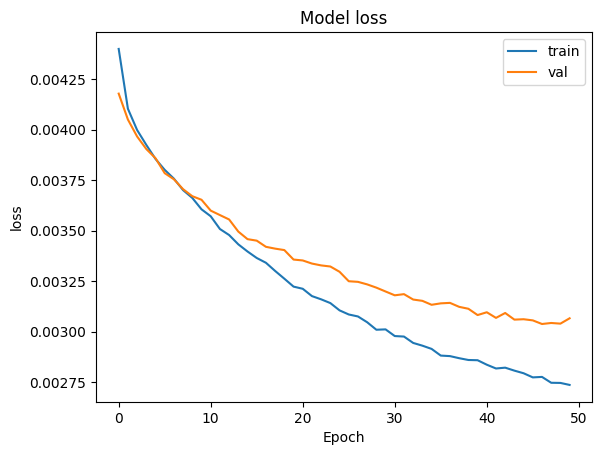

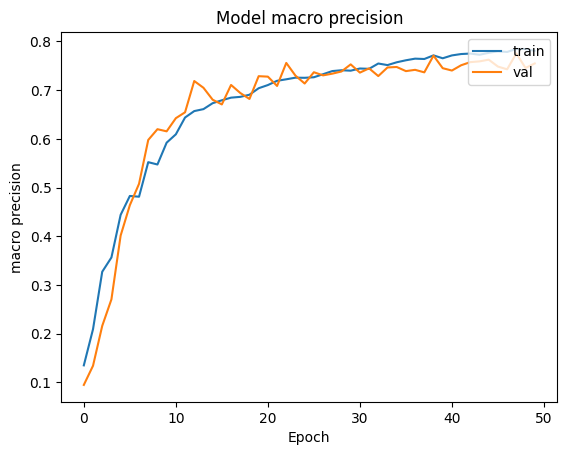

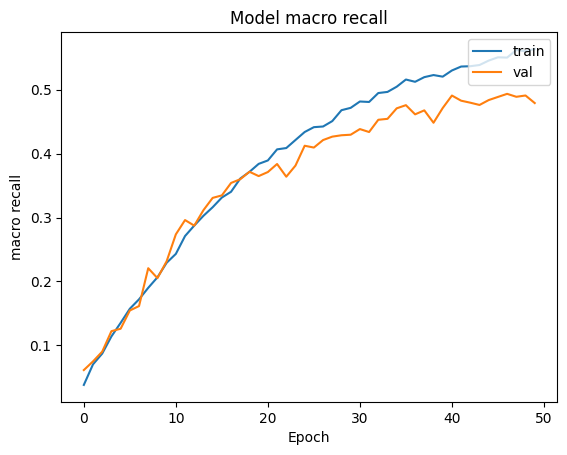

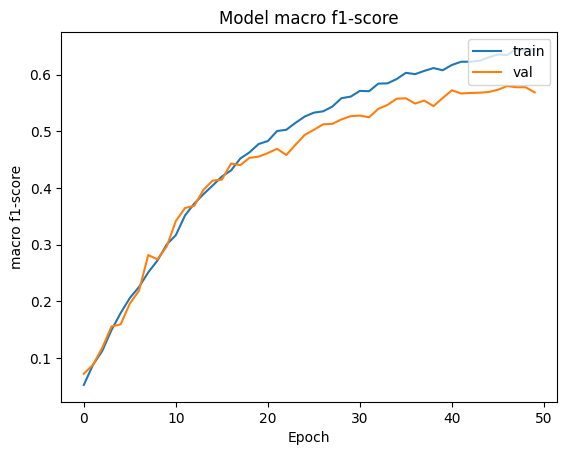

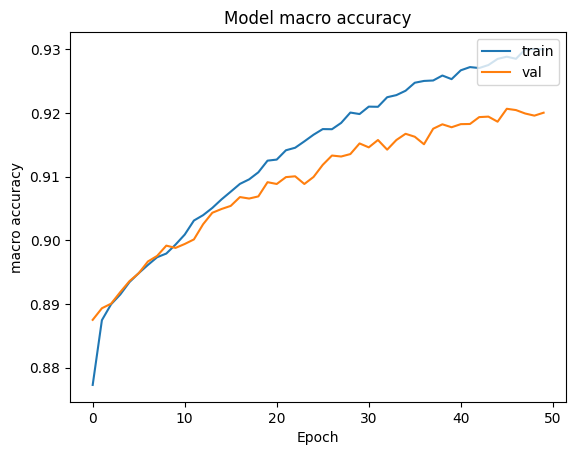

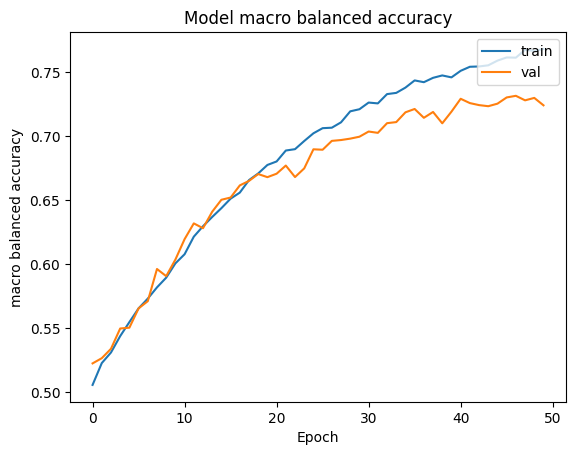

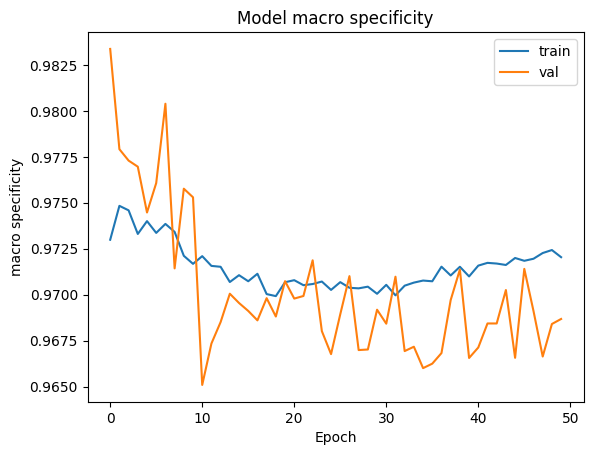

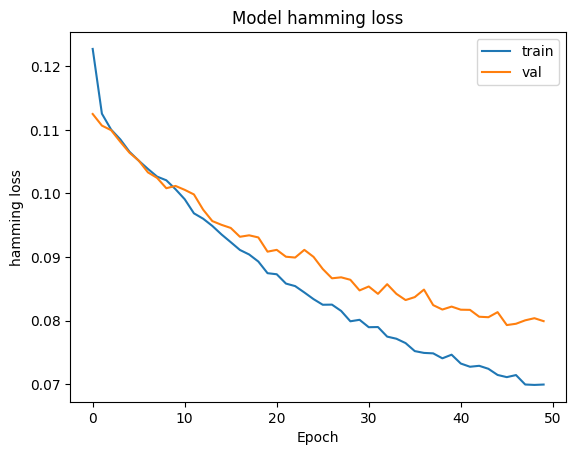

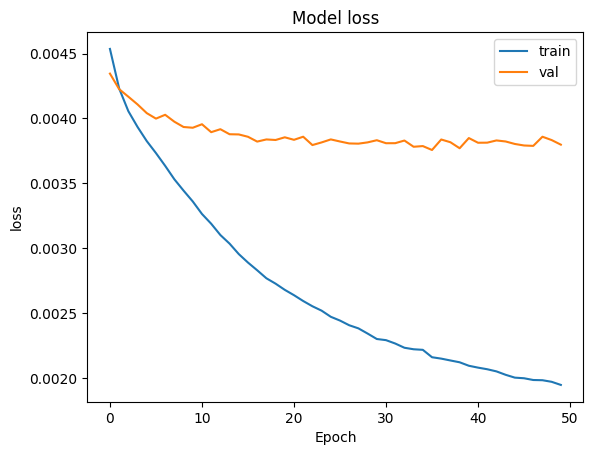

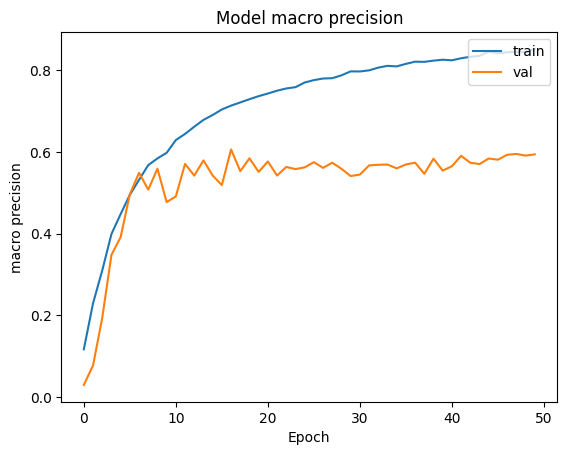

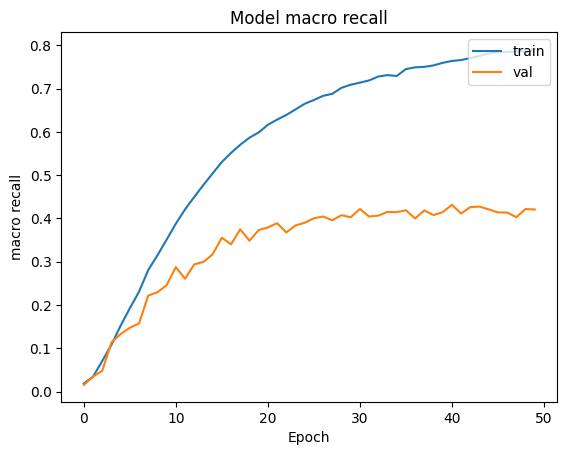

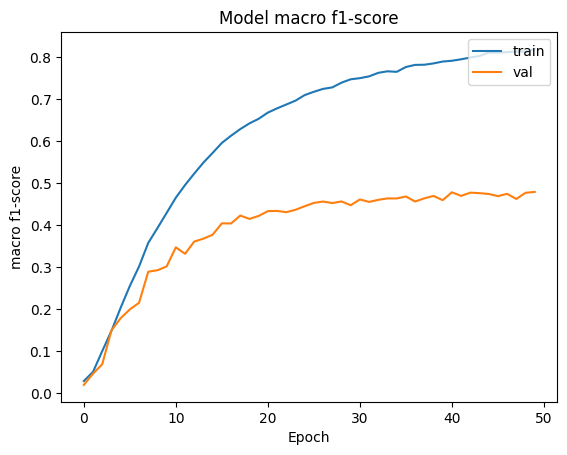

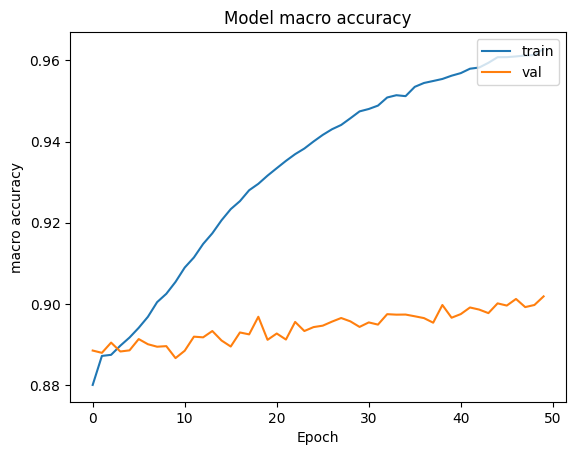

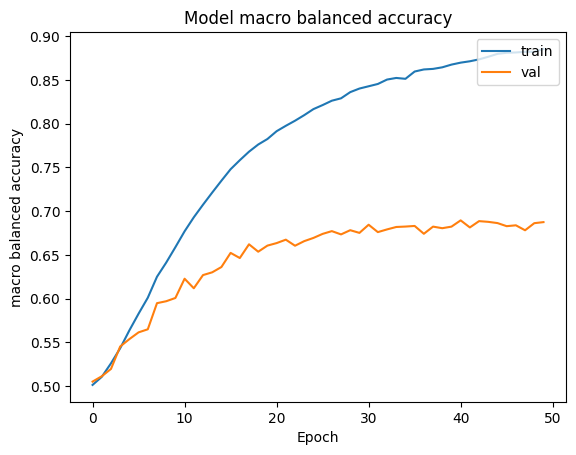

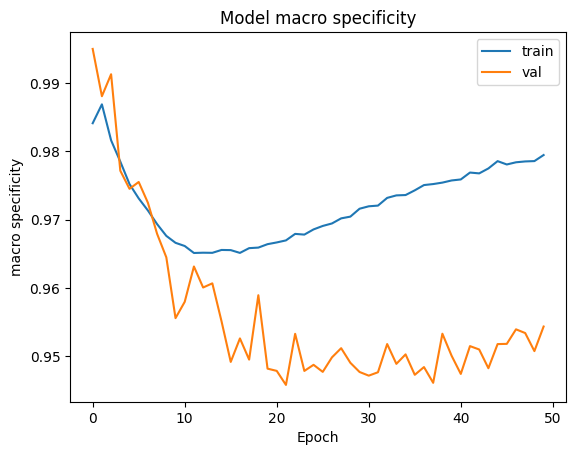

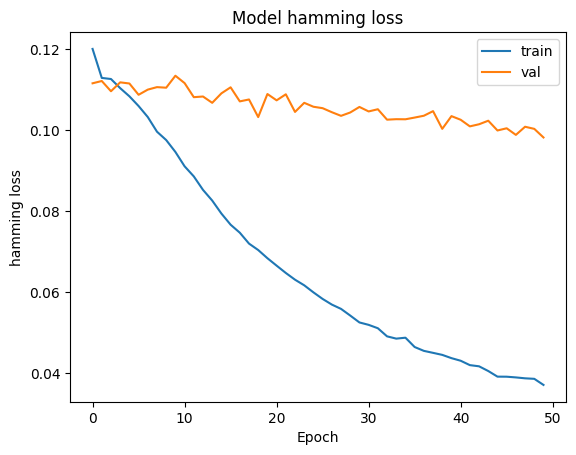

In [30]:
level_2_trainer.run()

In [32]:
from Tester_1 import Tester_level_2

In [35]:
tester_level_2 = Tester_level_2(
    level_1_model = model_level_1,
    level_2_pre_model = level_2_pre_model,
    fiction_model = fiction_model,
    non_fiction_model = non_fiction_model,
    weights_file = level_1_model_file,
    data_loader = test_dataloader,
    fiction_checkpoint_dir = './checkpoints/Efficientnet-B3/level_2_/fiction',
    non_fiction_checkpoint_dir = './checkpoints/Efficientnet-B3/level_2_/non_fiction',
    fiction_gamma_pos = fiction_gamma_pos,
    fiction_gamma_neg = fiction_gamma_neg,
    non_fiction_gamma_pos = non_fiction_gamma_pos,
    non_fiction_gamma_neg = non_fiction_gamma_neg
)


fiction weights are loaded
non fiction weights are loaded


In [36]:
tester_level_2.prediction()

started prediction
2024-06-13 10:26:01.619691


100%|██████████████████████████| 49/49 [00:49<00:00,  1.02s/batch, loss=0.00195]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOSS test 0.002923783380538225, test_precision 0.7710117832742772, test_recall 0.5072456739659645, test_f1 0.59851295418777, test_accuracy 0.9231558977792652, test_BA 0.7392250973029432, test_specificity 0.9712045206399216, test_hamming_loss 0.07684410222073394
acc [0.93851133 0.87378641 0.98317152 0.8763754  0.9605178  0.98576052
 0.96893204 0.99482201 0.94757282 0.94951456 0.9197411  0.97799353
 0.82200647 0.93462783 0.89838188 0.73139159 0.77605178 0.96634304
 0.98317152 0.92297735 0.97928803 0.96634304 0.89126214 0.9605178
 0.98834951 0.95728155 0.85048544 0.96763754 0.7987055 ]
precision [0.70238095 0.68075117 0.8974359  0.76205788 0.60655738 0.88888889
 0.72       0.98       0.58823529 0.53658537 0.73584906 0.95238095
 0.59541985 0.89855072 0.71186441 0.721202   0.71217712 0.9122807
 0.984375   0.88888889 0.76       0.7027027  0.79562044 0.72222222
 0.93406593 0.75675676 0.73684211 0.76315789 0.71209213]
recall [0.45736434 0.53308824 0.61403509 0.66949153 0.5        0.75
 0.66666

100%|██████████████████████████| 40/40 [00:41<00:00,  1.03s/batch, loss=0.00355]

LOSS test 0.003411298617720604, test_precision 0.6096647023772175, test_recall 0.47307509404669057, test_f1 0.5231912911865344, test_accuracy 0.9098374072457436, test_BA 0.7125707752734151, test_specificity 0.9520664565001395, test_hamming_loss 0.09016259275425534
acc [0.93670886 0.88212025 0.9375     0.9375     0.97547468 0.94620253
 0.96123418 0.97468354 0.92246835 0.93433544 0.9414557  0.92405063
 0.7278481  0.73655063 0.92405063 0.86234177 0.9375     0.94699367
 0.96914557 0.89161392 0.94462025 0.85522152 0.97151899 0.84651899
 0.89161392 0.95490506 0.95490506 0.91139241 0.78481013]
precision [0.56666667 0.57042254 0.43181818 0.66666667 0.90361446 0.39285714
 0.72222222 0.78787879 0.43859649 0.60240964 0.75       0.58426966
 0.55360624 0.57641921 0.64583333 0.4829932  0.56164384 0.66666667
 0.86075949 0.46212121 0.609375   0.74545455 0.89189189 0.53409091
 0.61392405 0.25       0.80555556 0.41269841 0.58982036]
recall [0.38636364 0.47928994 0.26027397 0.43564356 0.76530612 0.392857


/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
